# Preparation
## Imports

In [1]:
%config IPCompleter.greedy=True
from IPython.display import display, HTML

In [2]:
import os
import warnings
import logging
import pickle
import sys
import time
import collections
from itertools import groupby

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import sklearn
import seaborn as sns

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import make_column_transformer

from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report   
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import metrics



from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, SVMSMOTE, BorderlineSMOTE, SMOTENC
from imblearn.over_sampling import ADASYN

import config
try:
    del sys.modules['feutils']
except:
    pass
from feutils import DataHandler

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
logger = logging.getLogger()
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'imblearn'

## Data loading

In [3]:
matrix_subject_phases = os.path.join('..', 'features', 'matrix-2019-0409_14-52-24Features-157015.xlsx')
matrix_agent_phases = os.path.join('..', 'features', 'matrix-2019-0410_17-50-48Features-agent-157015.xlsx')
matrix_subject_nophase = os.path.join('..', 'features', 'matrix-2019-0411_14-05-24Features-nophase.xlsx')
matrix_agent_nophase = os.path.join('..', 'features', 'matrix-2019-0411_15-30-16Features-agent-nophase.xlsx') 
#matrix_subject_phases = os.path.join('..', 'features', 'matrix-2019-0226_15-16-44Features-157015.xlsx')
#matrix_agent_phases = os.path.join('..', 'features', 'matrix-2019-0226_17-18-28Features-agent-157015.xlsx')
#matrix_subject_nophase = os.path.join('..', 'features', 'matrix-2019-0227_20-11-53Features-nophase.xlsx')
#matrix_agent_nophase = os.path.join('..', 'features', 'matrix-2019-0227_22-43-15Features-agent-nophase.xlsx') 

def prepare_df(df):
    # Replace 3 classes (low, medium, high) by 5 classes (ie, score rounded)
    #df['Presence Class'] = df['Presence Score'].round()
    #df['Co-presence Class'] = df['Co-presence Score'].round()
    #df = df.drop(['Presence Score', 'Co-presence Score'], axis=1)
    df = df.rename(index=str,
                   columns={"Presence Class": "PresenceClass", "Co-presence Class": "CopresenceClass"})
    return df

def prepare_agent_df(df):
    df = prepare_df(df)
    df = df.drop(['PresenceClass', 'CopresenceClass', 'Presence Score', 'Co-presence Score', 'Duration', 'Expert'], axis=1)
    agent_cols_rename = {}
    for col in df.columns:
        if col not in ['Candidate', 'Environment']:
            agent_cols_rename[col] = col + '_agent'
    df = df.rename(index=str, columns=agent_cols_rename)
    return df
    
def dfval(df, candidate, environment, column):
    return df.query("Candidate == '%s' & Environment == '%s'" % (candidate, environment))[column].values

print("Loading data - phases split ...")

subject_p_df = pd.read_excel(matrix_subject_phases)
subject_p_df = prepare_df(subject_p_df)
print("   Subject(phases): %d samples" % len(subject_p_df))
agent_p_df = pd.read_excel(matrix_agent_phases)
agent_p_df = prepare_agent_df(agent_p_df)
print("   Agent(phases): %d samples" % len(agent_p_df))
# add Duration feature from subject to agent - requires to first merge both datasets
agent_p_df = pd.merge(agent_p_df, subject_p_df[['Candidate', 'Environment', 'Duration', 'PresenceClass', 'CopresenceClass', 'Presence Score', 'Co-presence Score']], on=['Candidate', 'Environment'], 
                      how='inner', suffixes=(False, False))
print("   Agent(phases-merged): %d samples" % len(agent_p_df))

# no phase

subject_np_df = pd.read_excel(matrix_subject_nophase)
subject_np_df = prepare_df(subject_np_df)
print("   Subject(no phase): %d samples" % len(subject_np_df))
agent_np_df = pd.read_excel(matrix_agent_nophase)
agent_np_df = prepare_agent_df(agent_np_df)
print("   Agent(no phase): %d samples" % len(agent_p_df))
# add Duration feature from subject to agent - requires to first merge both datasets
agent_np_df = pd.merge(agent_np_df, subject_np_df[['Candidate', 'Environment', 'Duration', 'PresenceClass', 'CopresenceClass', 'Presence Score', 'Co-presence Score']], on=['Candidate', 'Environment'], 
                      how='inner', suffixes=(False, False))
print("   Agent(no phase-merged): %d samples" % len(agent_np_df))

subject_p_df.index = [subject_p_df['Candidate'], subject_p_df['Environment']]
agent_p_df.index = [agent_p_df['Candidate'], agent_p_df['Environment']]
subject_np_df.index = [subject_np_df['Candidate'], subject_np_df['Environment']]
agent_np_df.index = [agent_np_df['Candidate'], agent_np_df['Environment']]

intersect = set(subject_p_df.index) & set(agent_p_df.index) & set(subject_np_df.index) & set(agent_np_df.index)
print("  samples intersection %d" % len(intersect))

rejected_from_subject_p_df = set(subject_p_df.index) - intersect
rejected_from_subject_np_df = set(subject_np_df.index) - intersect
rejected_from_agent_p_df = set(agent_p_df.index) - intersect
rejected_from_agent_np_df = set(agent_np_df.index) - intersect

# restrict each dataset to the common samples
subject_p_df = subject_p_df.loc[list(intersect)].reset_index(drop=True)
subject_np_df = subject_np_df.loc[list(intersect)].reset_index(drop=True)
agent_p_df = agent_p_df.loc[list(intersect)].reset_index(drop=True)
agent_np_df = agent_np_df.loc[list(intersect)].reset_index(drop=True)

all_p_df = pd.merge(subject_p_df, agent_p_df.drop(['Duration', 'PresenceClass', 'CopresenceClass', 'Presence Score', 'Co-presence Score'], axis=1), on=['Candidate', 'Environment'], 
                    how='inner', suffixes=(False, False))
#all_p_df = all_p_df.drop(['PresenceClass_agent', 'CopresenceClass_agent', 'Duration_agent', 'Expert_agent'], axis=1)
print("   Merge(phases): %d samples " % len(all_p_df))

all_np_df = pd.merge(subject_np_df, agent_np_df.drop(['Duration', 'PresenceClass', 'CopresenceClass', 'Presence Score', 'Co-presence Score'], axis=1), on=['Candidate', 'Environment'], 
                     how='inner', suffixes=(False, False))
#all_np_df = all_np_df.drop(['PresenceClass_agent', 'CopresenceClass_agent', 'Duration_agent', 'Expert_agent'], axis=1)
print("   Merge(no phase): %d samples " % len(all_np_df))

print("")
print("Additional info:")
print("   samples rejected from subject / phases   %d" % len(rejected_from_subject_p_df))
for item in sorted(list(rejected_from_subject_p_df)) : print("     %s / %s" % (item[0], item[1]))
print("   samples rejected from subject / no phase %d" % len(rejected_from_subject_np_df))
for item in sorted(list(rejected_from_subject_np_df)) : print("     %s / %s" % (item[0], item[1]))
print("   samples rejected from agent / phases     %d" % len(rejected_from_agent_p_df))
for item in sorted(list(rejected_from_agent_p_df)) : print("     %s / %s" % (item[0], item[1]))
print("   samples rejected from agent / no phase   %d" % len(rejected_from_agent_np_df))
for item in sorted(list(rejected_from_agent_np_df)) : print("     %s / %s" % (item[0], item[1]))


Loading data - phases split ...
   Subject(phases): 99 samples
   Agent(phases): 103 samples
   Agent(phases-merged): 98 samples
   Subject(no phase): 99 samples
   Agent(no phase): 98 samples
   Agent(no phase-merged): 97 samples
  samples intersection 96
   Merge(phases): 96 samples 
   Merge(no phase): 96 samples 

Additional info:
   samples rejected from subject / phases   3
     E11E / Cave
     E3C / Cave
     N22D / Casque
   samples rejected from subject / no phase 3
     E11E / Cave
     E3C / Cave
     N22D / Casque
   samples rejected from agent / phases     2
     E11E / Cave
     E3C / Cave
   samples rejected from agent / no phase   1
     N22D / Casque


In [4]:
print(subject_np_df.columns)

Index([u'Candidate', u'Environment', u'Expert', u'Head_Entropy_Start',
       u'Head_Entropy_Mid', u'Head_Entropy_End', u'LeftWrist_Entropy_Start',
       u'LeftWrist_Entropy_Mid', u'LeftWrist_Entropy_End',
       u'RightWrist_Entropy_Start', u'RightWrist_Entropy_Mid',
       u'RightWrist_Entropy_End', u'LeftElbow_Entropy_Start',
       u'LeftElbow_Entropy_Mid', u'LeftElbow_Entropy_End',
       u'RightElbow_Entropy_Start', u'RightElbow_Entropy_Mid',
       u'RightElbow_Entropy_End', u'Avg_HandEntropy_Begin',
       u'Avg_HandEntropy_Mid', u'Avg_HandEntropy_End', u'Freq_Adjective_Begin',
       u'Freq_Adjective_Mid', u'Freq_Adjective_End', u'Freq_Adverb_Begin',
       u'Freq_Adverb_Mid', u'Freq_Adverb_End', u'Freq_Auxiliary_Begin',
       u'Freq_Auxiliary_Mid', u'Freq_Auxiliary_End', u'Freq_Conjunction_Begin',
       u'Freq_Conjunction_Mid', u'Freq_Conjunction_End',
       u'Freq_Determiner_Begin', u'Freq_Determiner_Mid',
       u'Freq_Determiner_End', u'Freq_Noun_Begin', u'Freq_Noun_Mi

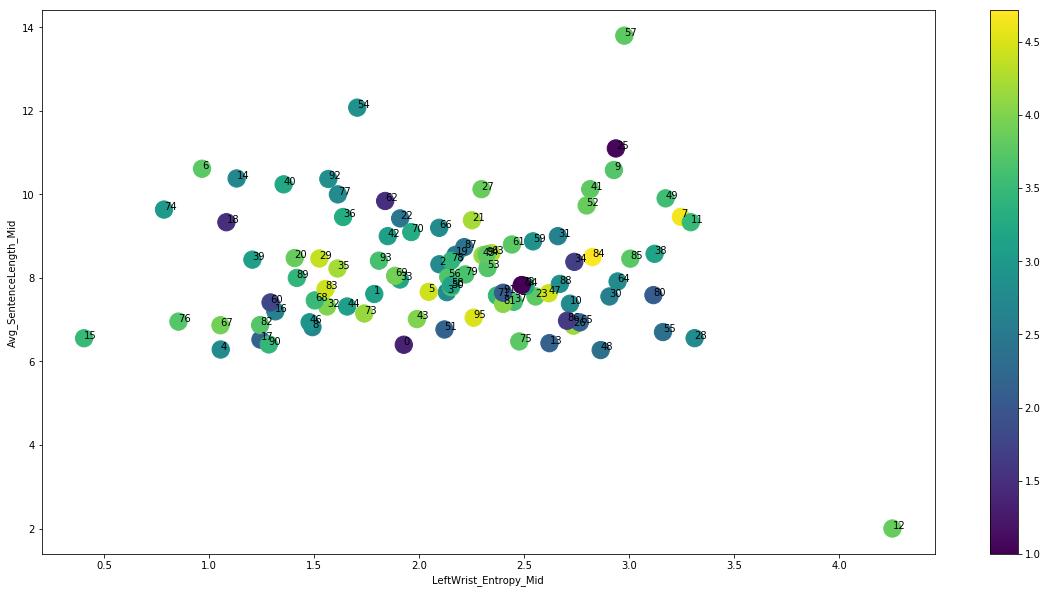

In [5]:
idx_1 = 4
idx_2 = 49
#Avg_SentenceLength_Mid_agent
def plot_variables(samples, idx_1, idx_2, target_column):
    plt.figure(figsize=(20,10))
    plt.scatter(samples.iloc[:, idx_1], samples.iloc[:, idx_2], c=samples[target_column], s=300)
    for idx in np.arange(len(samples)):
        plt.annotate(str(idx), (samples.iloc[idx, idx_1], samples.iloc[idx, idx_2]))
    plt.xlabel(samples.columns[idx_1])
    plt.ylabel(samples.columns[idx_2])
    plt.colorbar()
    plt.show()
    
plot_variables(subject_np_df, 7, 49, 'Presence Score')

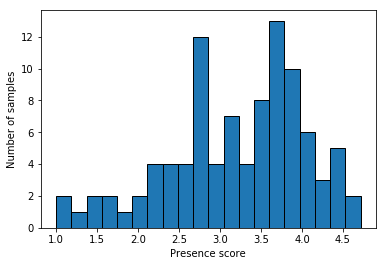

Text(0.5,0,'Co-Presence score')

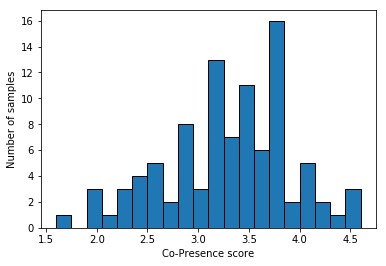

In [6]:
plt.hist(all_p_df['Presence Score'], bins=20, edgecolor='black')
plt.ylabel("Number of samples")
plt.xlabel("Presence score")
plt.show()
plt.hist(all_p_df['Co-presence Score'], bins=20, edgecolor='black')
plt.ylabel("Number of samples")
plt.xlabel("Co-Presence score")

## Discretization of presence and co-presence scores

96
96
(0, {'n_bins': 2, 'strategy': 'uniform'})


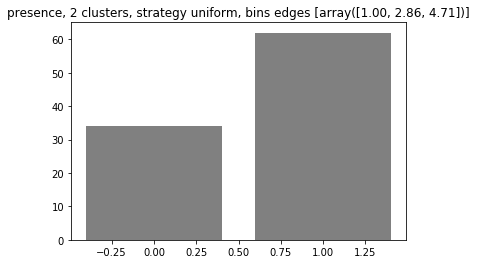

(1, {'n_bins': 2, 'strategy': 'quantile'})


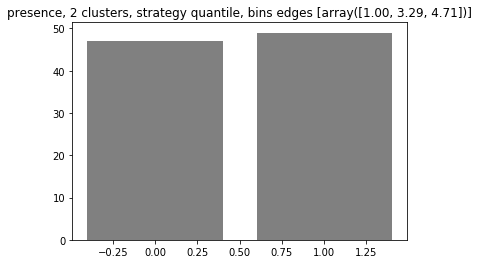

(2, {'n_bins': 2, 'strategy': 'kmeans'})


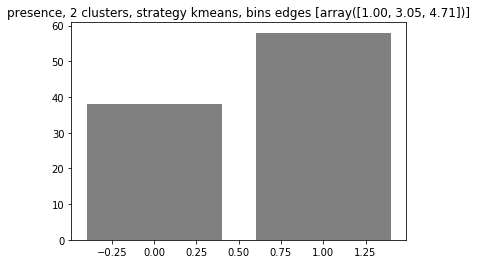

(3, {'n_bins': 3, 'strategy': 'uniform'})


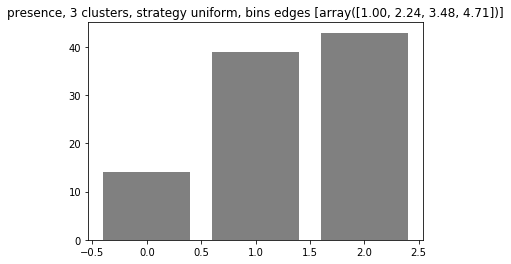

(4, {'n_bins': 3, 'strategy': 'quantile'})


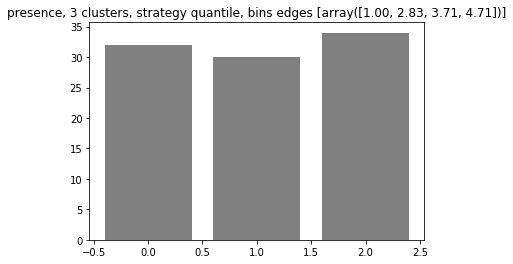

(5, {'n_bins': 3, 'strategy': 'kmeans'})


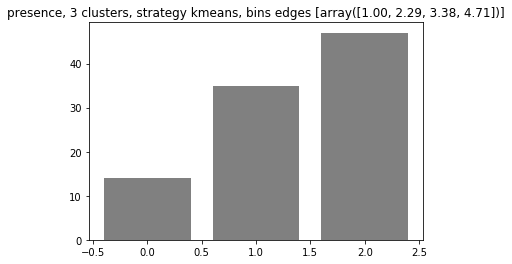

(6, {'n_bins': 4, 'strategy': 'uniform'})


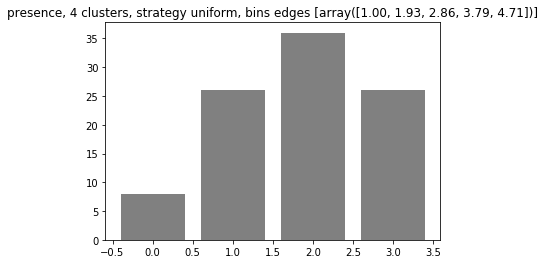

(7, {'n_bins': 4, 'strategy': 'quantile'})


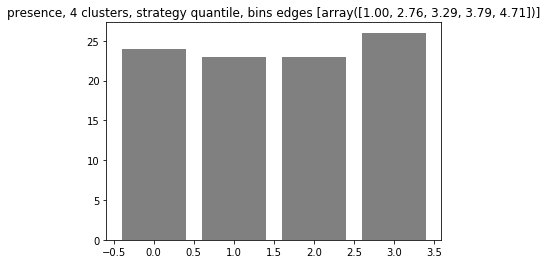

(8, {'n_bins': 4, 'strategy': 'kmeans'})


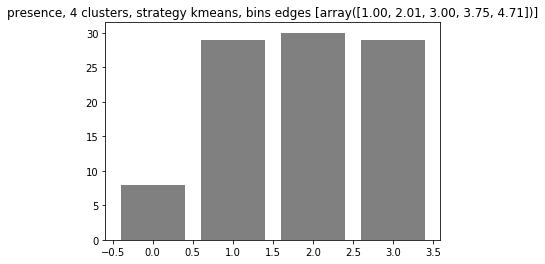

(9, {'n_bins': 5, 'strategy': 'uniform'})


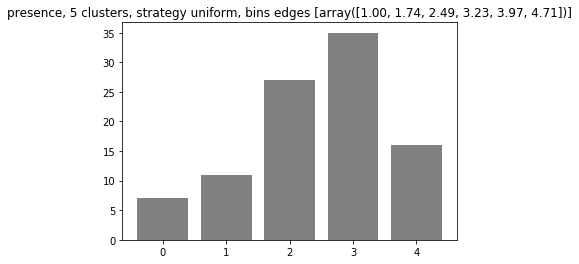

(10, {'n_bins': 5, 'strategy': 'quantile'})


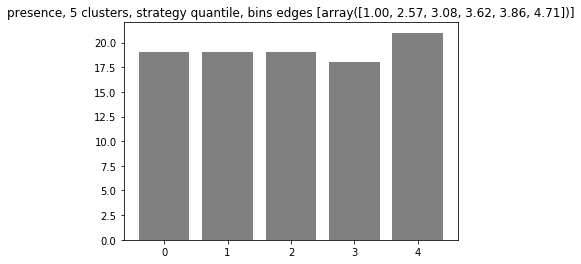

(11, {'n_bins': 5, 'strategy': 'kmeans'})


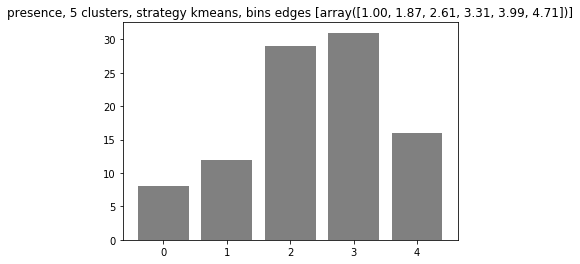

(12, {'n_bins': 6, 'strategy': 'uniform'})


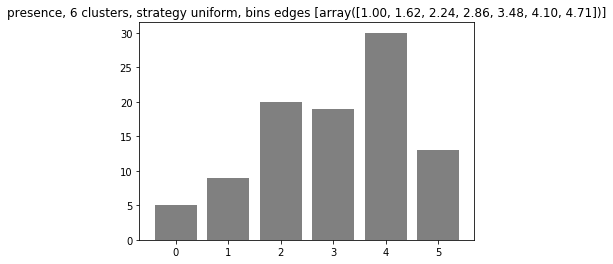

(13, {'n_bins': 6, 'strategy': 'quantile'})


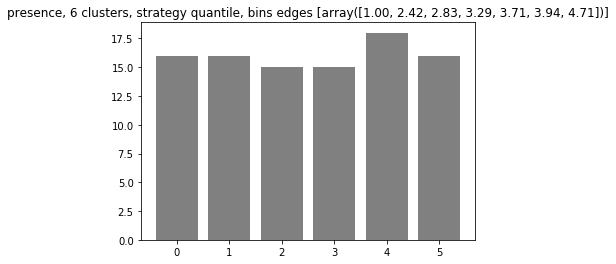

(14, {'n_bins': 6, 'strategy': 'kmeans'})


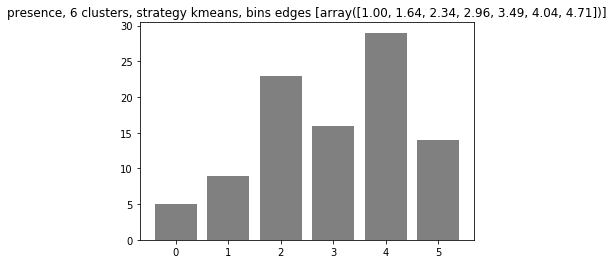

(15, {'n_bins': 7, 'strategy': 'uniform'})


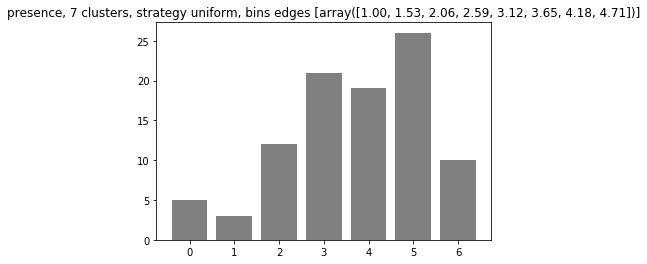

(16, {'n_bins': 7, 'strategy': 'quantile'})


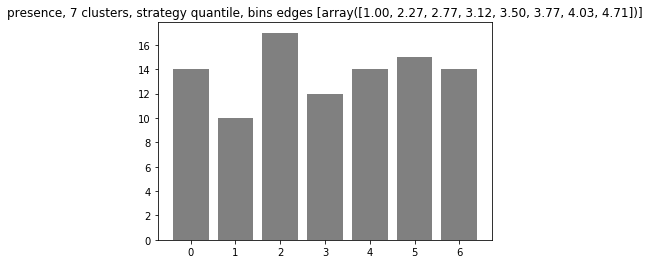

(17, {'n_bins': 7, 'strategy': 'kmeans'})


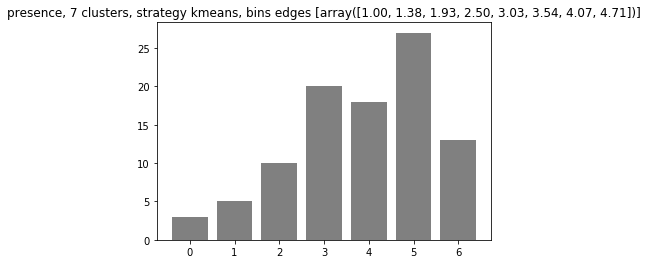

(18, {'n_bins': 8, 'strategy': 'uniform'})


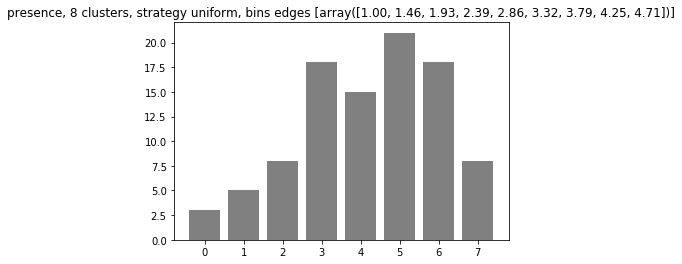

(19, {'n_bins': 8, 'strategy': 'quantile'})


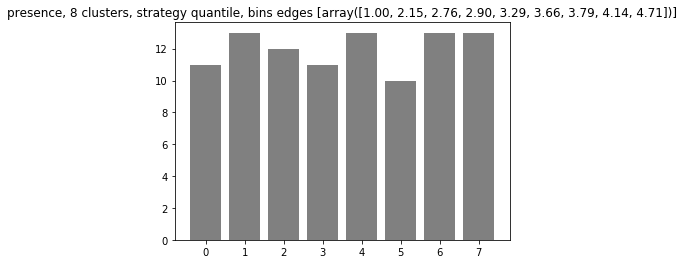

(20, {'n_bins': 8, 'strategy': 'kmeans'})


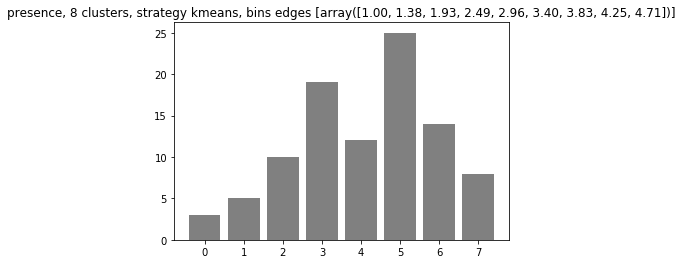

(21, {'n_bins': 9, 'strategy': 'uniform'})


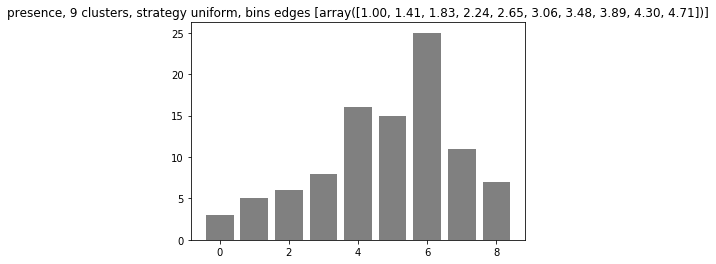

(22, {'n_bins': 9, 'strategy': 'quantile'})


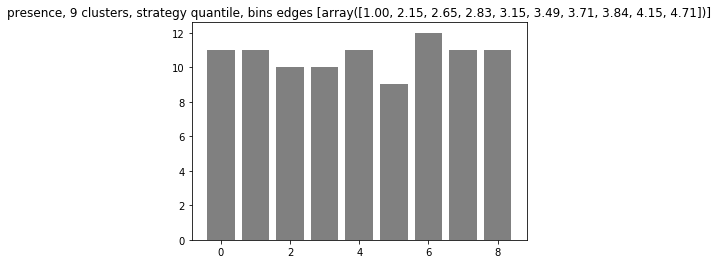

(23, {'n_bins': 9, 'strategy': 'kmeans'})


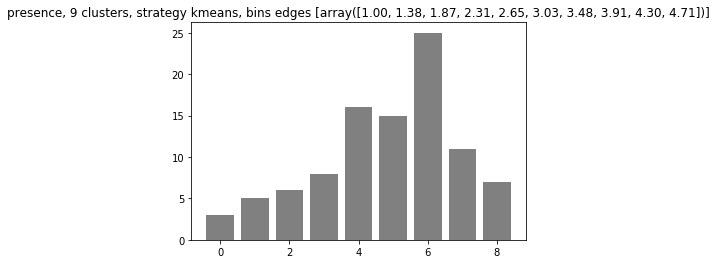

(24, {'n_bins': 10, 'strategy': 'uniform'})


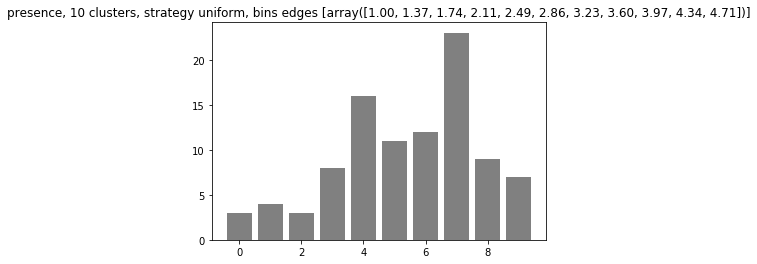

(25, {'n_bins': 10, 'strategy': 'quantile'})


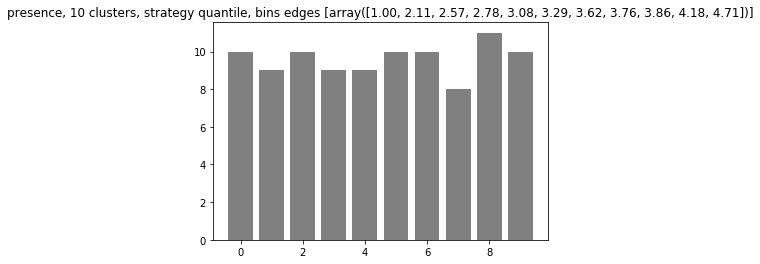

(26, {'n_bins': 10, 'strategy': 'kmeans'})


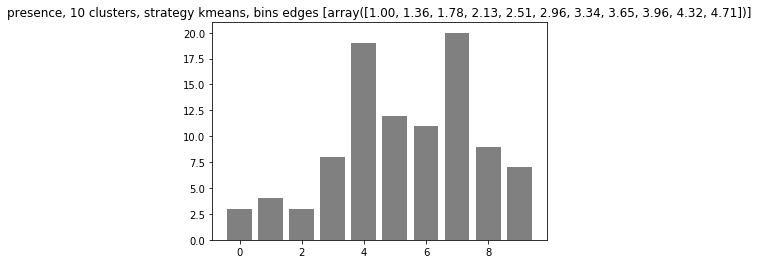

(0, {'n_bins': 2, 'strategy': 'uniform'})


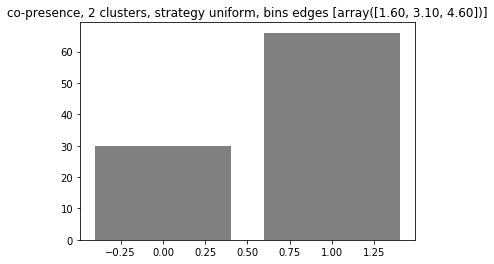

(1, {'n_bins': 2, 'strategy': 'quantile'})


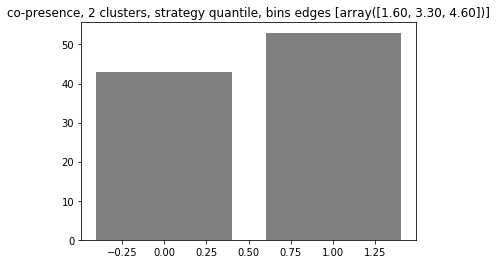

(2, {'n_bins': 2, 'strategy': 'kmeans'})


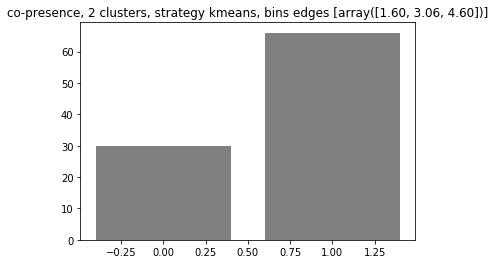

(3, {'n_bins': 3, 'strategy': 'uniform'})


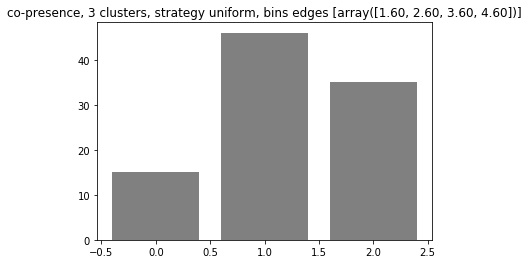

(4, {'n_bins': 3, 'strategy': 'quantile'})


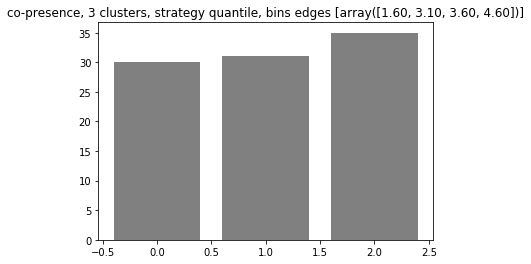

(5, {'n_bins': 3, 'strategy': 'kmeans'})


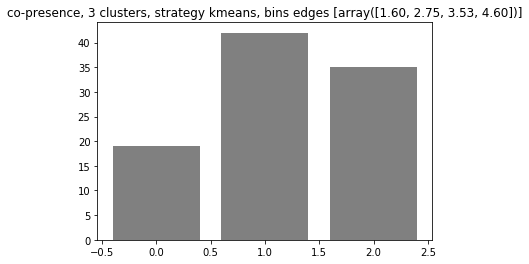

(6, {'n_bins': 4, 'strategy': 'uniform'})


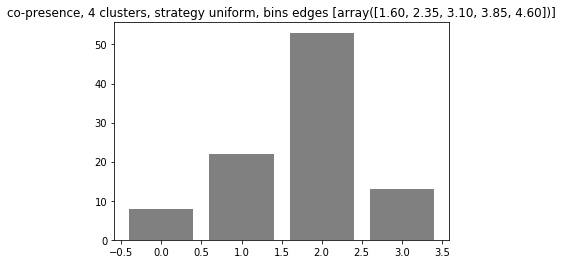

(7, {'n_bins': 4, 'strategy': 'quantile'})


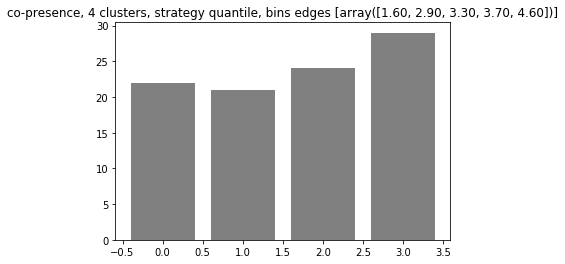

(8, {'n_bins': 4, 'strategy': 'kmeans'})


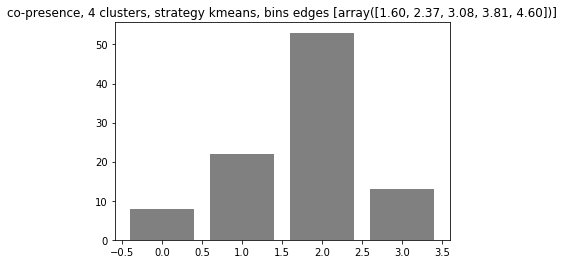

(9, {'n_bins': 5, 'strategy': 'uniform'})


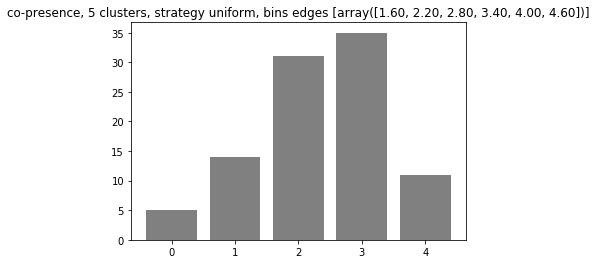

(10, {'n_bins': 5, 'strategy': 'quantile'})


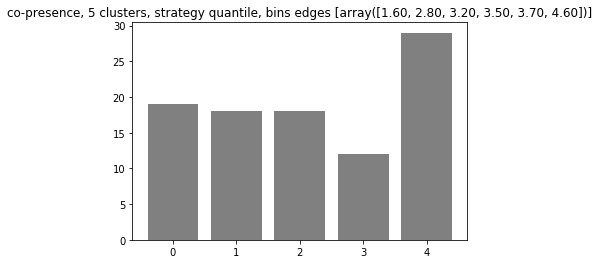

(11, {'n_bins': 5, 'strategy': 'kmeans'})


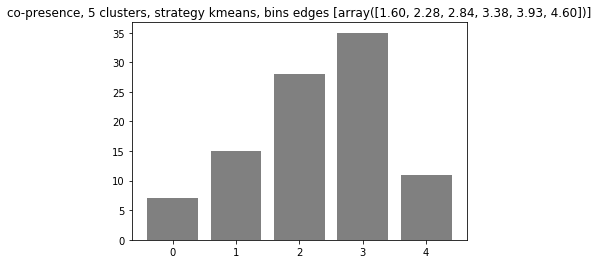

(12, {'n_bins': 6, 'strategy': 'uniform'})


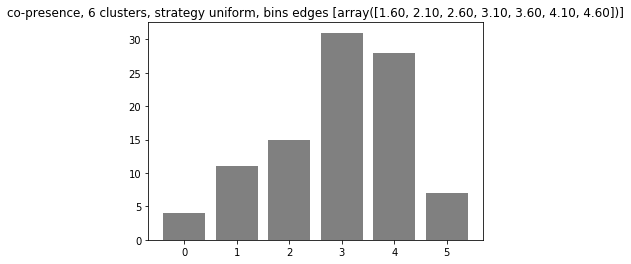

(13, {'n_bins': 6, 'strategy': 'quantile'})


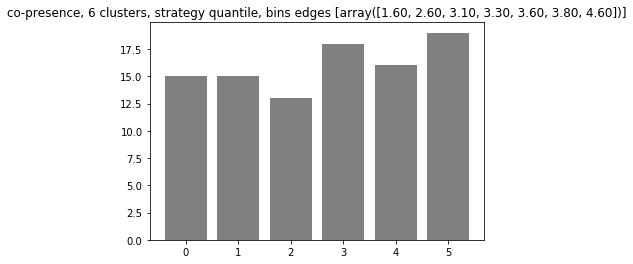

(14, {'n_bins': 6, 'strategy': 'kmeans'})


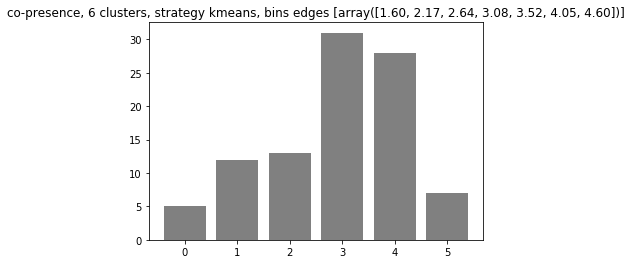

(15, {'n_bins': 7, 'strategy': 'uniform'})


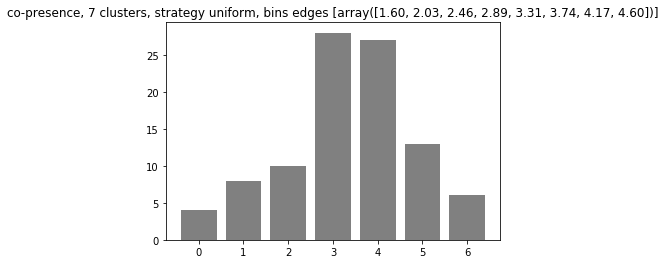

(16, {'n_bins': 7, 'strategy': 'quantile'})


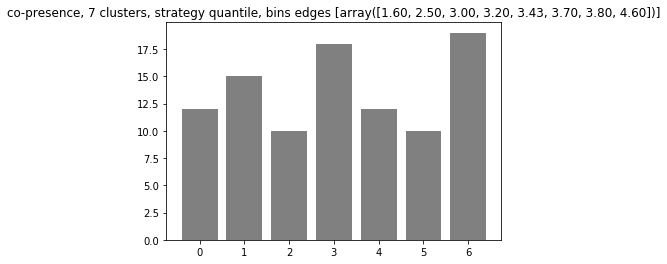

(17, {'n_bins': 7, 'strategy': 'kmeans'})


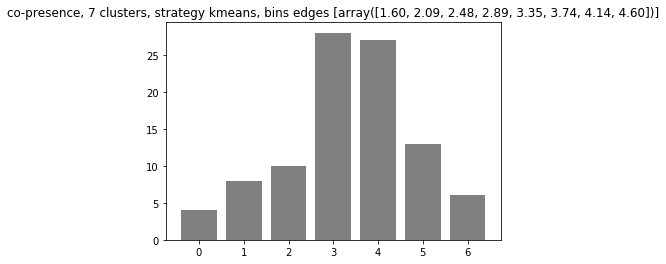

(18, {'n_bins': 8, 'strategy': 'uniform'})


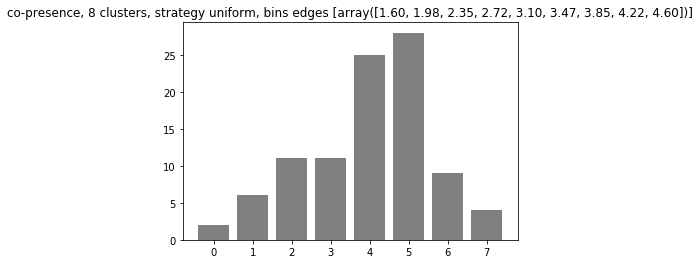

(19, {'n_bins': 8, 'strategy': 'quantile'})


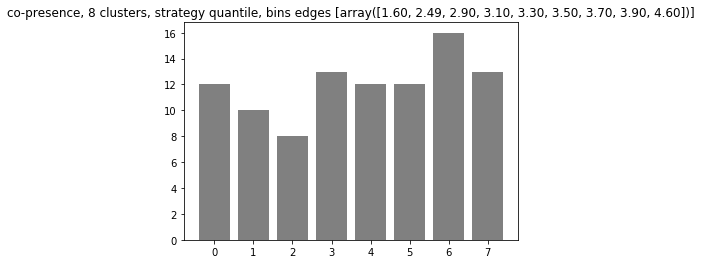

(20, {'n_bins': 8, 'strategy': 'kmeans'})


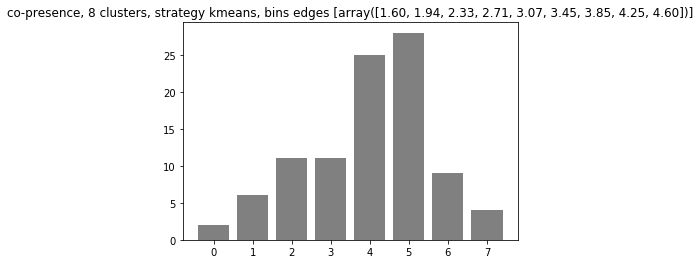

(21, {'n_bins': 9, 'strategy': 'uniform'})


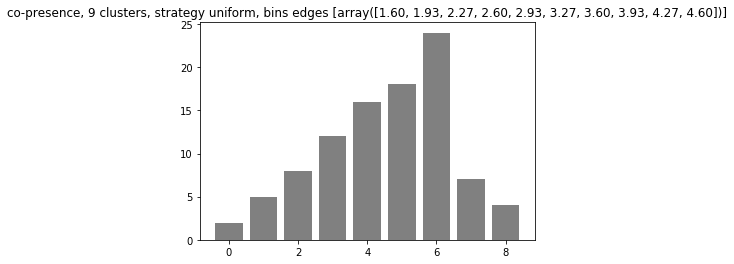

(22, {'n_bins': 9, 'strategy': 'quantile'})


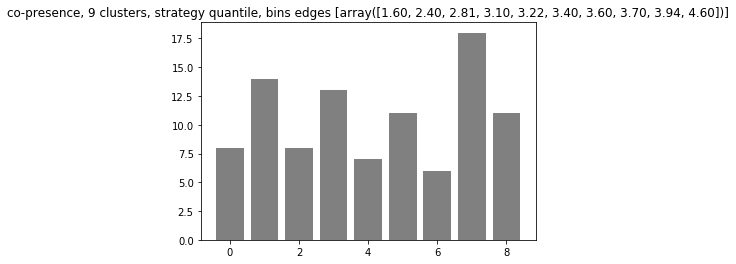

(23, {'n_bins': 9, 'strategy': 'kmeans'})


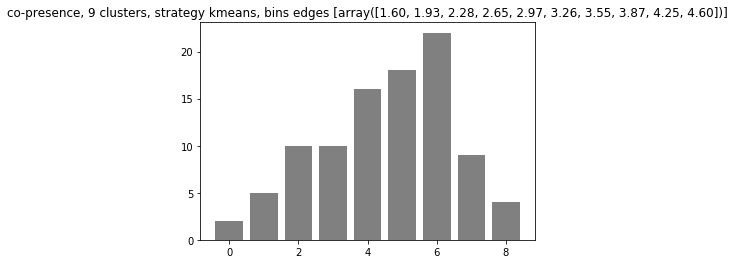

(24, {'n_bins': 10, 'strategy': 'uniform'})


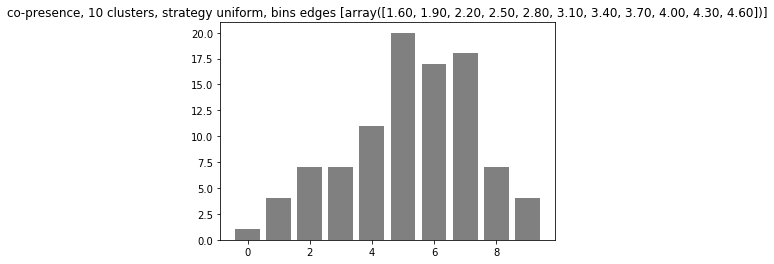

(25, {'n_bins': 10, 'strategy': 'quantile'})


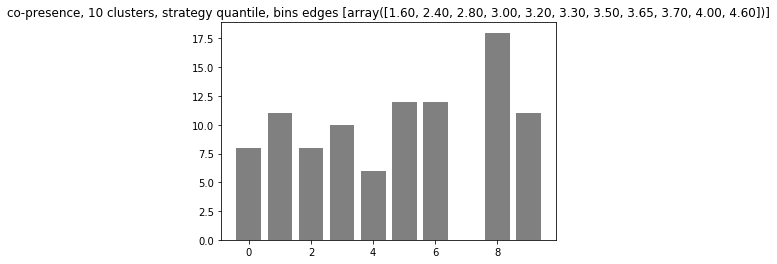

(26, {'n_bins': 10, 'strategy': 'kmeans'})


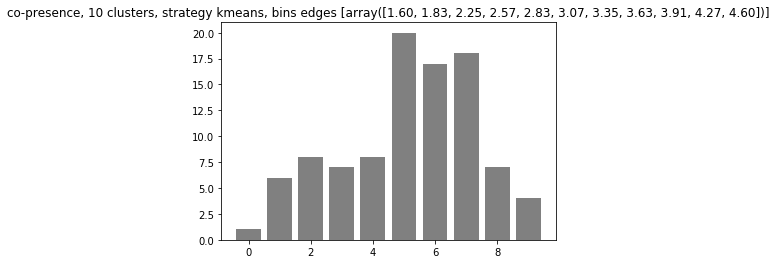

In [7]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import metrics

#TODO MDLP discretizer ?

discretization_params = {
    'n_bins' : [2,3,4,5,6,7,8,9,10],
    'strategy' : ['uniform', 'quantile', 'kmeans']
}

def discretize(data, n_bins, strategy):
    enc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    pres_arr = np.array(data).reshape(-1,1)
    pres_kmeans = enc.fit_transform(pres_arr).astype(int)
    return pres_kmeans, enc

def compute_discretization_scores(data, labels):
    calinski = metrics.calinski_harabaz_score(data, labels)
    silhouette = metrics.silhouette_score(data, labels, metric='euclidean')
    db = metrics.davies_bouldin_score(data, labels)
    min_cluster = np.unique(labels, return_counts=True)[1].min()
    max_cluster = np.unique(labels, return_counts=True)[1].max()  
    return [calinski, silhouette, db, min_cluster, max_cluster]

def discretization_gridsearch(data, discretization_params, orig_discretization=None, title_prefix='presence, '):
    data = np.array(data).reshape(-1, 1)
    discretization_params_grid = ParameterGrid(discretization_params)
    results = np.zeros(shape=(len(discretization_params_grid)+1, 5))
    for idx, param_set in enumerate(discretization_params_grid):
        print(idx, param_set)
        pres_kmeans, enc = discretize(data, n_bins=param_set['n_bins'], strategy=param_set['strategy'])
        bins = np.bincount(pres_kmeans.astype(int).flatten())
        plt.bar(range(len(bins)), bins, color='grey')
        #plt.hist(pres_kmeans.astype(int))
        plt.title('%s%d clusters, strategy %s, bins edges %s' % (title_prefix, param_set['n_bins'], param_set['strategy'], enc.bin_edges_))
        plt.show()

        results[idx] = compute_discretization_scores(data, pres_kmeans)
    if orig_discretization is not None:
        results[-1] = compute_discretization_scores(data, orig_discretization)
    myindex = ["%s (%s)" % (p['n_bins'], p['strategy']) for p in discretization_params_grid]
    myindex.append("3 (orig)")
    cluster_results = pd.DataFrame(data=results, index=myindex, columns=['Calinski-Harabaz', 'Silhouette', 'Davies-Bouldin',
                                                                        'min cluster nb', 'max cluster nb'])
    cluster_results['C-H'] = (cluster_results['Calinski-Harabaz'] - cluster_results['Calinski-Harabaz'].mean()) / cluster_results['Calinski-Harabaz'].std()
    cluster_results['S'] = (cluster_results['Silhouette'] - cluster_results['Silhouette'].mean()) / cluster_results['Silhouette'].std()
    cluster_results['D-B'] = (cluster_results['Davies-Bouldin'] - cluster_results['Davies-Bouldin'].mean()) / cluster_results['Davies-Bouldin'].std()
    cluster_results['Weighted'] = cluster_results['D-B'] - cluster_results['C-H'] - cluster_results['S']
    return cluster_results

def highlight_max(x):
    return ['color: red' if v == x.max() else 'color: green' if v == x.min() else '' for v in x]

presence = all_p_df.sort_values(by=['Presence Score'])['Presence Score']
copresence = all_p_df.sort_values(by=['Co-presence Score'])['Co-presence Score']
orig_pres = all_p_df.sort_values(by=['Presence Score'])['PresenceClass']
orig_copres = all_p_df.sort_values(by=['Co-presence Score'])['CopresenceClass']
print(len(presence))
print(len(orig_pres))

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
pres_clusters_results = discretization_gridsearch(presence, discretization_params, orig_pres, 'presence, ')
copres_clusters_results = discretization_gridsearch(copresence, discretization_params, orig_copres, 'co-presence, ')
np.set_printoptions()

In [8]:
#pres_clusters_results.style.apply(highlight_max).to_excel(os.path.join(config.OUT_PATH, 'presence_discretization.xlsx'))
#copres_clusters_results.style.apply(highlight_max).to_excel(os.path.join(config.OUT_PATH, 'copresence_discretization.xlsx'))

def highlight_low_clusters(s):
    if s['min cluster nb'] < 7.0: # because upsampling algorithms consider 6 neighbors
        return ['color: red']*9
    else:
        return ['background-color: white']*9

pres_clusters_results.sort_values(by=['Weighted']).style.apply(highlight_low_clusters, axis=1).to_excel(os.path.join(config.OUT_PATH, 'presence_discretization.xlsx'))
copres_clusters_results.sort_values(by=['Weighted']).style.apply(highlight_low_clusters, axis=1).to_excel(os.path.join(config.OUT_PATH, 'copresence_discretization.xlsx'))
pres_clusters_results.sort_values(by=['Weighted']).style.apply(highlight_low_clusters, axis=1)

In [9]:
copres_clusters_results.sort_values(by=['Weighted']).style.apply(highlight_low_clusters, axis=1)

Best discretization corresponds to highest values for Calinsky-Harabaz and Silouhette, and lowest values for Davies-Bouldin indices.
Columns C-H, S and D-B are centered / reduced values of each index, weighted is D-B minus S and C-H. By looking at lowest values in 'Weighted' we hope to maximize C-H and S while minimizing D-B.
(lines in red are suppressed because they have too small cluster(s))

## Features definition
### Features

In [8]:
# features including phases

feats_df_index = ['type']
feats_df_columns = all_p_df.columns

feats_df = pd.DataFrame(index=feats_df_index, columns=feats_df_columns)
feats_df

Candidate Environment Expert Head_Entropy_Start Head_Entropy_Mid  \
type       NaN         NaN    NaN                NaN              NaN   

     Head_Entropy_End LeftWrist_Entropy_Start LeftWrist_Entropy_Mid  \
type              NaN                     NaN                   NaN   

     LeftWrist_Entropy_End RightWrist_Entropy_Start  ...  \
type                   NaN                      NaN  ...   

     Avg_SentenceLength_End_agent Avg_IPUlen_Begin_agent  \
type                          NaN                    NaN   

     Avg_IPUlen_Middle_agent Avg_IPUlen_End_agent Ratio1_Begin_agent  \
type                     NaN                  NaN                NaN   

     Ratio1_Mid_agent Ratio1_End_agent Ratio2_Begin_agent Ratio2_Mid_agent  \
type              NaN              NaN                NaN              NaN   

     Ratio2_End_agent  
type              NaN  

[1 rows x 122 columns]

### Features sets

In [9]:
# features including phases

features_df_index = [
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['No Phase', '157015', 'Verbal', 'Non-Verbal', 'Multimodal']   #, 'Multimodal+Duration']
            ]
features_df_columns = ['precision', 'f1', 'recall', 'params']
features_df_multiindex = pd.MultiIndex.from_product(features_df_index, 
                                                  names=['Subject', 'Feature Set'])

features_df = pd.DataFrame(index=features_df_multiindex)
features_df

Empty DataFrame
Columns: []
Index: [(Doctor, No Phase), (Doctor, 157015), (Doctor, Verbal), (Doctor, Non-Verbal), (Doctor, Multimodal), (Agent, No Phase), (Agent, 157015), (Agent, Verbal), (Agent, Non-Verbal), (Agent, Multimodal), (Doctor+Agent, No Phase), (Doctor+Agent, 157015), (Doctor+Agent, Verbal), (Doctor+Agent, Non-Verbal), (Doctor+Agent, Multimodal)]

In [10]:
def get_features_set(subject_name, set_name):
    row = features_df.loc[(subject_name, set_name)]
    return features_df.columns[row == True]

# Load features sets definition
features_df = pd.read_excel(os.path.join(config.OUT_PATH, 'features_sets.xlsx'))
features_df.index = features_df_multiindex
features_df = features_df.drop(['Subject', 'Feature Set'], axis=1)
features_df

Expert  Head_Entropy_Start  Head_Entropy_Mid  \
Subject      Feature Set                                                 
Doctor       No Phase       True               False              True   
             157015         True                True              True   
             Verbal        False               False             False   
             Non-Verbal    False               False              True   
             Multimodal    False               False              True   
Agent        No Phase      False               False             False   
             157015        False               False             False   
             Verbal        False               False             False   
             Non-Verbal    False               False             False   
             Multimodal    False               False             False   
Doctor+Agent No Phase       True               False              True   
             157015         True                True              True   
             Verbal        False               False             False   
             Non-Verbal    False               False              True   
             Multimodal    False               False              True   

                          Head_Entropy_End  Avg_HandEntropy_Begin  \
Subject      Feature Set                                            
Doctor       No Phase                False                  False   
             157015                   True                   True   
             Verbal                  False                  False   
             Non-Verbal              False                  False   
             Multimodal              False                  False   
Agent        No Phase                False                  False   
             157015                  False                  False   
             Verbal                  False                  False   
             Non-Verbal              False                  False   
             Multimodal              False                  False   
Doctor+Agent No Phase                False                  False   
             157015                   True                   True   
             Verbal                  False                  False   
             Non-Verbal              False                  False   
             Multimodal              False                  False   

                          Avg_HandEntropy_Mid  Avg_HandEntropy_End  \
Subject      Feature Set                                             
Doctor       No Phase                    True                False   
             157015                      True                 True   
             Verbal                     False                False   
             Non-Verbal                  True                False   
             Multimodal                  True                False   
Agent        No Phase                   False                False   
             157015                     False                False   
             Verbal                     False                False   
             Non-Verbal                 False                False   
             Multimodal                 False                False   
Doctor+Agent No Phase                    True                False   
             157015                      True                 True   
             Verbal                     False                False   
             Non-Verbal                  True                False   
             Multimodal                  True                False   

                          Avg_SentenceLength_Begin  Avg_SentenceLength_Mid  \
Subject      Feature Set                                                     
Doctor       No Phase                        False                    True   
             157015                           True                    True   
             Verbal                          False                    True   
            

In [11]:
### Optional - (re)initialize features sets if necessary

# todo "Avg_IPUlen_Begin", "Avg_IPUlen_Middle", "Avg_IPUlen_End" removed because of wrong values
#__features = ["Expert", "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
#             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
#             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
#                    "Ratio2_End", "Duration"]
subject_features = ['Expert', "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration"]
agent_features = [feat+'_agent' for feat in subject_features if feat not in ['Expert', 'Duration']] + ['Duration']
# not using "Expert" feature for agent features
#agent_features = subject_features - {"Expert"}
all_features = subject_features + agent_features[:-1]

features_df = pd.DataFrame(index=features_df_multiindex, columns=all_features)


# features - no phase

subject_features_nophase = [feat for feat in subject_features if not (feat.endswith('_Begin') 
                            or feat.endswith('_End') or feat.endswith('_Start'))]
#["Expert", "Head_Entropy_Mid", "Avg_HandEntropy_Mid", "Avg_SentenceLength_Mid", "Ratio1_Mid", 
#                            "Ratio2_Mid", "Duration"]
agent_features_nophase = [feat for feat in agent_features if not (feat.endswith('_Begin_agent') 
                            or feat.endswith('_End_agent') or feat.endswith('_Start_agent'))]
print(agent_features)
print(agent_features_nophase)
all_features_nophase = subject_features_nophase + agent_features_nophase[:-1]


# for modalities verbal, non-verbal etc, we do not consider phases
# verbal features

subject_features_verbal = ["Avg_SentenceLength_Mid", "Ratio1_Mid", "Ratio2_Mid"]
agent_features_verbal = [feat+'_agent' for feat in subject_features_verbal]
all_features_verbal = subject_features_verbal + agent_features_verbal

# non-verbal features

subject_features_nonverbal = ["Head_Entropy_Mid", "Avg_HandEntropy_Mid"]
agent_features_nonverbal = [feat+'_agent' for feat in subject_features_nonverbal]
all_features_nonverbal = subject_features_nonverbal + agent_features_nonverbal

# multimodal features

subject_features_multimodal = subject_features_verbal + subject_features_nonverbal
agent_features_multimodal = [feat+'_agent' for feat in subject_features_multimodal]
all_features_multimodal = subject_features_multimodal + agent_features_multimodal

# multimodal + duration features

#subject_features_multimodal_duration = subject_features_multimodal + ['Duration']
#agent_features_multimodal_duration = agent_features_multimodal + ['Duration']
#all_features_multimodal_duration = subject_features_multimodal_duration + agent_features_multimodal

for feat in features_df.columns:
    features_df.loc[('Doctor', 'No Phase'), feat] = True if feat in subject_features_nophase else False
    features_df.loc[('Doctor', '157015'), feat] = True if feat in subject_features else False
    features_df.loc[('Doctor', 'Verbal'), feat] = True if feat in subject_features_verbal else False
    features_df.loc[('Doctor', 'Non-Verbal'), feat] = True if feat in subject_features_nonverbal else False
    features_df.loc[('Doctor', 'Multimodal'), feat] = True if feat in subject_features_multimodal else False
    #features_df.loc[('Doctor', 'Multimodal+Duration'), feat] = True if feat in subject_features_multimodal_duration else False
    features_df.loc[('Agent', 'No Phase'), feat] = True if feat in agent_features_nophase else False
    features_df.loc[('Agent', '157015'), feat] = True if feat in agent_features else False
    features_df.loc[('Agent', 'Verbal'), feat] = True if feat in agent_features_verbal else False
    features_df.loc[('Agent', 'Non-Verbal'), feat] = True if feat in agent_features_nonverbal else False
    features_df.loc[('Agent', 'Multimodal'), feat] = True if feat in agent_features_multimodal else False
    #features_df.loc[('Agent', 'Multimodal+Duration'), feat] = True if feat in agent_features_multimodal_duration else False
    features_df.loc[('Doctor+Agent', 'No Phase'), feat] = True if feat in all_features_nophase else False
    features_df.loc[('Doctor+Agent', '157015'), feat] = True if feat in all_features else False
    features_df.loc[('Doctor+Agent', 'Verbal'), feat] = True if feat in all_features_verbal else False
    features_df.loc[('Doctor+Agent', 'Non-Verbal'), feat] = True if feat in all_features_nonverbal else False
    features_df.loc[('Doctor+Agent', 'Multimodal'), feat] = True if feat in all_features_multimodal else False
    #features_df.loc[('Doctor+Agent', 'Multimodal+Duration'), feat] = True if feat in all_features_multimodal_duration else False

features_df.to_excel(os.path.join(config.OUT_PATH, 'features_sets.xlsx'))

['Head_Entropy_Start_agent', 'Head_Entropy_Mid_agent', 'Head_Entropy_End_agent', 'Avg_HandEntropy_Begin_agent', 'Avg_HandEntropy_Mid_agent', 'Avg_HandEntropy_End_agent', 'Avg_SentenceLength_Begin_agent', 'Avg_SentenceLength_Mid_agent', 'Avg_SentenceLength_End_agent', 'Ratio1_Begin_agent', 'Ratio1_Mid_agent', 'Ratio1_End_agent', 'Ratio2_Begin_agent', 'Ratio2_Mid_agent', 'Ratio2_End_agent', 'Duration']
['Head_Entropy_Mid_agent', 'Avg_HandEntropy_Mid_agent', 'Avg_SentenceLength_Mid_agent', 'Ratio1_Mid_agent', 'Ratio2_Mid_agent', 'Duration']


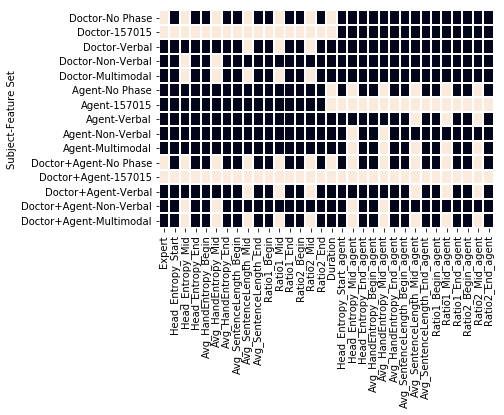

In [12]:


sns.heatmap(features_df.fillna(0).astype('int'), linecolor='white', linewidth=1, annot=False, cbar=False)
plt.savefig(os.path.join(config.OUT_PATH, 'features_sets.png'), bbox_inches = "tight")
plt.show()

# to avoid updating everything below for now

subject_features = get_features_set('Doctor', '157015')
agent_features = get_features_set('Agent', '157015')
all_features = get_features_set('Doctor+Agent', '157015')
subject_features_nophase = get_features_set('Doctor', 'No Phase')
agent_features_nophase = get_features_set('Agent', 'No Phase')
all_features_nophase = get_features_set('Doctor+Agent', 'No Phase')
subject_features_verbal = get_features_set('Doctor', 'Verbal')
agent_features_verbal = get_features_set('Agent', 'Verbal')
all_features_verbal = get_features_set('Doctor+Agent', 'Verbal')
subject_features_nonverbal = get_features_set('Doctor', 'Non-Verbal')
agent_features_nonverbal = get_features_set('Agent', 'Non-Verbal')
all_features_nonverbal = get_features_set('Doctor+Agent', 'Non-Verbal')
subject_features_multimodal = get_features_set('Doctor', 'Multimodal')
agent_features_multimodal = get_features_set('Agent', 'Multimodal')
all_features_multimodal = get_features_set('Doctor+Agent', 'Multimodal')
#subject_features_multimodal_duration = get_features_set('Doctor', 'Multimodal+Duration')
#agent_features_multimodal_duration = get_features_set('Agent', 'Multimodal+Duration')
#all_features_multimodal_duration = get_features_set('Doctor+Agent', 'Multimodal+Duration')


## Dataset preparation

In [13]:


out_path = os.path.join(config.OUT_PATH, 'gridsearchcv')
if not os.path.exists(out_path): os.makedirs(out_path)
    
OUT_PATH=os.path.join(config.OUT_PATH, 'cleaned-20190422')

def discretize_class(samples, prediction_type='classification', prediction_task='presence', bins=None, strategy=None, test_set=0.1):
    """
    Discretizes presence or co-presence score and put result in a new column (if not already existing).
    
    Returns: the name of the new column, or None if one of discretized groups only has 2 samples or less, or if discretization
    failed for any reason.
    """
    
    if prediction_type == 'regression':
        if prediction_task == 'presence':
            return 'Presence Score'
        else:
            return 'Co-presence Score'
    
    cols = []
    for col in samples.columns:
        if 'core' in col:
            cols.append(col)
    print('discretize_class columns %s' % str(cols))
    if bins is None or strategy is None:
        if prediction_task == 'presence':
            class_column='PresenceClass'
        else:
            class_column='CopresenceClass'
        return class_column
    else:
        if prediction_task == 'presence':
            score_column = 'Presence Score'
            class_column = 'PresenceClass_%d_%s' % (bins, strategy)
        else:
            score_column = 'Co-presence Score'
            class_column = 'CopresenceClass_%d_%s' % (bins, strategy)      
    
    if class_column not in samples.columns:
        samples[class_column], enc = discretize(samples[score_column], bins, strategy)
        samples[class_column] = samples[class_column].astype(int)
        #TODO: transform test data with discretizer fit on train data
    
    if any(samples[class_column] == -1) or any(samples[class_column].value_counts() < 3):
        return None
    else:
        return class_column

def prepare_train_data(samples, features, prediction_task, bins=None, strategy=None, upsample=None, test_set=0.1, n_splits=1, arff=None, 
                       verbose=0):
    """
    Prepares a dataset for ML.
    
    Parameters
    ----------
    
    samples: DataFrame
    
    features: list
    
    prediction_task: str
        'presence' or 'copresence'
        
    bins: None or int, default None.
        Number of classes to create when discretizing presence and co-presence.
        If 0 there no discretization is applied and returned y is for a regression task.
    
    strategy: None, 'kmeans', 'uniform' or 'quantile', default None.
        See sklearn, if None defaults to original strategy.
        
    upsample: None or str, default None
        None: no oversampling
        For description of other oversampling method see https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html
        imb_random
        imb_smote
        imb_adasyn
        imb_smotenc
        imb_borderlinesmote1
        imb_borderlinesmote2
        imb_svmsmote
        
    test_set: None or float, default 0.1
        If not None or 0, a test set will produced with specified float as test ratio
        
    n_splits: int, default 1
        Will produce this number of train/test splits.
    
    arff: str
        If str, arff files will be generated using provided path/name. Default is None.
        
    Returns
    -------
    An array of tuples (X, y, X_test, y_test).
    
    """
    if verbose > 0:
        print('prepare_train_data: prediction_task=%s, features=%s, upsamples=%s' % (prediction_task, features, upsample))
        #print('prepare_train_data: unique %d' %  len(np.unique(samples.loc[:, features], return_counts=True, axis=0)[1]))
    
    return_tuples = []
    
    # TODO: should fit discretizer on train then transform train and test
    if bins == 0:
        class_column = 'Presence Score'
    else:
        class_column = discretize_class(samples, 'classification', prediction_task, bins, strategy)
    print('class_column: %s' % class_column)
    if test_set is not None and test_set > 0:
        if bins == 0:
            sss = ShuffleSplit(n_splits=n_splits, test_size=test_set, random_state=RANDOM_STATE)
            splits = [[split[0], split[1]] for split in sss.split(np.zeros(len(samples)), samples[class_column])]
        else:
            sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_set, random_state=RANDOM_STATE)
            splits = [[split[0], split[1]] for split in sss.split(np.zeros(len(samples)), samples[class_column])]
    else:
        splits = [[None, None]]
    print("splits " + str(splits))
    for idx, split in enumerate(splits):
        train_idx = split[0]
        test_idx = split[1]
        print("train " + str(train_idx) + ", test " + str(test_idx))
        if train_idx is None or test_idx is None:
            X = samples.loc[:, features].fillna(0)
            y = samples[class_column]
            X_test = None
            y_test = None
        else:
            X = samples.loc[train_idx, features].fillna(0)
            X_test = samples.loc[test_idx, features].fillna(0)
            y = samples.loc[train_idx, class_column]
            y_test = samples.loc[test_idx, class_column]        
        
        ros = None
        if upsample == 'imb_random':
            ros = RandomOverSampler(random_state=RANDOM_STATE)
        elif upsample == 'imb_smote':
            ros = SMOTE(random_state=RANDOM_STATE) 
        elif upsample == 'imb_adasyn':
            ros = ADASYN(random_state=RANDOM_STATE)
        elif upsample == 'imb_smotenc':
            if 'Expert' in features:        
                # SMOTENC is the only one dealing specifically with categorical data (ie 'Expert' feature)
                categorical_vars_indices = [list(features).index('Expert')]
                ros = SMOTENC(random_state=RANDOM_STATE, categorical_features=categorical_vars_indices)
            else:
                ros = SMOTE(random_state=RANDOM_STATE)

        elif upsample == 'imb_borderlinesmote1':
            ros = BorderlineSMOTE(kind='borderline-1', random_state=RANDOM_STATE)      
        elif upsample == 'imb_borderlinesmote2':
            ros = BorderlineSMOTE(kind='borderline-2', random_state=RANDOM_STATE)     
        elif upsample == 'imb_svmsmote':
            ros = SVMSMOTE(random_state=RANDOM_STATE)

        if ros is not None:
            # test set is never oversampled
            print("prepare_train_data: Applying %s oversampling to data %d / %s / unique %d" 
                  % (ros.__class__.__name__, len(X), collections.Counter(y), 
                     len(np.unique(X, return_counts=True, axis=0)[1]))) 
            X, y = ros.fit_resample(X, y)     
            X = pd.DataFrame(X, columns=features)
            print("prepare_train_data: Resampled data %d / %s / unique %d" 
                  % (len(X), collections.Counter(y), len(np.unique(X, return_counts=True, axis=0)[1])))

        if arff is not None and bins == 0:
            print("ERROR: arff can only be generated for classification task")
            return None
            
        if arff is not None:
            generate_arff("%s-train-%d" % (arff, idx), features, prediction_task, X, y)
            if test_set is not None and test_set > 0:
                generate_arff("%s-test-%d" % (arff, idx), features, prediction_task, X_test, y_test)
                
        return_tuples.append( (X, y, X_test, y_test) )
        
    return return_tuples
    
def generate_arff(fname, features, prediction_task, X, y):
    """
    Generates .arff file format required by JNCC2 java-based classifier.
    
    fname: file name to create without .arff extension (it may contain path information)
    """
    text_file = open(fname+'.arff', "w")
    text_file.write("@RELATION %s\n" % fname)
    for feature in features: #TODO handle types of features ?
        if feature == 'Expert':
            text_file.write("@ATTRIBUTE Expert {0,1}\n")
        else:
            text_file.write("@ATTRIBUTE %s NUMERIC\n" % feature)
    classes_str = '{'
    for idx, cl in enumerate(np.unique(y)):
        classes_str += str(int(cl))
        if idx < len(np.unique(y))-1:
            classes_str += ','
    classes_str += '}'
    if prediction_task == 'presence':
        text_file.write("@ATTRIBUTE PresenceClass %s\n" % classes_str)
    else:
        text_file.write("@ATTRIBUTE CopresenceClass %s\n" % classes_str)
    text_file.write("@DATA\n")
    Xarr = np.array(X)
    for idx, (x_,y_) in enumerate(zip(Xarr,y)):
        try:
            expertIndex = list(features).index('Expert')
            text_file.write("%d,%s,%d\n" % (int(x_[expertIndex]),
                                          ','.join(str(x__) for x__ in x_[1:]),
                                          y_))
        except ValueError:
            text_file.write("%s,%d\n" % (','.join(str(x__) for x__ in x_),
                                       y_))
    text_file.close()

def gridsearch(clf, X, y, prediction_task, param_grid, features, verbose=0):
    if verbose > 0:
        print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s)" 
              % (type(clf), prediction_task, param_grid, features))

    #n_estimators = np.concatenate((np.arange(1,10), np.arange(10,100,10)))
    print(np.unique(y, return_counts=True))
    grid = GridSearchCV(estimator=clf, param_grid=param_grid,
                        scoring=['f1_macro', 'precision_macro', 'recall_macro'],
                        refit='f1_macro',
                        cv=10,
                        return_train_score=True,
                        verbose=verbose)
    grid = grid.fit(X, y)

    results = grid.cv_results_
    # print("best params ", grid.best_params_)
    # print("best score ", grid.best_score_)

    return grid

# prepare results
def update_results_from_gridsearch(rdf, cv_results_, p1, p2, p3, p4, p5):
    df = pd.DataFrame(cv_results_)
    best_precision = df.mean_test_precision_macro.max()
    df_best = df.loc[df['mean_test_precision_macro'] == best_precision]
    if p5 == 'score':
        cols = [col for col in df_best.columns if ('mean_test_' in col)]
    elif p5 == 'err':
        cols = [col for col in df_best.columns if ('mean_std_' in col)]
    print('update_results_from_gridsearch: cols %s' % cols)
    update_results(rdf, df_best[cols], p1, p2, p3, p4, p5)
    return rdf

def update_results(rdf, df, p1, p2, p3, p4, p5):
    for i, col in enumerate(df.columns):
        rdf.loc[(p1, p2, p3, p4, p5), col] = df.iloc[0].loc[col]
    return rdf


def update_results_single(rdf, df, p1, p2, p3, p4, p5):
    for i, col in enumerate(df.columns):
        rdf.loc[(p1, p2, p3, p4, p5), col] = df.loc[col]
    return rdf

In [14]:
# from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

if 'PresenceClass_5_kmeans' in all_p_df.columns:
    all_np_df = all_np_df.drop(['PresenceClass_5_kmeans'], axis=1)
    
dataset = all_np_df
featureset = get_features_set('Doctor+Agent', 'No Phase')
print(featureset)
nb = 1
ds_splits = prepare_train_data(dataset, featureset,
                                          'presence', bins=5, strategy='kmeans', upsample=None, test_set=0.1, n_splits=nb, arff=None, verbose=0)
#print('Generated %d splits' % len(ds_splits))
scores = np.zeros((nb, 4))

for idx, (X, y, X_test, y_test) in enumerate(ds_splits):
    #print(np.unique(y, return_counts=True))
    print('X ' + str(X.shape))
    sc = StandardScaler()
    X = sc.fit_transform(X)
    X_test = sc.transform(X_test)
    print("y : %s" % str(np.unique(y, return_counts=True)))
    
    lda = LinearDiscriminantAnalysis(solver='svd', n_components=5)
    lda.fit(X, y)
    y_pred = lda.predict(X_test)
    scores[idx, 0] = balanced_accuracy_score(y_test, y_pred, adjusted=False)
    scores[idx, 1] = balanced_accuracy_score(y_test, y_pred, adjusted=True)
    
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X, y)
    y_pred = qda.predict(X_test)
    scores[idx, 2] = balanced_accuracy_score(y_test, y_pred, adjusted=False)
    scores[idx, 3] = balanced_accuracy_score(y_test, y_pred, adjusted=True)
    print(str(scores[idx]))
    #trans = lda.transform(X)
    #trans_test = lda.transform(X_test)
    #plt.scatter(trans[:, 0], trans[:, 1], c=y, marker='o')
    #plt.scatter(trans_test[:, 0], trans_test[:, 1], c=y_test, marker='x')
    #plt.show()
print('mean ' + str(np.mean(scores, axis=0)))
print('std ' + str(np.std(scores, axis=0) / nb))

Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration',
       u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object')
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: PresenceClass_5_kmeans
splits [[array([ 5, 49, 64, 78,  6, 80, 47, 52, 28, 46, 62, 60, 88, 32, 93, 91, 70,
        8, 81, 90, 54,  3, 76, 75, 86, 77, 19, 53, 44, 30, 23, 65, 74, 63,
       35, 27, 94, 10, 83, 69, 61,  0, 55, 73, 15, 45, 20, 24, 59,  1, 33,
       71, 42, 95, 31, 85, 41,  9, 39, 22, 82, 29, 34,  4, 43, 25, 38, 37,
       40, 21, 48, 50, 13, 18, 17, 67, 56, 57, 87, 14, 92, 11, 36, 16, 68,
       26]), array([51, 66, 12, 58,  7, 89, 72,  2, 79, 84])]]
train [ 5 49 64 78  6 80 47 52 28 46 62 60 88 32 93 91 70  8 81 90 54  3 76 75
 86 77 19 53 44 30 23 65 74 63 35 27 94 10 83 69 61  0 5

In [15]:
if 'PresenceClass_5_kmeans' in all_p_df.columns:
    all_np_df = all_np_df.drop(['PresenceClass_5_kmeans'], axis=1)
    
dataset = all_np_df
featureset = get_features_set('Doctor+Agent', 'No Phase')
print(featureset)
nb = 100
ds_splits = prepare_train_data(dataset, featureset,
                                          'presence', bins=3, strategy='kmeans', upsample=None, test_set=0.1, n_splits=nb, arff=None, verbose=0)
#print('Generated %d splits' % len(ds_splits))
scores = np.zeros((nb, 2))

for idx, (X, y, X_test, y_test) in enumerate(ds_splits):
    #print(np.unique(y, return_counts=True))
    #print('X ' + str(X.shape))
    #sc = StandardScaler()
    #X = sc.fit_transform(X)
    #X_test = sc.transform(X_test)
    
    #print(dataset['Presence Score'])
    #print(dataset['Presence Score'].iloc[y.index])
    
    # make it regression
    y_train, enc = discretize(dataset['Presence Score'], 3, 'kmeans')
    idx_train = y.index
    idx_test = y_test.index
    y = y_train[idx_train]
    y_test = y_train[idx_test]
    y_reg = dataset['Presence Score'].iloc[idx_train]
    y_reg_test = dataset['Presence Score'].iloc[idx_test]
    
    from sklearn import linear_model
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.feature_selection import RFE
    
    #reg = linear_model.Lasso(alpha=0.1)
    reg = RandomForestRegressor(n_estimators=500)
    rfe = RFE(estimator=reg, n_features_to_select=2, step=1)
    
    #reg = LogisticRegression()
    rfe.fit(X, y_reg)
    print(zip(featureset.to_numpy(), rfe.support_))
    print("Regression score %f" % reg.score(X_test, y_reg_test))
    y_reg_pred = reg.predict(X_test)
    print(zip(featureset.to_numpy(), reg.feature_importances_))
    
    #print(enc.inverse_transform(y_train))
    #print("shape " + str(y_train.shape))
    #print("shape pred " + str(np.array(y_reg_pred).reshape(-1, 1).shape))
    y_pred = enc.transform(np.array(y_reg_pred).reshape(-1, 1))
    
    scores[idx, 0] = balanced_accuracy_score(y_test, y_pred, adjusted=False)
    scores[idx, 1] = balanced_accuracy_score(y_test, y_pred, adjusted=True)
    
print('mean ' + str(np.mean(scores, axis=0)))
print('std ' + str(np.std(scores, axis=0) / nb))

Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration',
       u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object')
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: PresenceClass_3_kmeans
splits [[array([30, 92,  5, 76, 83, 59,  4, 75, 55, 26, 19,  1, 27, 23, 52, 16, 85,
       87, 20, 49, 90, 62, 42, 33, 25, 80, 45, 24, 53, 81, 50, 78, 31, 15,
       68, 39, 86, 79, 69, 36, 18, 28, 61, 84, 40, 91, 11, 77, 93, 14, 12,
       95,  0, 64,  7, 37, 29, 47, 35, 48,  8, 74,  2,  9, 66, 67, 58, 73,
       89, 38, 72, 43, 71, 17, 88, 10, 34, 22, 41, 70, 63, 94, 60, 82, 13,
       65]), array([46, 32, 54, 44, 57,  3, 51, 56,  6, 21])], [array([ 2, 28, 39, 69, 66, 80, 40,  0, 27, 19, 13, 31, 23, 76, 60, 43, 73,
        9, 67, 17,  5, 88, 20, 36,  8, 57, 91, 72, 32, 90, 

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
print(lda.explained_variance_ratio_)

## Feature importance

In [ ]:
# from rfpimp

def dropcol_importances_sklearn(model, X_train, y_train, X_valid=None, y_valid=None, metric=None, sample_weights=None):
    """
    Compute drop-column feature importances for scikit-learn.

    Given a classifier or regression in model
    and training X and y data, return a data frame with columns
    Feature and Importance sorted in reverse order by importance.

    A clone of model is trained once to get the baseline score and then
    again, once per feature to compute the drop in either the model's .score() output
    or a custom metric callable in the form of metric(model, X_valid, y_valid).
    In case of a custom metric the X_valid and y_valid parameters should be set.
    return: A data frame with Feature, Importance columns

    SAMPLE CODE
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    X_train, y_train = ..., ...
    rf.fit(X_train, y_train)
    imp = dropcol_importances(rf, X_train, y_train)
    """

    if X_valid is None: X_valid = X_train
    if y_valid is None: y_valid = y_train
    model_ = clone(model)
    #model_.random_state = RANDOM_STATE
    model_.fit(X_train, y_train)

    if callable(metric):
        baseline = metric(model_, X_valid, y_valid)
    else:
        baseline = model_.score(X_valid, y_valid)
    print("baseline " + str(baseline))
    imp = []
    for col in X_train.columns:
        print("column " + col)
        model__ = clone(model)
        #model__.random_state = RANDOM_STATE
        X_tr = X_train.drop(col, axis=1)
        X_va = X_valid.drop(col, axis=1)
        model__.fit(X_tr, y_train)
        if callable(metric):
            s = metric(model__, X_va, y_valid)
        else:
            s = model__.score(X_va, y_valid)
        print("new score " + str(s))
        drop_in_score = baseline - s
        imp.append(drop_in_score)

    imp = np.array(imp)

    #I = pd.DataFrame(data={'Feature':X_train.columns, 'Importance':imp})
    #I = I.set_index('Feature')
    #I = I.sort_values('Importance', ascending=False)
    
    return imp #I

def dropcol_importances(rf, X_train, y_train, random_state):
    rf_ = clone(rf)
    rf_.random_state = random_state
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    #print("baseline " + str(baseline))
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = random_state
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    #I = pd.DataFrame(
    #        data={'Feature':X_train.columns,
    #              'Importance':imp})
    #I = I.set_index('Feature')
    #I = I.sort_values('Importance', ascending=True)
    return imp #I

## GridSearch

In [ ]:
def score_forest(estimator, X_, y_):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    """
    #all_feature_importances.append(estimator.feature_importances_) # global variable - ugly trick
    score = estimator.oob_score_
    #print "oob_score_:", score
    return score

def svm_fi(estimator, X_, y_):
    # for SVM dropcol feature importances computation, we use validation data (X_, y_) and train data (X, y) are global.
    #X_train_df = pd.DataFrame(X, columns=feats)
    #y_train_df = pd.DataFrame(y)
    #X_valid_df = pd.DataFrame(X_, columns=feats)
    #y_valid_df = pd.DataFrame(y_)
    #dcs = dropcol_importances_sklearn(clf, X_train_df, y_train_df, X_valid_df, y_valid_df)
    #all_dropcol_feature_importances.append(dcs)
    #print(dcs)
    return 0

def run_cross_val_score(clf, X, y, verbose=1):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    labels = sorted(np.unique(y).astype(int))
    
    scoring = {}
    scoring['f1_macro'] = 'f1_macro'
    for idx, label in enumerate(labels):
        scoring['f1_macro_class_%d' % label] = make_scorer(f1_score, labels=[label], average='weighted')
    scoring['precision_macro'] = 'precision_macro'
    for idx, label in enumerate(labels):
        scoring['precision_macro_class_%d' % label] = make_scorer(precision_score, labels=[label], average='weighted')    
    scoring['recall_macro'] = 'recall_macro'
    for idx, label in enumerate(labels):
        scoring['recall_macro_class_%d' % label] = make_scorer(recall_score, labels=[label], average='weighted')     
    
    if type(clf) == RandomForestClassifier:
        scoring ['oob'] = score_forest
    else:
        scoring['fi'] = svm_fi
    
    return cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False, verbose=verbose)


def run_gridsearch(clf, param_grid, data, features, prediction_task, repeat=10, repeat_dc=300, test_set=0.1, n_splits=1, upsample=None, fi=False, bins=None, strategy=None, verbose=0):
    print('run_gridsearch(bins=%d, strategy=%s)' % (bins, strategy))
    X_test = None
    y_test = None
    create_test_set = test_set is not None and test_set > 0
    best_params = None
    grid = None
    
    all_scores = []
    all_test_scores = []    
    all_supports = []
    all_test_supports = []
    
    splits = prepare_train_data(samples=data, features=features, prediction_task=prediction_task, test_set=test_set, n_splits=n_splits,
                                upsample=upsample, bins=bins, strategy=strategy, verbose=verbose)

    for idx, (X, y, X_test, y_test) in enumerate(splits):
        print("*** Train/Test Split #%d" % idx)
        y = y.astype(int)
        support = np.unique(y, return_counts=True)
        support_test = None
        if y_test is not None:
            y_test = y_test.astype(int)
            support_test = np.unique(y_test, return_counts=True)
        all_supports.append(str(support))
        all_test_supports.append(str(support_test))
        
        # first evaluate best params through grid search for this particular dataset/featureset
        if best_params is None:
            grid = gridsearch(clf, 
                              X, y, 
                              'presence', 
                              param_grid=param_grid, 
                              features=features, 
                              verbose=verbose)
            best_params = grid.best_params_
            single_best_score = grid.best_score_

            print('  Gridsearch evaluated best score %s' % (single_best_score))
            print('  Gridsearch best params : %s' % str(best_params))

        if create_test_set:

            # compute cv scores (redundant with gridsearch ?)

            best_clf = sklearn.base.clone(grid.best_estimator_)

            val_scores = run_cross_val_score(best_clf, 
                                  X, y,  
                                  verbose=verbose)
            val_scores = pd.DataFrame(val_scores)
            all_scores.append(val_scores)

            # compute test scores

            best_clf = sklearn.base.clone(grid.best_estimator_)
            best_clf.fit(X, y)
            
            y_pred = best_clf.predict(X_test)
            labels = sorted(support[0])
            print("LABELS " + str(labels))
            test_scores_row = {
                'test_balanced_acc': balanced_accuracy_score(y_test, y_pred),
                'test_balanced_acc_adjusted': balanced_accuracy_score(y_test, y_pred, adjusted=True),
                'test_f1_macro_weighted': f1_score(y_test, y_pred, average='weighted') }
            for idx, label in enumerate(labels):
                test_scores_row['test_f1_macro_class_%d' % label] = f1_score(y_test, y_pred, labels=[label], average='weighted')
            test_scores_row['test_precision_macro_weighted'] =  precision_score(y_test, y_pred, average='weighted')
            for idx, label in enumerate(labels):
                test_scores_row['test_precision_macro_class_%d' % label] = precision_score(y_test, y_pred, labels=[label], average='weighted')            
            test_scores_row['test_recall_macro_weighted'] =  recall_score(y_test, y_pred, average='weighted')
            for idx, label in enumerate(labels):
                test_scores_row['test_recall_macro_class_%d' % label] = recall_score(y_test, y_pred, labels=[label], average='weighted')            

            test_scores_df = pd.DataFrame([test_scores_row], index=['score'])
            all_test_scores.append(test_scores_df)

            """from sklearn.metrics import roc_curve, auc

            y_predict_proba = clf.predict_proba(X_test)

            # Compute ROC curve and ROC AUC for each class
            n_classes = 3
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            all_y_test_i = np.array([])
            all_y_predict_proba = np.array([])
            for i in range(n_classes):
                y_test_i = map(lambda x: 1 if x == i else 0, y_test)
                all_y_test_i = np.concatenate([all_y_test_i, y_test_i])
                all_y_predict_proba = np.concatenate([all_y_predict_proba, y_predict_proba[:, i]])
                fpr[i], tpr[i], _ = roc_curve(y_test_i, y_predict_proba[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            # Compute micro-average ROC curve and ROC area
            fpr["average"], tpr["average"], _ = roc_curve(all_y_test_i, all_y_predict_proba)
            roc_auc["average"] = auc(fpr["average"], tpr["average"])


            # Plot average ROC Curve
            plt.figure()
            plt.plot(fpr["average"], tpr["average"],
                     label='Average ROC curve (area = {0:0.2f})'
                           ''.format(roc_auc["average"]),
                     color='deeppink', linestyle=':', linewidth=4)

            # Plot each individual ROC curve
            for i in range(n_classes):
                plt.plot(fpr[i], tpr[i], lw=2,
                         label='ROC curve of class {0} (area = {1:0.2f})'
                         ''.format(i, roc_auc[i]))

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC curve %s / %s / test set ? %s / oversampling %s' % (clf.__class__.__name__, prediction_task, 
                                                                               test_set, upsample))
            plt.legend(loc="lower right")
            plt.show()"""

        if not create_test_set:
            print('    Running %d 10-folds cv iterations on best classifier %s ...' % (repeat, best_params))

            global all_feature_importances
            global all_dropcol_feature_importances
            
            best_clf = sklearn.base.clone(grid.best_estimator_)        
            
            for i in np.arange(repeat):
                #forest = RandomForestClassifier(oob_score=True)
                # set best params to classifier



                scores = run_cross_val_score(best_clf, 
                                  X, y,  
                                  verbose=verbose)
                print("iter # %d" % i)
                #    print(scores)
                scores_df = pd.DataFrame(scores)
                #print(scores_df)
                #print(scores_df.columns)
                all_scores.append(scores_df)



            # compute feature importance for random forest : we don't need validation data as it relies on oob score
            if type(clf) == RandomForestClassifier:
                all_feature_importances = pd.DataFrame(all_feature_importances, columns=features)        
                if fi:
                    X_ = pd.DataFrame(X, columns=features)
                    y_ = pd.DataFrame(y)        
                    for i in np.arange(repeat_dc):
                        # alternative computation for feature importance
                        all_dropcol_feature_importances.append(dropcol_importances(best_clf, X_, y_, RANDOM_STATE+i))
            else:
                all_feature_importances = None
                all_dropcol_feature_importances = None
                '''print(X, y)
                skf = StratifiedKFold(n_splits=repeat, random_state=RANDOM_STATE, shuffle=True)
                for i in np.arange(repeat_dc):
                    for train_index, test_index in skf.split(X, y):
                        X_train, X_test = X[train_index], X[test_index]
                        y_train, y_test = y[train_index], y[test_index]
                        X_train = pd.DataFrame(X_train, columns=features)
                        X_test = pd.DataFrame(X_test, columns=features)
                        y_train = pd.DataFrame(y_train)
                        y_test = pd.DataFrame(y_test)
                        # alternative computation for feature importance
                        dcs = dropcol_importances_sklearn(clf, X_train, y_train, X_test, y_test, RANDOM_STATE+i)
                        print("X_train %s X_test %s y_train %s y_test %s" % (len(X_train), len(X_test), len(y_train), len(y_test)))
                        print(dcs)
                        all_dropcol_feature_importances.append(dcs)'''

            #all_scores = pd.concat(all_scores)
            if all_dropcol_feature_importances is not None:
                all_dropcol_feature_importances = pd.DataFrame(all_dropcol_feature_importances, columns=features)

    if len(all_scores) == 1:
        all_scores = all_scores[0]
    elif len(all_scores) > 0:
        all_scores = pd.concat(all_scores)
    else:
        all_scores = pd.DataFrame()
    if len(all_test_scores) == 1:
        all_test_scores = all_test_scores[0]
    elif len(all_test_scores) > 0:
        all_test_scores = pd.concat(all_test_scores)
    else:
        all_test_scores = pd.DataFrame()
        
    return grid, all_scores, all_test_scores, all_dropcol_feature_importances, all_feature_importances, support, support_test


## Test plan utilities

### Gridsearch hyper-parameters ranges

In [ ]:
# random forests
param_grid_rf =  {
    'n_estimators' : [300],
    'max_features': [None, 'sqrt', 'log2'],
    "max_depth": [None, 2, 5, 10],
    "min_samples_leaf": [1, 5, 10]
}
# for quickly testing the loops
param_grid_rf_tests = {
    'n_estimators' : [10],
    'max_features': [None],
    "max_depth": [None],
    "min_samples_leaf": [1]
}
# SVM
param_grid_svm = {
    'svc__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'svc__C': np.logspace(-2, 1, 4),
    'svc__gamma': np.logspace(-3, 1, 5)
}
# Gaussian Naive Bayes
param_grid_gnb = {
    'gaussiannb__priors': [None], 
    'gaussiannb__var_smoothing': [1e-09]
}

### Global configuration

In [ ]:
# TOTO
from sklearn.ensemble import RandomForestRegressor

def get_categorical_features(X):
    if 'Expert' in X.columns:
        return ['Expert']
    else:
        return []
    
ct = make_column_transformer(
    (FunctionTransformer(), get_categorical_features), # default FunctionTransformer implements identity
    remainder=StandardScaler()
)

configuration = {
    'subject': {
        'doctor': {
            'name': 'Doctor',
            'modes': {
                'verbal': {
                    'dataset': subject_np_df,
                    'name': 'Verbal'
                },
                'nonverbal': {
                    'dataset': subject_np_df,
                    'name': 'Non-Verbal'
                },
                'multimodal': {
                    'dataset': subject_np_df,
                    'name': 'Multimodal'
                }
            },
            'phases': {
                'nophase': {
                    'dataset': subject_np_df,
                    'name': 'No Phase'
                },
                '157015': {
                    'dataset': subject_p_df,
                    'name': '157015'
                }
            }
        },
        'agent': {
            'name': 'Agent',
            'modes': {
                'verbal': {
                    'dataset': agent_np_df,
                    'name': 'Verbal'
                },
                'nonverbal': {
                    'dataset': agent_np_df,
                    'name': 'Non-Verbal'
                },
                'multimodal': {
                    'dataset': agent_np_df,
                    'name': 'Multimodal'
                }
            },
            'phases': {
                'nophase': {
                    'dataset': agent_np_df,
                    'name': 'No Phase'
                },
                '157015': {
                    'dataset': agent_p_df,
                    'name': '157015'
                }
            }            
        },
        'doctor+agent': {
            'name': 'Doctor+Agent',
            'modes': {
                'verbal': {
                    'dataset': all_np_df,
                    'name': 'Verbal'
                },
                'nonverbal': {
                    'dataset': all_np_df,
                    'name': 'Non-Verbal'
                },
                'multimodal': {
                    'dataset': all_np_df,
                    'name': 'Multimodal'
                }
            },
            'phases': {
                'nophase': {
                    'dataset': all_np_df,
                    'name': 'No Phase'
                },
                '157015': {
                    'dataset': all_p_df,
                    'name': '157015'
                }
            }            
        }        
    },
    'features': {
        'verbal': 'Verbal',
        'nonverbal': 'Non-Verbal',
        'multimodal': 'Multimodal',
        'multimodal+duration': 'Multimodal+Duration',
        '157015': '157015',
        'nophase': 'No Phase'
    },
    'classifier': {
        'forest': {
            'clf': RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True),
            'param_grid': param_grid_rf,
            'name': 'RF'
        },
        'r-forest': {
            'clf': RandomForestRegressor(random_state=RANDOM_STATE, oob_score=True),
            'param_grid': param_grid_rf,
            'name': 'RF-REGR'
        },
        'svm': {
            'clf': make_pipeline(ct, SVC(random_state=RANDOM_STATE, probability=True)),
            'param_grid': param_grid_svm,
            'name': 'SVM'
        },
        'gnb': {
            'clf': make_pipeline(ct, GaussianNB()),
            'param_grid': param_grid_gnb,
            'name': 'NB-G'
        },
        'name' : 'Classifier'
    },
    'prediction_task': {
        'presence': 'Presence',
        'copresence': 'Co-Presence'
    }
}

### Results utilities

In [ ]:
def get_df_multiindex(test_plan_params, metric_level=True):
    iindex = []
    inames = ['Target', 'Subject']
    
    pred_level = []
    if 'presence' in test_plan_params['prediction_task']:
        pred_level.append('Presence')
    if 'copresence' in test_plan_params['prediction_task']:
        pred_level.append('Co-Presence')
    iindex.append(pred_level)
    
    subj_level = []
    if 'doctor' in test_plan_params['subject']:
        subj_level.append('Doctor')
    if 'agent' in test_plan_params['subject']:
        subj_level.append('Agent')
    if 'doctor+agent' in test_plan_params['subject']:
        subj_level.append('Doctor+Agent')
    iindex.append(subj_level)
        
    if 'modes' in test_plan_params.keys():
        exps = test_plan_params['modes']
        exps_name = 'Mode'
    elif 'phases' in test_plan_params.keys():
        exps = test_plan_params['phases']
        exps_name = 'Phases'

    exp_level = []
    for exp in exps:
        exp_level.append(configuration['features'][exp])
    if len(exp_level) > 0:
        iindex.append(exp_level)
        inames.append(exps_name)

    clf_level = []
    for clf_id in test_plan_params['classifier']:
        clf_level.append(configuration['classifier'][clf_id]['name'])
    if len(clf_level) > 0:
        iindex.append(clf_level)
        inames.append('Classifier')

    if 'upsampling' in test_plan_params.keys():
        up_level = []
        for up_id in test_plan_params['upsampling']:
            up_level.append(str(up_id))
        iindex.append(up_level)
        inames.append('Oversampling')
        
    if 'nbclasses' in test_plan_params.keys():
        cl_level = []
        for cl_id in test_plan_params['nbclasses']:
            cl_level.append(cl_id)
        iindex.append(cl_level)
        inames.append('Nb Classes')
        
    if 'clstrategy' in test_plan_params.keys():
        cls_level = []
        for cls_id in test_plan_params['clstrategy']:
            cls_level.append(str(cls_id))
        iindex.append(cls_level)
        inames.append('Classes discretization strategy')

    if metric_level:
        iindex.append(['score', 'err'])
        inames.append('Metric')

    scores_df_index = iindex
    print(scores_df_index)
    scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                      names = inames)
    return scores_df_multiindex

def get_results_tuple(test, upsample_strategy_default):
    subject = test['subject']
    subj_conf = configuration['subject'][subject]
    prediction_task = test['prediction_task']
    classifier = test['classifier']
    
    if 'modes' in test.keys():
        fset = test['modes']  
    elif 'phases' in test.keys():
        fset = test['phases']     

    if 'upsampling' in test:
        upsample = test['upsampling']
    else:
        upsample = upsample_strategy_default

    result_tuple = ()
    result_tuple = result_tuple + ('Presence',) if prediction_task == 'presence' else ('Co-Presence',)
    result_tuple = result_tuple + (subj_conf['name'],)
    result_tuple = result_tuple + (configuration['features'][fset],)
    result_tuple = result_tuple + (configuration['classifier'][classifier]['name'],)
    
    if 'upsampling' in test:
        result_tuple = result_tuple + (str(upsample),)
        
    if 'nbclasses' in test:
        result_tuple = result_tuple + (str(test['nbclasses']),)
    
    if 'clstrategy' in test:
        result_tuple = result_tuple + (str(test['clstrategy']),)
        
    return result_tuple



### Test plan runner

In [ ]:
# number of kfolds folds for cross validations
cv = 10
# number of kfold cross validations performed to compute mean scores
repeat = 10
# number of random forest training performed to compute mean features importances
repeat_dc = 300
# number of bins for presence / co-presence discretization
n_bins_default = 5
# strategy for presence / co-presence discretization
bin_strategy_default = 'kmeans'
# default upsampling
upsample_strategy_default = 'imb_smotenc'
# whether to apply 'original' upsampling method
#upsample = True
verbose=1
test_set = True
fi = False

all_feature_importances = []    
all_dropcol_feature_importances = []

def run_test_plan(test_plan_params, group, exp, iter, test_set=0.1, n_splits=1, cv=10, repeat_cv=10, repeat_fi=300, 
                  upsample_strategy=upsample_strategy_default, n_bins=n_bins_default, bin_strategy=bin_strategy_default, 
                  verbose=verbose):
    """
    """
    
    ### Create dataframe for results and context

    dh = DataHandler(group, exp, iter)
    scores_df_multiindex = get_df_multiindex(test_plan_params)

    scores_df = dh.load_obj('results', 'scores')
    if scores_df is None:
        scores_df = pd.DataFrame(index=scores_df_multiindex)
        dh.save_obj(scores_df, 'results', 'scores')
    context_df = dh.load_obj('.', 'context')
    if context_df is None:
        ctx_df_multiindex = get_df_multiindex(test_plan_params, metric_level=False)
        print('CTX multiindex %s' %  str(ctx_df_multiindex))
        context_df = pd.DataFrame(index=ctx_df_multiindex)
        #context_df['Best Params'] = ''
        #context_df['Best Params'] = context_df['Best Params'].apply(str)
        dh.save_obj(context_df, '.', 'context')
    
    ### Execute test plan and fill results dataframes
    
    test_plan = ParameterGrid(test_plan_params)
    print("%d tests to be performed" % len(test_plan))
    for test in test_plan:
        print(test)
    
    for idx, test in enumerate(test_plan):
        print("Test %d : %s" % (idx, test))

        #try:
        #print("before")
        # make it global because we use them to compute feature importance for forests
        all_feature_importances = []    
        all_dropcol_feature_importances = []

        subject = test['subject']
        prediction_task = test['prediction_task']
        classifier = test['classifier']

        if 'upsampling' in test:
            upsample = test['upsampling']
        else:
            upsample = upsample_strategy
            
        if 'nbclasses' in test:
            n_bins = test['nbclasses']
        if 'clstrategy' in test:
            bin_strategy = test['clstrategy']

        clf = configuration['classifier'][classifier]['clf']
        pgrid = configuration['classifier'][classifier]['param_grid']
        subj_conf = configuration['subject'][subject]
        if 'modes' in test.keys():
            fset = test['modes']
            df = subj_conf['modes'][fset]['dataset']
            feats = get_features_set(subj_conf['name'], subj_conf['modes'][fset]['name'])      
        elif 'phases' in test.keys():
            fset = test['phases']
            df = subj_conf['phases'][fset]['dataset']
            feats = get_features_set(subj_conf['name'], subj_conf['phases'][fset]['name'])

        if upsample not in (None, 'imb_smotenc') and 'Expert' in feats:
            print ('ERROR: only SMOTE-NC is supported with categorical features, skipping test')
            continue
            
        # regression task
        if classifier.startswith('r-'):
            n_bins = 0
            upsample = None

        #print("after")

        start = time.time()

        #X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample, test_set=True) 

        grid, scores, test_scores, dropcol_fis, fis, support, support_test = \
            run_gridsearch(
                        clf, 
                        pgrid, 
                        df, feats, 
                        prediction_task, 
                        repeat=repeat_cv, repeat_dc=repeat_fi, 
                        upsample=upsample, 
                        test_set=test_set,
                        n_splits=n_splits,
                        fi=fi,
                        bins=n_bins, strategy=bin_strategy,
                        verbose=verbose)
        #print(scores.mean(axis='columns'))
        #print('TEST SCORES (RAW):')
        #print(test_scores)

        """        if test_set:
            clf = grid.best_estimator_
            y_pred = clf.predict(X_test)
            labels = sorted(support[0])
            print("LABELS " + str(labels))
            test_scores = {
                'test_balanced_acc': balanced_accuracy_score(y_test, y_pred),
                'test_balanced_acc_adjusted': balanced_accuracy_score(y_test, y_pred, adjusted=True),
                'test_f1_macro_weighted': f1_score(y_test, y_pred, average='weighted') }
            for idx, label in enumerate(labels):
                test_scores['test_f1_macro_class_%d' % label] = f1_score(y_test, y_pred, labels=[label], average='weighted')
            test_scores['test_precision_macro_weighted'] =  precision_score(y_test, y_pred, average='weighted')
            for idx, label in enumerate(labels):
                test_scores['test_precision_macro_class_%d' % label] = precision_score(y_test, y_pred, labels=[label], average='weighted')            
            test_scores['test_recall_macro_weighted'] =  recall_score(y_test, y_pred, average='weighted')
            for idx, label in enumerate(labels):
                test_scores['test_recall_macro_class_%d' % label] = recall_score(y_test, y_pred, labels=[label], average='weighted')            

            test_scores_df = pd.DataFrame([test_scores], index=['score']).T"""

        elapsed = time.time() - start
        print("   Elapsed %s seconds" % str(elapsed))

        isDoc = 'doctor' in subject
        isAgent = 'agent' in subject

        results_tuple = get_results_tuple(test, upsample_strategy_default=upsample_strategy)
        


        # compute err
        all_scores_ = scores.drop(['score_time'], axis=1).T
        final = pd.DataFrame(index=all_scores_.index)
        final['score'] = all_scores_.mean(axis=1)
        final['err'] = all_scores_.std(axis=1)
        final.index = [row.replace('test_', 'val_') for row in final.index]
        
        if test_scores is not None and not test_scores.empty:
            test_scores_df = pd.DataFrame()
            test_scores_df['score'] = test_scores.mean(axis=0)
            test_scores_df['err'] = test_scores.std(axis=0)
            #print("TEST scores:")
            #display(HTML(test_scores_df.to_html()))

            final_ = pd.concat([final, test_scores_df], axis=0, join='outer').T
        else:
            final_ = final.T
        #display(HTML(final_.to_html()))
        final = pd.DataFrame(index=scores_df_multiindex, columns=final_.columns)
        #display(HTML(final.to_html()))
        final.loc[results_tuple + ('score',)] = final_.loc['score']
        final.loc[results_tuple + ('err',)] = final_.loc['err']

        final.dropna(axis='rows', how='all', inplace=True)
        #display(HTML(final.to_html()))


        #test_set_name = dh.get_grid_name(prediction_task, isDoc, isAgent, modes, classifier)
        print("      updating scores for %s" % str(results_tuple))

        # insert missing columns in results df if needed
        s = set(final.columns) - set(scores_df.columns)
        #print("DEBUG inserting new columns %s" % str(s))
        new = list(sorted(s))
        #new.extend(list(sorted(s)))
        for newcol in new:
            scores_df[newcol] = [np.nan]*len(scores_df)

        #print(final.loc[(presidx, subjidx, phidx, clfidx, osidx, 'score')].to_dict())
        #display(HTML(scores_df.dropna(axis='rows', how='all', inplace=False).to_html()))
        scores_df.loc[results_tuple + ('score',)] = pd.Series(final.loc[results_tuple + ('score',)].to_dict())
        scores_df.loc[results_tuple + ('err',)] = pd.Series(final.loc[results_tuple + ('err',)].to_dict())
        #display(HTML(scores_df.dropna(axis='rows', how='all', inplace=False).to_html()))
        #scores_df = update_results(scores_df, pd.DataFrame(final.T.loc['score']).T, presidx, subjidx, phidx, clfidx, 'score')
        #scores_df = update_results(scores_df, pd.DataFrame(final.T.loc['std']).T, presidx, subjidx, phidx, clfidx, 'err')    
        dh.save_obj(scores_df, 'results', 'scores')

        dumpPath = os.path.join(dh.root_path, 'results', 'scores.xlsx')
        scores_df.to_excel(dumpPath, index=True)
        
        new_row = pd.Series({
            'KFolds': cv, 
            'KFolds count': repeat_cv, 
            'FI count': repeat_fi,
            'Support': str(support), 
            'Support (test)': str(support_test), 
            'Oversampling': str(upsample), 
            'discretization n_bins': str(n_bins),
            'discretization strategy': str(bin_strategy),
            'test dataset': str(test_set),
            'grid search params': str(pgrid),
            'Features': str(feats),
            'Duration': elapsed,                
            'Best Params': str(grid.best_params_),             
        })
        # insert missing columns in context df if needed
        s = set(new_row.index) - set(context_df.columns)
        #print("CTX inserting new columns %s" % str(s))
        #new = list(sorted(s))
        new = list(s)
        #new.extend(list(sorted(s)))
        for newcol in new:
            context_df[newcol] = [np.nan]*len(context_df)

        #print('CTX BEFORE')
        #display(HTML(context_df.to_html()))
        #print('CTX NEW ROW')
        #print(new_row)
        #print('CTX loc ')
        #print(results_tuple)
        context_df.loc[results_tuple] = new_row
        #print('CTX AFTER')
        #display(HTML(context_df.to_html()))
        dumpPath = os.path.join(dh.root_path, '.',  'context.csv')
        context_df.to_csv(dumpPath, index=True)


        """
        # features importances
        if dropcol_fis is not None:
            final_fi = dropcol_fis.T
            final_fi['means'] = final_fi.mean(axis=1)
            final_fi['std'] = final_fi.std(axis=1)
            final_fi['sem'] = final_fi.sem(axis=1)
            final_fi['confidence'] = final_fi.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)
            plot_importance('Columns Drop - ' + test_set_name, 
                            final_fi['means'],
                            final_fi['confidence'],
                            feats, 
                            sort=False)
            dumpPath = os.path.join(dh.root_path, 'results', 'features_importances_dropcol_%s.xlsx' % test_set_name)
            final_fi.to_excel(dumpPath, index=True)


        if fis is not None:
            final_fi_ = fis.T
            final_fi_['means'] = final_fi_.mean(axis=1)
            final_fi_['std'] = final_fi_.std(axis=1)
            final_fi_['sem'] = final_fi_.sem(axis=1)
            final_fi_['confidence'] = final_fi_.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)
            plot_importance('Gini - ' + test_set_name, 
                            final_fi_['means'],
                            final_fi_['confidence'],
                            feats, 
                            sort=False)
            dumpPath = os.path.join(dh.root_path, 'results', 'features_importances_%s.xlsx' % test_set_name)
            final_fi.to_excel(dumpPath, index=True)"""

        #except Exception as e:
        #    print("ERROR: exception occurred, skiping test")
        #    print(e)
        
    return dh


### Plots

In [16]:
def plot_importance(title, importances, importances_err, feature_names, sort=True):
    # Sort feature importances in descending order
    if sort:
        indices = np.argsort(importances)[::-1]
    else:
        indices = np.arange(len(feature_names))

    # Rearrange feature names so they match the sorted feature importances
    names = [feature_names[i] for i in indices]
    if importances_err is not None:
        errs = [importances_err[i] for i in indices]

    # Create plot
    plt.figure()

    # Create plot title
    plt.title("Feature Importance - " + title)

    # Add bars
    if importances_err is not None:
        plt.bar(range(len(feature_names)), importances[indices], yerr=errs, xerr=0.1)
    else:
        plt.bar(range(len(feature_names)), importances[indices])

    # Add feature names as x-axis labels
    plt.xticks(range(len(feature_names)), names, rotation=90)

    dh.save_fig(title)
    #plt.savefig(os.path.join(dh.root_path, 'figures', title+'.png'))
    plt.show()


In [17]:
# Some utilities for plots


def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df, nlevels=-1):
    ypos = -.1
    scale = 1./df.index.size
    if nlevels == -1:
        nlevels = df.index.nlevels
    for level in range(nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

In [18]:
def plot_leveled_bars(df, df_err, levels, title):
    ax = df \
        .plot(kind='bar', figsize=(10,5), yerr=df_err,
              stacked=False,
              title=title,
              capsize=2)
    ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.grid(axis='y')
    label_group_bar_table(ax, df, levels)
    return ax

def get_selector_tuple(df, prediction_task_level, classifier_level, prediction_task, classifier):
    selector = []
    multi_levels_nb = 0
    for idx, name in enumerate(df.index.names[0:-1]):
        if idx == prediction_task_level:
            selector.append(prediction_task)
        elif idx == classifier_level:
            selector.append(classifier)
        else:
            selector.append(slice(None))
            multi_levels_nb += 1
    return tuple(selector), multi_levels_nb

def plot_results(dh, df, title_prefix, prediction_task_level, classifier_level):
    
    columns_spec = {
        'val': [col for col in scores_df.columns if 'val_' in col and 'class' not in col and 'fi' not in col],
        'val (classes)': [col for col in scores_df.columns if 'val_' in col and 'class' in col and 'fi' not in col],
        'test': [col for col in scores_df.columns if 'test_' in col and 'class' not in col and 'fi not in col'],
        'test (classes)': [col for col in scores_df.columns if 'test_' in col and 'class' in col and 'fi not in col']
    }
    
    for cset, columns in columns_spec.items():
        
        for prediction_task in df.index.levels[prediction_task_level]:

            for classifier in df.index.levels[classifier_level]:
                
                try:

                    s, multi_levels_nb = get_selector_tuple(df, prediction_task_level, classifier_level, prediction_task, classifier)
                    ax = plot_leveled_bars(df.loc[s + ('score',)][columns], df.loc[s + ('err',)][columns] / 100, multi_levels_nb, 
                                      '%s for %s prediction (%s) (%s)' % (title_prefix, prediction_task, classifier, cset))
                    dh.save_fig(plt, '%s_%s_%s_%s.png' % (title_prefix.replace(' ', '-'), prediction_task, classifier, cset.replace(' ', '-')))
                    plt.show()
                except:
                    print('<<no data for %s %s' % (prediction_task, classifier))

# Experiments

## Random Forests - n_estimators evaluation
First for Random Forests Classifier, we study when out of bag score stabilizes for a range of n_estimators values.
We will use found n_estimator value with good balance between score and reliability, and performances.

Note: we hypothetize that we can find this value on a specific feature set (subject doctor, no phase) and use it for other sets of features, given overall domain and task remain similar.

In [19]:
def oob_score(estimator, X, y):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    We add to this the 
    """
    score = estimator.oob_score_
    return score


splits = prepare_train_data(all_p_df, get_features_set('Doctor', '157015'), prediction_task='presence', 
                                          upsample='imb_smotenc', bins=2, strategy='uniform', test_set=0.1, n_splits=1)
(X, y, X_test, y_test) = splits[0]
#n_estimators_range = np.arange(1,100, 10)#
n_estimators_range = np.unique(np.logspace(0, 3, 100, dtype=int)) #TODO launch with exp+5 and more values
scores = []
errs = []
test_acc = []
test_acc_adjusted = []
test_f1 = []
test_precision = []
test_recall = []
scoring = {
    'oob' : oob_score,
    'f1_macro' : 'f1_macro',
    'precision_macro' : 'precision_macro',
    'recall_macro' : 'recall_macro'         
}

from tqdm import tqdm, tqdm_notebook

pbar = tqdm_notebook(n_estimators_range, desc='n_estimators')
for i in pbar:
    pbar.set_description('n_estimators = %d / %s' % (i, n_estimators_range[-1]))
    clf = RandomForestClassifier(n_estimators=int(i), oob_score=True)
    result = cross_validate(clf, X, y, scoring=scoring, return_train_score=False, cv=5, verbose=0)
    scores.append(pd.DataFrame(result).mean().values)
    errs.append(pd.DataFrame(result).std().values)
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    test_acc.append(balanced_accuracy_score(y_test, y_pred))
    test_acc_adjusted.append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    test_f1.append(f1_score(y_test, y_pred, average='weighted'))
    test_precision.append(precision_score(y_test, y_pred, average='weighted'))
    test_recall.append(precision_score(y_test, y_pred, average='weighted'))

discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: PresenceClass_2_uniform
splits [[array([37, 81,  4, 83, 42, 25, 89,  2, 70, 39, 84, 87, 58, 82, 62, 19, 15,
       65, 78, 17, 51,  3, 79, 94, 68,  7, 36, 85, 76, 71, 57, 92, 72, 24,
        1, 31, 11, 75,  6, 38, 46,  9, 35, 48,  5, 49, 77, 34, 53, 50, 63,
       20, 61, 66, 86, 52, 47, 74, 23, 88, 64, 21, 41, 12, 40,  8, 60, 13,
       69, 16, 44, 27, 26, 59,  0, 33, 22, 30, 91, 43, 54, 90, 10, 55, 95,
       56]), array([73, 67, 18, 14, 93, 29, 32, 28, 45, 80])]]
train [37 81  4 83 42 25 89  2 70 39 84 87 58 82 62 19 15 65 78 17 51  3 79 94
 68  7 36 85 76 71 57 92 72 24  1 31 11 75  6 38 46  9 35 48  5 49 77 34
 53 50 63 20 61 66 86 52 47 74 23 88 64 21 41 12 40  8 60 13 69 16 44 27
 26 59  0 33 22 30 91 43 54 90 10 55 95 56], test [73 67 18 14 93 29 32 28 45 80]
prepare_train_data: Applying SMOTENC oversampling to data 86 / Counter({1: 56, 0: 30}) / unique 86
prepare_train_data: Resampled data 112 / Cou

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSduX2VzdGltYXRvcnMnLCBtYXg9NzUsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2lkdGjigKY=


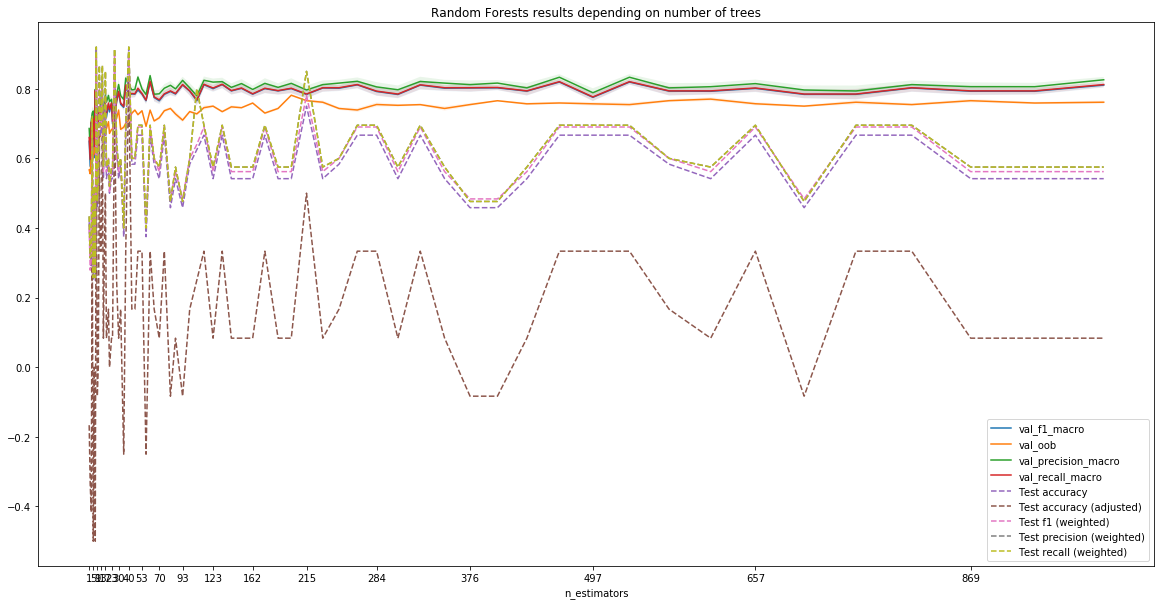

In [20]:
df = pd.DataFrame(scores, columns=pd.DataFrame(result).columns)
dferr = pd.DataFrame(errs, columns=pd.DataFrame(result).columns)
df = df.drop(['fit_time', 'score_time'], axis=1)
dferr = dferr.drop(['fit_time', 'score_time'], axis=1)
plt.figure(figsize=(20,10))
plt.hlines(y=df['test_oob'][400:].mean(), xmin=0.0, xmax=1000, color='black')
for key in df.columns:
    plt.plot(n_estimators_range, df[key], label=key.replace('test_', 'val_'))
    plt.fill_between(n_estimators_range, 
                     df[key]+(dferr[key]/np.sqrt(len(dferr))), 
                     df[key]-(dferr[key]/np.sqrt(len(dferr))),
                     alpha=0.1)
plt.plot(n_estimators_range, test_acc, '--', label='Test accuracy')
plt.plot(n_estimators_range, test_acc_adjusted, '--', label='Test accuracy (adjusted)')
plt.plot(n_estimators_range, test_f1, '--', label='Test f1 (weighted)')
plt.plot(n_estimators_range, test_precision, '--', label='Test precision (weighted)')
plt.plot(n_estimators_range, test_recall, '--', label='Test recall (weighted)')
plt.xticks(n_estimators_range[::4], n_estimators_range[::4])
plt.legend()
plt.xlabel('n_estimators')
plt.title('Random Forests results depending on number of trees')
dh = DataHandler('common', 'nb_trees_2_uniform')
dh.save_fig(plt, 'RF_nb_trees_2bins-uniform-smotenc_detailed')

## Classes discretization experiments

In [18]:
test_plan_params_clusters = {
    'classifier': ['gnb'],
    'subject': ['doctor'],
    'prediction_task': ['presence'],
    'phases': ['nophase'],
    'upsampling': ['imb_smotenc'],
    'nbclasses': [2, 3, 4, 5],
    'clstrategy': [None, 'uniform', 'kmeans', 'quantile']
}
#test_plan = list(ParameterGrid(test_plan_params_clusters))
# adding 'original' score discretization ('clstrategy' = None)
#test_plan.append({'phases': 'nophase', 'prediction_task': 'presence', 'upsampling': 'imb_smotenc', 'nbclasses': 3, 'clstrategy': None, 'classifier': 'gnb', 'subject': 'doctor'})

In [19]:

RANDOM_STATE=42
dh_clusters = run_test_plan(test_plan_params_clusters, '_discretization', 'presence_smotenc_NB-G', 2, n_bins=None, bin_strategy=None, n_splits=100, test_set=0.1)

NameError: name 'run_test_plan' is not defined

load_obj: opening C:\IAAA\TER\_output\_discretization\presence_smotenc_RF-0\results\scores.pkl


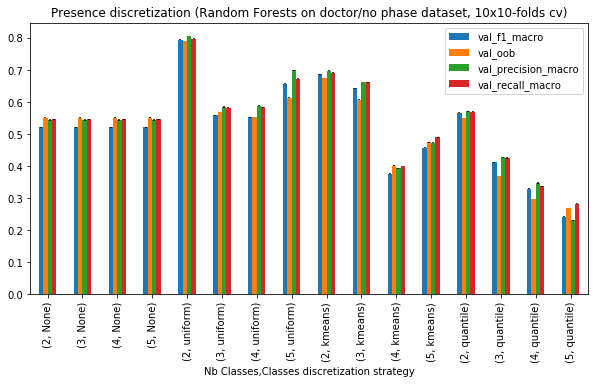

In [20]:
dh_clusters = DataHandler('_discretization', 'presence_smotenc_RF', 0)
scores_df = dh_clusters.load_obj('results', 'scores')
scores_df = scores_df.dropna(axis='rows', how='all')
"""columns = [col for col in scores_df.columns if 'test_' in col and 'class' not in col]

ax = scores_df.loc['Presence', 'Doctor', 'No Phase', 'NB-G', 'imb_smotenc', :, :, 'score'][columns] \
    .plot.bar(figsize=(10,5), yerr=scores_df.loc['Presence', 'Doctor', 'No Phase', 'NB-G', 'imb_smotenc', :, :, 'err'][columns] / 100,
              title='Oversampling strategies on prediction of presence (Naive Bayes (Gaussian) on doctor+agent multimodal dataset, 100 train/test splits, 3 classes)')
plt.savefig(os.path.join(dh_upsampling.root_path, 'oversampling_strategies_NB-G.png'), bbox_inches = "tight")
plt.show()
"""

columns = [col for col in scores_df.columns if 'val_' in col and 'class' not in col and 'fi' not in col]

"""ax = scores_df.loc['Presence', 'Doctor', 'No Phase', 'NB-G', 'imb_smotenc', :, :, 'score'][columns] \
    .plot.bar(figsize=(10,5), yerr=scores_df.loc['Presence', 'Doctor', 'No Phase', 'NB-G', 'imb_smotenc', :, :, 'err'][columns] / 100,
              title='Presence discretization (Naive Bayes (Gaussian) on doctor/no phase dataset, 10x10-folds cv)')
plt.savefig(os.path.join(dh_clusters.root_path, 'discretization_presence_smotenc_NB-G_val.png'), bbox_inches = "tight")
plt.show()

ax = scores_df.loc['Presence', 'Doctor', 'No Phase', 'SVM', 'imb_smotenc', :, :, 'score'][columns] \
    .plot.bar(figsize=(10,5), yerr=scores_df.loc['Presence', 'Doctor', 'No Phase', 'SVM', 'imb_smotenc', :, :, 'err'][columns] / 100,
              title='Presence discretization (SVM on doctor/no phase dataset, 10x10-folds cv)')
plt.savefig(os.path.join(dh_clusters.root_path, 'discretization_presence_smotenc_SVM_val.png'), bbox_inches = "tight")
plt.show()"""

ax = scores_df.loc['Presence', 'Doctor', 'No Phase', 'RF', 'imb_smotenc', :, :, 'score'][columns] \
    .plot.bar(figsize=(10,5), yerr=scores_df.loc['Presence', 'Doctor', 'No Phase', 'RF', 'imb_smotenc', :, :, 'err'][columns] / 100,
              title='Presence discretization (Random Forests on doctor/no phase dataset, 10x10-folds cv)')
plt.savefig(os.path.join(dh_clusters.root_path, 'discretization_presence_smotenc_RF_val.png'), bbox_inches = "tight")
plt.show()

In [21]:
RANDOM_STATE=42
dh_clusterst = run_test_plan(test_plan_params_clusters, '_discretization', 'presence_smotenc_RF_test', 0, n_bins=None, bin_strategy=None, n_splits=100, test_set=0.1)

NameError: name 'run_test_plan' is not defined

load_obj: opening C:\IAAA\TER\_output\_discretization\presence_smotenc_RF_test-0\results\scores.pkl


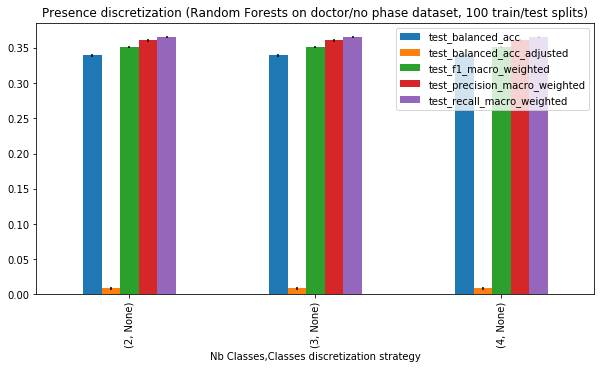

In [22]:
dh_clusterst = DataHandler('_discretization', 'presence_smotenc_RF_test', 0)
scores_df = dh_clusterst.load_obj('results', 'scores')
scores_df = scores_df.dropna(axis='rows', how='all')
"""columns = [col for col in scores_df.columns if 'test_' in col and 'class' not in col]

ax = scores_df.loc['Presence', 'Doctor', 'No Phase', 'NB-G', 'imb_smotenc', :, :, 'score'][columns] \
    .plot.bar(figsize=(10,5), yerr=scores_df.loc['Presence', 'Doctor', 'No Phase', 'NB-G', 'imb_smotenc', :, :, 'err'][columns] / 100,
              title='Oversampling strategies on prediction of presence (Naive Bayes (Gaussian) on doctor+agent multimodal dataset, 100 train/test splits, 3 classes)')
plt.savefig(os.path.join(dh_upsampling.root_path, 'oversampling_strategies_NB-G.png'), bbox_inches = "tight")
plt.show()
"""

columns = [col for col in scores_df.columns if 'test_' in col and 'class' not in col and 'fi' not in col]

"""ax = scores_df.loc['Presence', 'Doctor', 'No Phase', 'NB-G', 'imb_smotenc', :, :, 'score'][columns] \
    .plot.bar(figsize=(10,5), yerr=scores_df.loc['Presence', 'Doctor', 'No Phase', 'NB-G', 'imb_smotenc', :, :, 'err'][columns] / 100,
              title='Presence discretization (Naive Bayes (Gaussian) on doctor/no phase dataset, 100 train/test splits)')
plt.savefig(os.path.join(dh_clusterst.root_path, 'discretization_presence_smotenc_NB-G_test.png'), bbox_inches = "tight")
plt.show()

ax = scores_df.loc['Presence', 'Doctor', 'No Phase', 'SVM', 'imb_smotenc', :, :, 'score'][columns] \
    .plot.bar(figsize=(10,5), yerr=scores_df.loc['Presence', 'Doctor', 'No Phase', 'SVM', 'imb_smotenc', :, :, 'err'][columns] / 100,
              title='Presence discretization (SVM on doctor/no phase dataset, 100 train/test splits)')
plt.savefig(os.path.join(dh_clusterst.root_path, 'discretization_presence_smotenc_SVM_test.png'), bbox_inches = "tight")
plt.show()"""

ax = scores_df.loc['Presence', 'Doctor', 'No Phase', 'RF', 'imb_smotenc', :, :, 'score'][columns] \
    .plot.bar(figsize=(10,5), yerr=scores_df.loc['Presence', 'Doctor', 'No Phase', 'RF', 'imb_smotenc', :, :, 'err'][columns] / 100,
              title='Presence discretization (Random Forests on doctor/no phase dataset, 100 train/test splits)')
plt.savefig(os.path.join(dh_clusterst.root_path, 'discretization_presence_smotenc_RF_test.png'), bbox_inches = "tight")
plt.show()

load_obj: opening C:\IAAA\TER\_output\_discretization\presence_smotenc_NB-G-2\results\scores.pkl


MultiIndex(levels=[[2, 3, 4, 5, u'2', u'3', u'4', u'5'], [u'kmeans', u'quantile', u'uniform']],
           codes=[[4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7], [2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1]],
           names=[u'Nb Classes', u'Classes discretization strategy'])
['2, None', '3, None', '4, None', '5, None', '2, uniform', '3, uniform', '4, uniform', '5, uniform', '2, kmeans', '3, kmeans', '4, kmeans', '5, kmeans', '2, quantile', '3, quantile', '4, quantile', '5, quantile']
Nb Classes  Classes discretization strategy
2           uniform                            0.593750
3           uniform                            0.339500
4           uniform                            0.258958
5           uniform                            0.212667
2           kmeans                             0.552083
3           kmeans                             0.343167
4           kmeans                             0.229167
5           kmeans                             0.242333
2           quantile              

ValueError: shape mismatch: objects cannot be broadcast to a single shape

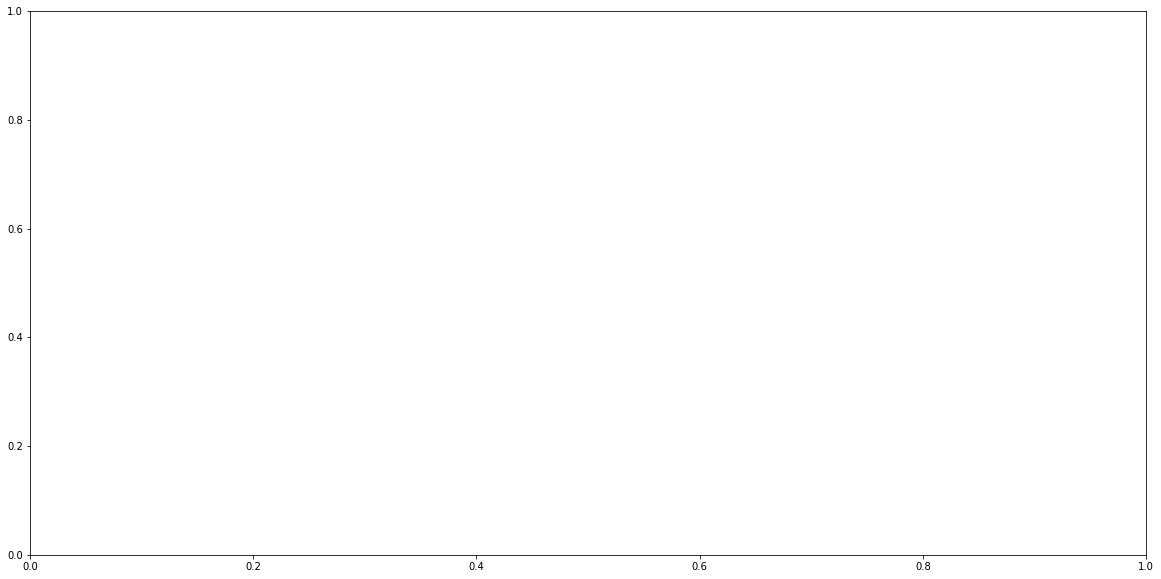

In [23]:
df = pd.DataFrame({"class":['bucket', 'pot', 'tarp', 'trash', 'toy', 'tubing', 'other','bucket', 'pot', 'tarp', 'trash', 'toy', 'tubing', 'other',], 
                   "visability":["visable", "visable","visable","visable","visable","visable","visable", "not visable","not visable","not visable","not visable","not visable","not visable","not visable",],
                   "n1":np.random.random(size=14), 
                   "n2":np.random.random(size=14), 
                   "n3":np.random.random(size=14), 
                   "n4":np.random.random(size=14)})
display(HTML(df.to_html()))
dh_clusterst = DataHandler('_discretization', 'presence_smotenc_NB-G', 2)
df = dh_clusterst.load_obj('results', 'scores')
df = df.dropna(axis='rows', how='all')
df = df.loc['Presence', 'Doctor', 'No Phase', 'NB-G', 'imb_smotenc', :, :, 'score']
columns = [col for col in df.columns if 'test_' in col and 'class' not in col and 'fi' not in col and 'adjusted' not in col]
columns_adj = [col for col in df.columns if 'test_' in col and 'class' not in col and 'fi' not in col and 'adjusted'in col]
display(HTML(df.to_html()))
print(df.index)

#N=7
width = 0.095
w = 0

nbclasses = df.index.levels[0]
strategy = df.index.levels[1]
classes = [ '%d, %s' % (test['nbclasses'], test['clstrategy']) for test in ParameterGrid(test_plan_params_clusters) ]
print(classes)
N = len(classes)
ind = np.arange(N) + .15
neighborhoods = columns
fig, ax = plt.subplots(figsize=(20,10))

top_colors = ['#ff9999', '#9999ff', '#e6b3ff', '#66ff66']
bottom_colors = ['#b30000', '#000066', '#7700b3', '#004d00']

for i, n in enumerate(neighborhoods):
    scores = df[n]
    print(scores)
    print(N)
    print(ind+w)
    rect1 = ax.bar(ind+w, scores, float(width), color=top_colors[i], label=n)
    adjusted_col = '%s_adjusted' % (n)
    if adjusted_col in df.columns:
        print('col adj ' + adjusted_col)
        display(df[adjusted_col])
        scores_adjusted = df[adjusted_col]
        rect2 = ax.bar(ind+w, scores_adjusted, width, color=bottom_colors[i], bottom=scores)
    w += 0.15

extra_space = 0.05
ax.set_xticks(ind+width+extra_space)
ax.set_xticklabels(tuple(classes))

ax.set_title('Visability of container types by class')
plt.legend()
plt.show()

## Experiment: upsampling strategy

In [24]:
test_plan_params_upsampling = {
    'classifier': ['gnb'],
    'subject': ['doctor+agent'],
    'prediction_task': ['presence'],
    'modes': ['multimodal'],
    'upsampling': [None, 'imb_random', 'imb_smote', 'imb_smotenc', 'imb_svmsmote', 'imb_borderlinesmote1', 'imb_borderlinesmote2']
}

In [25]:
RANDOM_STATE=42
dh_upsampling = run_test_plan(test_plan_params_upsampling, 'oversampling_method', 'pres_bins-3-kmeans_repeats-100_clf-GNB', 1, n_bins=3, bin_strategy='kmeans', n_splits=100)

NameError: name 'run_test_plan' is not defined

In [26]:
RANDOM_STATE=42
dh_upsampling = run_test_plan(test_plan_params_upsampling, 'upsampling_strategy', 'bins_3_kmeans_50repeats', 0, n_bins=3, bin_strategy='kmeans', n_splits=100)

NameError: name 'run_test_plan' is not defined

load_obj: opening C:\IAAA\TER\_output\oversampling_method\pres_bins-3-kmeans_repeats-100_clf-GNB-1\results\scores.pkl


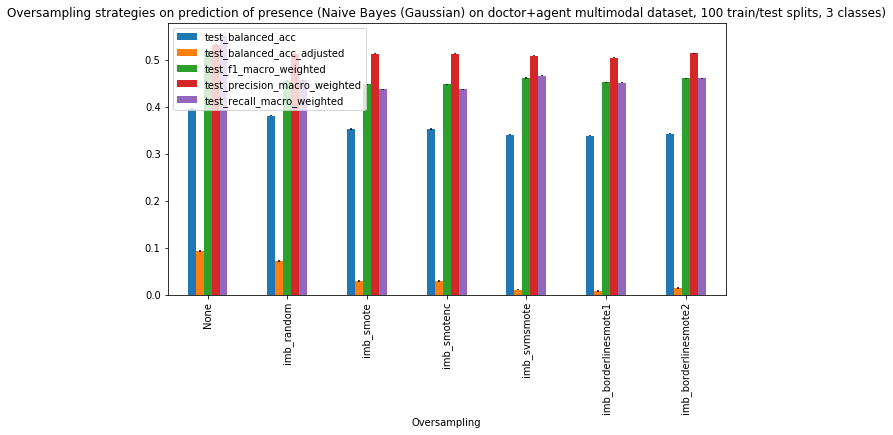

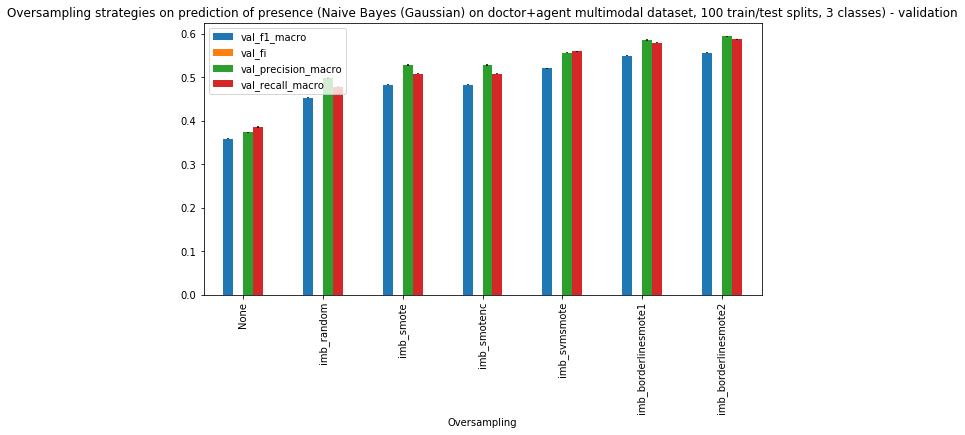

'ax = scores_df.loc[\'Presence\', \'Doctor+Agent\', \'Multimodal\', \'RF\', :, \'score\'][columns]     .plot.bar(figsize=(10,5),\n              title=\'Oversampling strategies on prediction of presence (Random Forests on doctor+agent multimodal dataset)\')\nplt.savefig(os.path.join(dh_upsampling.root_path, \'oversampling_strategies_RF.png\'), bbox_inches = "tight")\nplt.show()\n\nax = scores_df.loc[\'Presence\', \'Doctor+Agent\', \'Multimodal\', \'SVM\', :, \'score\'][columns]     .plot.bar(figsize=(10,5),\n              title=\'Oversampling strategies on prediction of presence (SVM on doctor+agent multimodal dataset, 50 train/test splits)\')\nplt.savefig(os.path.join(dh_upsampling.root_path, \'oversampling_strategies_SVM_50repeats.png\'), bbox_inches = "tight")\nplt.show()'

In [115]:
dh_upsampling = DataHandler('oversampling_method', 'pres_bins-3-kmeans_repeats-100_clf-GNB', 1)
scores_df = dh_upsampling.load_obj('results', 'scores')
scores_df = scores_df.dropna(axis='rows', how='all')
columns = [col for col in scores_df.columns if 'test_' in col and 'class' not in col]

ax = scores_df.loc['Presence', 'Doctor+Agent', 'Multimodal', 'NB-G', :, 'score'][columns] \
    .plot.bar(figsize=(10,5), yerr=scores_df.loc['Presence', 'Doctor+Agent', 'Multimodal', 'NB-G', :, 'err'][columns] / 100,
              title='Oversampling strategies on prediction of presence (Naive Bayes (Gaussian) on doctor+agent multimodal dataset, 100 train/test splits, 3 classes)')
plt.savefig(os.path.join(dh_upsampling.root_path, 'oversampling_strategies_NB-G.png'), bbox_inches = "tight")
plt.show()

columns = [col for col in scores_df.columns if 'val_' in col and 'class' not in col]

ax = scores_df.loc['Presence', 'Doctor+Agent', 'Multimodal', 'NB-G', :, 'score'][columns] \
    .plot.bar(figsize=(10,5), yerr=scores_df.loc['Presence', 'Doctor+Agent', 'Multimodal', 'NB-G', :, 'err'][columns] / 100,
              title='Oversampling strategies on prediction of presence (Naive Bayes (Gaussian) on doctor+agent multimodal dataset, 100 train/test splits, 3 classes) - validation')
plt.savefig(os.path.join(dh_upsampling.root_path, 'oversampling_strategies_NB-G_val.png'), bbox_inches = "tight")
plt.show()

"""ax = scores_df.loc['Presence', 'Doctor+Agent', 'Multimodal', 'RF', :, 'score'][columns] \
    .plot.bar(figsize=(10,5),
              title='Oversampling strategies on prediction of presence (Random Forests on doctor+agent multimodal dataset)')
plt.savefig(os.path.join(dh_upsampling.root_path, 'oversampling_strategies_RF.png'), bbox_inches = "tight")
plt.show()

ax = scores_df.loc['Presence', 'Doctor+Agent', 'Multimodal', 'SVM', :, 'score'][columns] \
    .plot.bar(figsize=(10,5),
              title='Oversampling strategies on prediction of presence (SVM on doctor+agent multimodal dataset, 50 train/test splits)')
plt.savefig(os.path.join(dh_upsampling.root_path, 'oversampling_strategies_SVM_50repeats.png'), bbox_inches = "tight")
plt.show()"""

In [86]:
print(scores_df.columns)

Index([u'fit_time', u'test_balanced_acc', u'test_balanced_acc_adjusted',
       u'test_f1_macro_class_1', u'test_f1_macro_class_2',
       u'test_f1_macro_class_3', u'test_f1_macro_weighted',
       u'test_precision_macro_class_1', u'test_precision_macro_class_2',
       u'test_precision_macro_class_3', u'test_precision_macro_weighted',
       u'test_recall_macro_class_1', u'test_recall_macro_class_2',
       u'test_recall_macro_class_3', u'test_recall_macro_weighted',
       u'val_f1_macro', u'val_f1_macro_class_1', u'val_f1_macro_class_2',
       u'val_f1_macro_class_3', u'val_fi', u'val_precision_macro',
       u'val_precision_macro_class_1', u'val_precision_macro_class_2',
       u'val_precision_macro_class_3', u'val_recall_macro',
       u'val_recall_macro_class_1', u'val_recall_macro_class_2',
       u'val_recall_macro_class_3'],
      dtype='object')


load_obj: opening C:\IAAA\TER\_output\upsampling_strategy\bins_3_kmeans_50repeats-0\results\scores.pkl


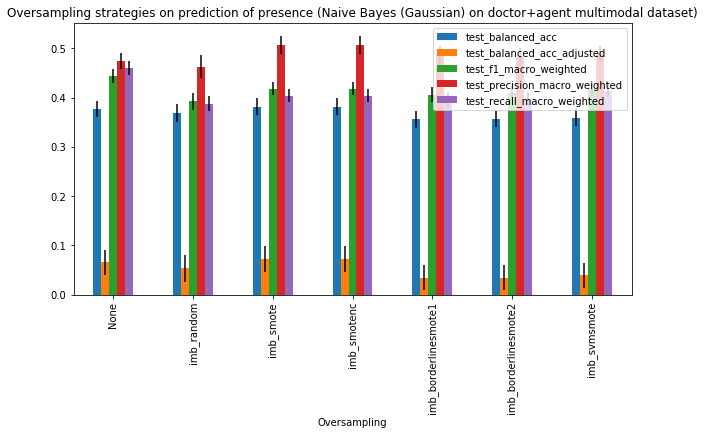

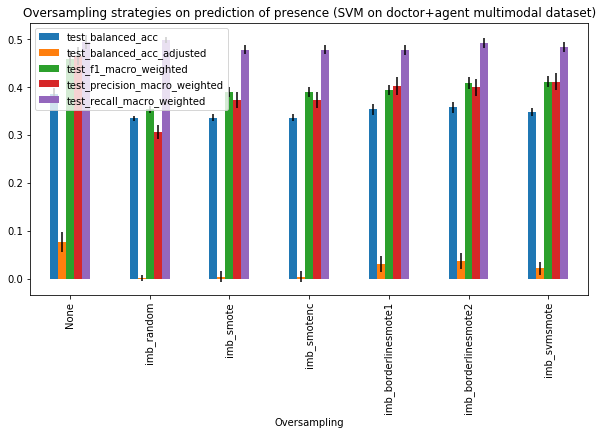

In [28]:
dh_upsampling = DataHandler('upsampling_strategy', 'bins_3_kmeans_50repeats', 0)
scores_df = dh_upsampling.load_obj('results', 'scores')
scores_df = scores_df.dropna(axis='rows', how='all')
columns = [col for col in scores_df.columns if 'test_' in col and 'class' not in col]

ax = scores_df.loc['Presence', 'Doctor+Agent', 'Multimodal', 'NB-G', :, 'score'][columns] \
    .plot.bar(figsize=(10,5), yerr=scores_df.loc['Presence', 'Doctor+Agent', 'Multimodal', 'NB-G', :, 'err'] / 10,
              title='Oversampling strategies on prediction of presence (Naive Bayes (Gaussian) on doctor+agent multimodal dataset)')
plt.savefig(os.path.join(dh_upsampling.root_path, 'oversampling_strategies_NB-G.png'), bbox_inches = "tight")
plt.show()

"""ax = scores_df.loc['Presence', 'Doctor+Agent', 'Multimodal', 'RF', :, 'score'][columns] \
    .plot.bar(figsize=(10,5),
              title='Oversampling strategies on prediction of presence (Random Forests on doctor+agent multimodal dataset)')
plt.savefig(os.path.join(dh_upsampling.root_path, 'oversampling_strategies_RF.png'), bbox_inches = "tight")
plt.show()"""

ax = scores_df.loc['Presence', 'Doctor+Agent', 'Multimodal', 'SVM', :, 'score'][columns] \
    .plot.bar(figsize=(10,5), yerr=scores_df.loc['Presence', 'Doctor+Agent', 'Multimodal', 'SVM', :, 'err'] / 10,
              title='Oversampling strategies on prediction of presence (SVM on doctor+agent multimodal dataset)')
plt.savefig(os.path.join(dh_upsampling.root_path, 'oversampling_strategies_SVM.png'), bbox_inches = "tight")
plt.show()

## Regression

In [ ]:
test_plan_params_upsampling = {
    'classifier': ['r-forest'],
    'subject': ['doctor+agent'],
    'prediction_task': ['presence'],
    'modes': ['multimodal'],
    'upsampling': [None]
}

RANDOM_STATE=42
dh_upsampling = run_test_plan(test_plan_params_upsampling, 'regression', 'upsampling_strategy', 0, n_bins=0, bin_strategy='kmeans', n_splits=1)

In [92]:
from itertools import combinations

data = np.arange(1,100)
data_y = np.random.choice(np.arange(1, 4), size=len(data), p=[0.1, 0.4, 0.5])
print(data_y)
print(np.unique(data_y, return_counts=True))

[3 3 2 3 2 1 2 1 3 2 3 3 2 2 3 2 1 2 2 3 3 3 3 3 2 3 3 3 3 2 2 2 2 3 3 1 3
 2 2 2 2 3 2 3 3 2 3 3 2 2 2 2 1 3 3 1 2 3 2 2 2 3 2 3 3 2 3 2 3 3 3 1 3 2
 2 1 3 3 1 3 2 3 2 3 2 3 2 2 2 3 3 2 3 3 3 3 2 1 3]
(array([1, 2, 3]), array([10, 41, 48]))


In [121]:
a = np.where(data_y == 1)[0]
b = np.where(data_y == 2)[0]
c = np.where(data_y == 3)[0]
print('a ' + str(a))
print('b ' + str(b))
print('c ' + str(c))

test_ratio = 0.2
test_size = int(len(data) * test_ratio)
train_size = int(len(data) * (1 - test_ratio))
print
print('train %d train %d' % (train_size, test_size))
def get_exhaustive_splits(arr, test_ratio):
    test_arr_size = int(len(arr) * test_ratio)
    print(test_arr_size)
    test_a = list(combinations(arr, test_arr_size))
    test_a = [list(item) for item in test_a]
    train_a = []
    for comb in test_a:
        train_a.append(list(set(arr) - set(comb)))
    splits_arr = zip(train_a, test_a)
    print(splits_arr)
    print(len(splits_arr))
    return splits_arr

get_exhaustive_splits(a, test_ratio)
get_exhaustive_splits(b, test_ratio)
get_exhaustive_splits(c, test_ratio)

a [ 5  7 16 35 52 55 71 75 78 97]
b [ 2  4  6  9 12 13 15 17 18 24 29 30 31 32 37 38 39 40 42 45 48 49 50 51
 56 58 59 60 62 65 67 73 74 80 82 84 86 87 88 91 96]
c [ 0  1  3  8 10 11 14 19 20 21 22 23 25 26 27 28 33 34 36 41 43 44 46 47
 53 54 57 61 63 64 66 68 69 70 72 76 77 79 81 83 85 89 90 92 93 94 95 98]

train 79 train 19
2
[([97, 35, 71, 75, 78, 16, 52, 55], [5, 7]), ([97, 35, 71, 75, 78, 52, 55, 7], [5, 16]), ([97, 71, 75, 78, 16, 52, 55, 7], [5, 35]), ([97, 35, 71, 7, 78, 16, 75, 55], [5, 52]), ([97, 35, 71, 7, 78, 16, 75, 52], [5, 55]), ([97, 35, 7, 75, 78, 16, 52, 55], [5, 71]), ([97, 35, 71, 7, 78, 16, 52, 55], [5, 75]), ([97, 35, 71, 75, 16, 52, 55, 7], [5, 78]), ([35, 71, 75, 78, 16, 52, 55, 7], [5, 97]), ([97, 35, 5, 71, 75, 78, 52, 55], [7, 16]), ([97, 5, 71, 75, 78, 16, 52, 55], [7, 35]), ([97, 35, 5, 71, 75, 78, 16, 55], [7, 52]), ([97, 35, 5, 71, 75, 78, 16, 52], [7, 55]), ([97, 35, 5, 75, 78, 16, 52, 55], [7, 71]), ([97, 35, 5, 71, 78, 16, 52, 55], [7, 75]), ([97, 3

MemoryError: 

## Experiment: Subject and Agent features, phases versus no phase

### Test plan

In [29]:
test_plan_params_phases = {
    'classifier': ['gnb'],
    'subject': ['doctor+agent', 'doctor', 'agent'],
    'prediction_task': ['presence', 'copresence'],
    'phases': ['nophase', '157015']
}

### Run

In [30]:
dh_phases = run_test_plan(test_plan_params_phases, '_new_dataset', 'phase-nophase_2-classes-uniform', 0, n_bins=2, bin_strategy='uniform', n_splits=100, test_set=0.1)

[['Presence', 'Co-Presence'], ['Doctor', 'Agent', 'Doctor+Agent'], ['No Phase', '157015'], ['NB-G'], ['score', 'err']]
load_obj: opening C:\IAAA\TER\_output\_new_dataset\phase-nophase_2-classes-uniform-0\results\scores.pkl
file does not yet exist C:\IAAA\TER\_output\_new_dataset\phase-nophase_2-classes-uniform-0\results\scores.pkl
load_obj: opening C:\IAAA\TER\_output\_new_dataset\phase-nophase_2-classes-uniform-0\.\context.pkl
file does not yet exist C:\IAAA\TER\_output\_new_dataset\phase-nophase_2-classes-uniform-0\.\context.pkl
[['Presence', 'Co-Presence'], ['Doctor', 'Agent', 'Doctor+Agent'], ['No Phase', '157015'], ['NB-G']]
CTX multiindex MultiIndex(levels=[[u'Co-Presence', u'Presence'], [u'Agent', u'Doctor', u'Doctor+Agent'], [u'157015', u'No Phase'], [u'NB-G']],
           codes=[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 2, 2, 1, 1, 0, 0, 2, 2], [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
           names=[u'Target', u'Subject', u'Phase

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.5960624197231338
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


LABELS [0, 1]
   Elapsed 39.8099999428 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'No Phase', 'NB-G')
Test 1 : {'phases': 'nophase', 'classifier': 'gnb', 'prediction_task': 'presence', 'subject': 'doctor'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=presence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: PresenceClass_2_uniform
splits [[array([37, 81,  4, 83, 42, 25, 89,  2, 70, 39, 84, 87, 58, 82, 62, 19, 15,
       65, 78, 17, 51,  3, 79, 94, 68,  7, 36, 85, 76, 71, 57, 92, 72, 24,
        1, 31, 11, 75,  6, 38, 46,  9, 35, 48,  5, 49, 77, 34, 53, 50, 63,
       20, 61, 66, 86, 52, 47, 74, 23, 88, 64, 21, 41, 12, 40,  8, 60, 13,
       69, 16, 44, 27, 26, 59,  0, 33, 22, 30, 91, 43, 54, 90, 10, 55, 95,
     

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6242806300842014
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


LABELS [0, 1]
   Elapsed 38.1849999428 seconds
      updating scores for ('Presence', 'Doctor', 'No Phase', 'NB-G')
Test 2 : {'phases': 'nophase', 'classifier': 'gnb', 'prediction_task': 'presence', 'subject': 'agent'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=presence, features=Index([u'Duration', u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: PresenceClass_2_uniform
splits [[array([37, 81,  4, 83, 42, 25, 89,  2, 70, 39, 84, 87, 58, 82, 62, 19, 15,
       65, 78, 17, 51,  3, 79, 94, 68,  7, 36, 85, 76, 71, 57, 92, 72, 24,
        1, 31, 11, 75,  6, 38, 46,  9, 35, 48,  5, 49, 77, 34, 53, 50, 63,
       20, 61, 66, 86, 52, 47, 74, 23, 88, 64, 21, 41, 12, 40,  8, 60, 13,
       69, 16, 44, 27, 26, 59,  0, 33, 22, 30, 91, 43, 54, 90

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.5654147439861725
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #14
LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #23
LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.4240000248 seconds
      updating scores for ('Presence', 'Agent', 'No Phase', 'NB-G')
Test 3 : {'phases': 'nophase', 'classifier': 'gnb', 'prediction_task': 'copresence', 'subject': 'doctor+agent'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=copresence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration',
       u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: CopresenceClass_2_uniform
splits [[array([ 9,  7, 85, 58, 49, 59, 55, 30,  4, 16, 92, 36,  3,  6, 75,  1, 53,
       15,  5, 60, 41, 27, 57, 52,  0, 40, 67, 74, 73, 37, 26, 50, 35, 79,
       80, 83, 44, 12, 45,  2, 17, 18, 47, 46, 31, 34,  8, 56, 86, 22, 6

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6501241696156951
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


LABELS [0, 1]
   Elapsed 38.856000185 seconds
      updating scores for ('Co-Presence', 'Doctor+Agent', 'No Phase', 'NB-G')
Test 4 : {'phases': 'nophase', 'classifier': 'gnb', 'prediction_task': 'copresence', 'subject': 'doctor'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=copresence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: CopresenceClass_2_uniform
splits [[array([ 9,  7, 85, 58, 49, 59, 55, 30,  4, 16, 92, 36,  3,  6, 75,  1, 53,
       15,  5, 60, 41, 27, 57, 52,  0, 40, 67, 74, 73, 37, 26, 50, 35, 79,
       80, 83, 44, 12, 45,  2, 17, 18, 47, 46, 31, 34,  8, 56, 86, 22, 61,
       14, 62, 38, 91, 54, 33, 68, 70, 28, 77, 84, 29, 32, 69, 72, 48, 93,
       13, 63, 42, 81, 19, 87, 64, 89, 25, 43, 10, 95, 82, 94, 11, 24, 6

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6582678620814213
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


LABELS [0, 1]
   Elapsed 38.864000082 seconds
      updating scores for ('Co-Presence', 'Doctor', 'No Phase', 'NB-G')
Test 5 : {'phases': 'nophase', 'classifier': 'gnb', 'prediction_task': 'copresence', 'subject': 'agent'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=copresence, features=Index([u'Duration', u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: CopresenceClass_2_uniform
splits [[array([ 9,  7, 85, 58, 49, 59, 55, 30,  4, 16, 92, 36,  3,  6, 75,  1, 53,
       15,  5, 60, 41, 27, 57, 52,  0, 40, 67, 74, 73, 37, 26, 50, 35, 79,
       80, 83, 44, 12, 45,  2, 17, 18, 47, 46, 31, 34,  8, 56, 86, 22, 61,
       14, 62, 38, 91, 54, 33, 68, 70, 28, 77, 84, 29, 32, 69, 72, 48, 93,
       13, 63, 42, 81, 19, 87, 64, 89, 25, 43, 10, 95

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6294959278010125
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.4249999523 seconds
      updating scores for ('Co-Presence', 'Agent', 'No Phase', 'NB-G')
Test 6 : {'phases': '157015', 'classifier': 'gnb', 'prediction_task': 'presence', 'subject': 'doctor+agent'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=presence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration', u'Head_Entropy_Start_agent',
       u'Head_Entropy_Mid_agent', u'Head_Entropy_End_agent',
       u'Avg_HandEntropy_Begin_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_HandEntropy_End_agent', u'Avg_SentenceLength_Begin_agent',
       u'Avg_SentenceLength_Mid_agent', u'Avg_SentenceLength_End

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.7102195919160205
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


LABELS [0, 1]
   Elapsed 38.6040000916 seconds
      updating scores for ('Presence', 'Doctor+Agent', '157015', 'NB-G')
Test 7 : {'phases': '157015', 'classifier': 'gnb', 'prediction_task': 'presence', 'subject': 'doctor'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=presence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: PresenceClass_2_uniform
splits [[array([37, 81,  4, 83, 42, 25, 89,  2, 70, 39, 84, 87, 58, 82, 62, 19, 15,
       65, 78, 17, 51,  3, 79, 94, 68,  7, 36, 85, 76, 71, 57, 92,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6586917546738975
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


LABELS [0, 1]
   Elapsed 38.5340001583 seconds
      updating scores for ('Presence', 'Doctor', '157015', 'NB-G')
Test 8 : {'phases': '157015', 'classifier': 'gnb', 'prediction_task': 'presence', 'subject': 'agent'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=presence, features=Index([u'Duration', u'Head_Entropy_Start_agent', u'Head_Entropy_Mid_agent',
       u'Head_Entropy_End_agent', u'Avg_HandEntropy_Begin_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_HandEntropy_End_agent',
       u'Avg_SentenceLength_Begin_agent', u'Avg_SentenceLength_Mid_agent',
       u'Avg_SentenceLength_End_agent', u'Ratio1_Begin_agent',
       u'Ratio1_Mid_agent', u'Ratio1_End_agent', u'Ratio2_Begin_agent',
       u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: PresenceClass_2_uniform
splits [[array([37, 81,  4, 83, 42, 25, 89,  2, 70, 39, 84, 87, 58, 82,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6367030786673643
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.5719997883 seconds
      updating scores for ('Presence', 'Agent', '157015', 'NB-G')
Test 9 : {'phases': '157015', 'classifier': 'gnb', 'prediction_task': 'copresence', 'subject': 'doctor+agent'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=copresence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration', u'Head_Entropy_Start_agent',
       u'Head_Entropy_Mid_agent', u'Head_Entropy_End_agent',
       u'Avg_HandEntropy_Begin_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_HandEntropy_End_agent', u'Avg_SentenceLength_Begin_agent',
       u'Avg_SentenceLength_Mid_agent', u'Avg_SentenceLength_End_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.7666755560823358
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


LABELS [0, 1]
   Elapsed 39.1630001068 seconds
      updating scores for ('Co-Presence', 'Doctor+Agent', '157015', 'NB-G')
Test 10 : {'phases': '157015', 'classifier': 'gnb', 'prediction_task': 'copresence', 'subject': 'doctor'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=copresence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: CopresenceClass_2_uniform
splits [[array([ 9,  7, 85, 58, 49, 59, 55, 30,  4, 16, 92, 36,  3,  6, 75,  1, 53,
       15,  5, 60, 41, 27, 57, 52,  0, 40, 67, 74, 73, 3

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.7727666401395215
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


LABELS [0, 1]
   Elapsed 38.7669999599 seconds
      updating scores for ('Co-Presence', 'Doctor', '157015', 'NB-G')
Test 11 : {'phases': '157015', 'classifier': 'gnb', 'prediction_task': 'copresence', 'subject': 'agent'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=copresence, features=Index([u'Duration', u'Head_Entropy_Start_agent', u'Head_Entropy_Mid_agent',
       u'Head_Entropy_End_agent', u'Avg_HandEntropy_Begin_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_HandEntropy_End_agent',
       u'Avg_SentenceLength_Begin_agent', u'Avg_SentenceLength_Mid_agent',
       u'Avg_SentenceLength_End_agent', u'Ratio1_Begin_agent',
       u'Ratio1_Mid_agent', u'Ratio1_End_agent', u'Ratio2_Begin_agent',
       u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: CopresenceClass_2_uniform
splits [[array([ 9,  7, 85, 58, 49, 59, 55, 30,  4, 16, 92, 3

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.7156271224067835
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99
LABELS [0, 1]
   Elapsed 22.9400000572 seconds
      updating scores for ('Co-Presence', 'Agent', '157015', 'NB-G')


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


load_obj: opening C:\IAAA\TER\_output\_new_dataset\phase-nophase_2-classes-uniform-0\results\scores.pkl


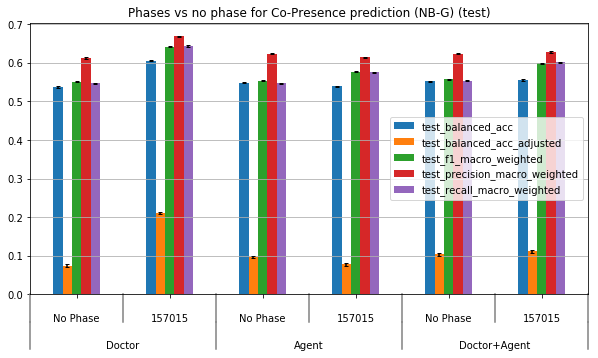

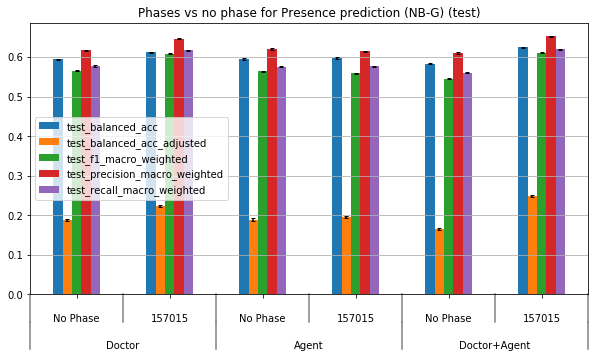

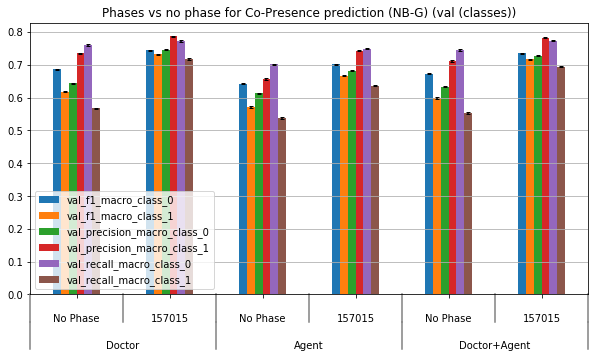

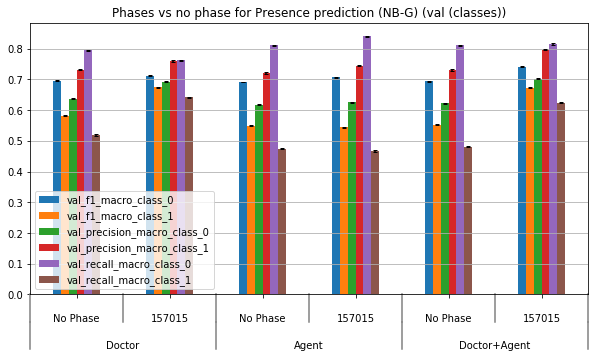

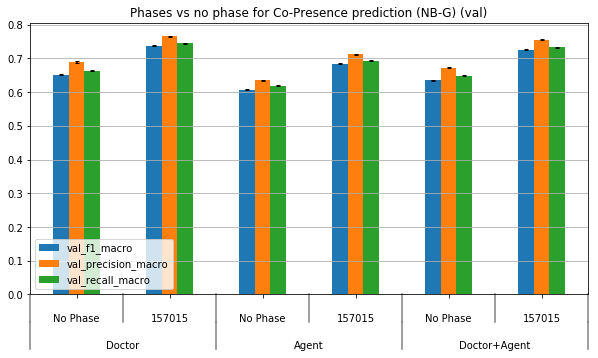

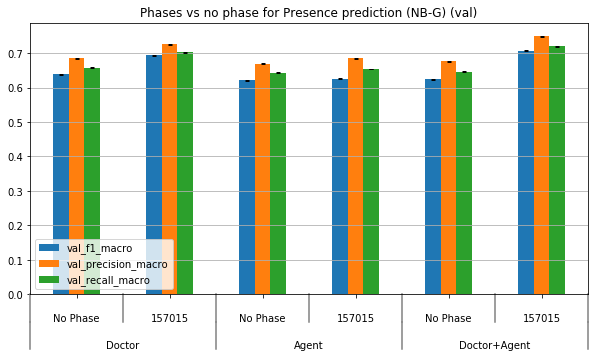

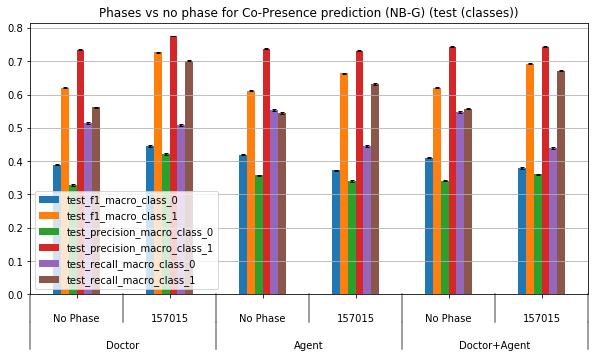

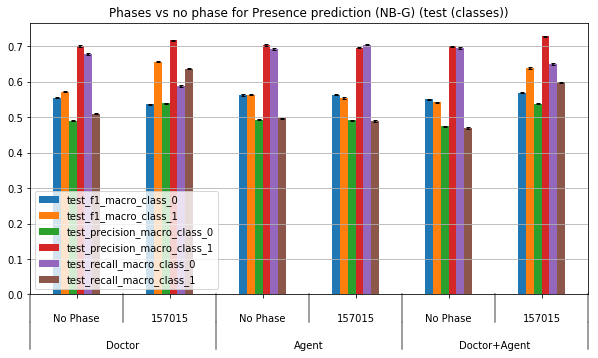

In [35]:
dh_phases = DataHandler('_new_dataset', 'phase-nophase_2-classes-uniform', 0)
scores_df = dh_phases.load_obj('results', 'scores')
scores_df = scores_df.dropna(axis='rows', how='all')
 
plot_results(dh_phases, scores_df, 'Phases vs no phase', 0, 3)

# Verbal, non-verbal, multi-modal and multi-modal + duration

### Test plan definition

In [37]:
test_plan_params_modes = {
    'classifier': [ 'gnb'],
    'subject': ['doctor', 'agent', 'doctor+agent'],
    'prediction_task': ['presence', 'copresence'],
    'modes': ['verbal', 'nonverbal', 'multimodal']
}

### Run

In [38]:
dh_modes = run_test_plan(test_plan_params_modes, '_new_dataset', 'modes_2-classes-uniform', 0, n_bins=2, bin_strategy='uniform', n_splits=100, test_set=0.1)

[['Presence', 'Co-Presence'], ['Doctor', 'Agent', 'Doctor+Agent'], ['Verbal', 'Non-Verbal', 'Multimodal'], ['NB-G'], ['score', 'err']]
load_obj: opening C:\IAAA\TER\_output\_new_dataset\modes_2-classes-uniform-0\results\scores.pkl
file does not yet exist C:\IAAA\TER\_output\_new_dataset\modes_2-classes-uniform-0\results\scores.pkl
load_obj: opening C:\IAAA\TER\_output\_new_dataset\modes_2-classes-uniform-0\.\context.pkl
file does not yet exist C:\IAAA\TER\_output\_new_dataset\modes_2-classes-uniform-0\.\context.pkl
[['Presence', 'Co-Presence'], ['Doctor', 'Agent', 'Doctor+Agent'], ['Verbal', 'Non-Verbal', 'Multimodal'], ['NB-G']]
CTX multiindex MultiIndex(levels=[[u'Co-Presence', u'Presence'], [u'Agent', u'Doctor', u'Doctor+Agent'], [u'Multimodal', u'Non-Verbal', u'Verbal'], [u'NB-G']],
           codes=[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 2, 2, 2, 1, 1, 1, 0, 0, 0, 2, 2, 2], [2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0], [0, 0, 0, 0, 0, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.5686988606631462
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #79
LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.8050000668 seconds
      updating scores for ('Presence', 'Doctor', 'Verbal', 'NB-G')
Test 1 : {'subject': 'agent', 'classifier': 'gnb', 'prediction_task': 'presence', 'modes': 'verbal'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=presence, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: PresenceClass_2_uniform
splits [[array([37, 81,  4, 83, 42, 25, 89,  2, 70, 39, 84, 87, 58, 82, 62, 19, 15,
       65, 78, 17, 51,  3, 79, 94, 68,  7, 36, 85, 76, 71, 57, 92, 72, 24,
        1, 31, 11, 75,  6, 38, 46,  9, 35, 48,  5, 49, 77, 34, 53, 50, 63,
       20, 61, 66, 86, 52, 47, 74, 23, 88, 64, 21, 41, 12, 40,  8, 60, 13,
       69, 16, 44, 27, 26, 59,  0, 33, 22, 30, 91, 43, 54, 90, 10, 55, 95,
       56]), array([73, 67, 18, 14, 93, 29, 32, 28, 45, 80])], [arr

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.481703613846471
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #76
LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.3350000381 seconds
      updating scores for ('Presence', 'Agent', 'Verbal', 'NB-G')
Test 2 : {'subject': 'doctor+agent', 'classifier': 'gnb', 'prediction_task': 'presence', 'modes': 'verbal'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: PresenceClass_2_uniform
splits [[array([37, 81,  4, 83, 42, 25, 89,  2, 70, 39, 84, 87, 58, 82, 62, 19, 15,
       65, 78, 17, 51,  3, 79, 94, 68,  7, 36, 85, 76, 71, 57, 92, 72, 24,
        1, 31, 11, 75,  6, 38, 46,  9, 35, 48,  5, 49, 77, 34, 53, 50, 63,
       20, 61, 66, 86, 52, 47, 74, 23, 88, 64, 21, 41, 12, 40,  8, 60, 13,
       69, 16, 44, 27, 26, 59,  0, 33, 22, 30, 91, 43, 54, 90, 10, 55, 9

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.5227147852147852
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.4590001106 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Verbal', 'NB-G')
Test 3 : {'subject': 'doctor', 'classifier': 'gnb', 'prediction_task': 'copresence', 'modes': 'verbal'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=copresence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: CopresenceClass_2_uniform
splits [[array([ 9,  7, 85, 58, 49, 59, 55, 30,  4, 16, 92, 36,  3,  6, 75,  1, 53,
       15,  5, 60, 41, 27, 57, 52,  0, 40, 67, 74, 73, 37, 26, 50, 35, 79,
       80, 83, 44, 12, 45,  2, 17, 18, 47, 46, 31, 34,  8, 56, 86, 22, 61,
       14, 62, 38, 91, 54, 33, 68, 70, 28, 77, 84, 29, 32, 69, 72, 48, 93,
       13, 63, 42, 81, 19, 87, 64, 89, 25, 43, 10, 95, 82, 94, 11, 24, 65,
       78]), array([21, 88, 71, 51, 20, 76, 39, 66, 90, 23])], [array([60, 88, 55, 82

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6263758840030026
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #5
LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.3250000477 seconds
      updating scores for ('Co-Presence', 'Doctor', 'Verbal', 'NB-G')
Test 4 : {'subject': 'agent', 'classifier': 'gnb', 'prediction_task': 'copresence', 'modes': 'verbal'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=copresence, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: CopresenceClass_2_uniform
splits [[array([ 9,  7, 85, 58, 49, 59, 55, 30,  4, 16, 92, 36,  3,  6, 75,  1, 53,
       15,  5, 60, 41, 27, 57, 52,  0, 40, 67, 74, 73, 37, 26, 50, 35, 79,
       80, 83, 44, 12, 45,  2, 17, 18, 47, 46, 31, 34,  8, 56, 86, 22, 61,
       14, 62, 38, 91, 54, 33, 68, 70, 28, 77, 84, 29, 32, 69, 72, 48, 93,
       13, 63, 42, 81, 19, 87, 64, 89, 25, 43, 10, 95, 82, 94, 11, 24, 65,
       78]), array([21, 88, 71, 51, 20, 76, 39, 66, 90, 23

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


  Gridsearch evaluated best score 0.540868453580318
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.4570000172 seconds
      updating scores for ('Co-Presence', 'Agent', 'Verbal', 'NB-G')
Test 5 : {'subject': 'doctor+agent', 'classifier': 'gnb', 'prediction_task': 'copresence', 'modes': 'verbal'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=copresence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: CopresenceClass_2_uniform
splits [[array([ 9,  7, 85, 58, 49, 59, 55, 30,  4, 16, 92, 36,  3,  6, 75,  1, 53,
       15,  5, 60, 41, 27, 57, 52,  0, 40, 67, 74, 73, 37, 26, 50, 35, 79,
       80, 83, 44, 12, 45,  2, 17, 18, 47, 46, 31, 34,  8, 56, 86, 22, 61,
       14, 62, 38, 91, 54, 33, 68, 70, 28, 77, 84, 29, 32, 69, 72, 48, 93,
       13, 63, 42, 81, 19, 87, 64, 89, 25, 43, 10, 95, 82, 94, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6129590748234817
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}
LABELS [0, 1]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.489000082 seconds
      updating scores for ('Co-Presence', 'Doctor+Agent', 'Verbal', 'NB-G')
Test 6 : {'subject': 'doctor', 'classifier': 'gnb', 'prediction_task': 'presence', 'modes': 'nonverbal'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: PresenceClass_2_uniform
splits [[array([37, 81,  4, 83, 42, 25, 89,  2, 70, 39, 84, 87, 58, 82, 62, 19, 15,
       65, 78, 17, 51,  3, 79, 94, 68,  7, 36, 85, 76, 71, 57, 92, 72, 24,
        1, 31, 11, 75,  6, 38, 46,  9, 35, 48,  5, 49, 77, 34, 53, 50, 63,
       20, 61, 66, 86, 52, 47, 74, 23, 88, 64, 21, 41, 12, 40,  8, 60, 13,
       69, 16, 44, 27, 26, 59,  0, 33, 22, 30, 91, 43, 54, 90, 10, 55, 95,
       56]), array([73, 67, 18, 14, 93, 29, 32, 28, 45, 80])], [array([52, 53, 70, 62, 89, 71,  0,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6018338804053089
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #90
LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.4289999008 seconds
      updating scores for ('Presence', 'Doctor', 'Non-Verbal', 'NB-G')
Test 7 : {'subject': 'agent', 'classifier': 'gnb', 'prediction_task': 'presence', 'modes': 'nonverbal'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: PresenceClass_2_uniform
splits [[array([37, 81,  4, 83, 42, 25, 89,  2, 70, 39, 84, 87, 58, 82, 62, 19, 15,
       65, 78, 17, 51,  3, 79, 94, 68,  7, 36, 85, 76, 71, 57, 92, 72, 24,
        1, 31, 11, 75,  6, 38, 46,  9, 35, 48,  5, 49, 77, 34, 53, 50, 63,
       20, 61, 66, 86, 52, 47, 74, 23, 88, 64, 21, 41, 12, 40,  8, 60, 13,
       69, 16, 44, 27, 26, 59,  0, 33, 22, 30, 91, 43, 54, 90, 10, 55, 95,
       56]), array([73, 67, 18, 14, 93, 29, 32, 28, 45, 80])], [array([52, 53, 70, 62, 89, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6018338804053089
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.4480001926 seconds
      updating scores for ('Presence', 'Agent', 'Non-Verbal', 'NB-G')
Test 8 : {'subject': 'doctor+agent', 'classifier': 'gnb', 'prediction_task': 'presence', 'modes': 'nonverbal'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: PresenceClass_2_uniform
splits [[array([37, 81,  4, 83, 42, 25, 89,  2, 70, 39, 84, 87, 58, 82, 62, 19, 15,
       65, 78, 17, 51,  3, 79, 94, 68,  7, 36, 85, 76, 71, 57, 92, 72, 24,
        1, 31, 11, 75,  6, 38, 46,  9, 35, 48,  5, 49, 77, 34, 53, 50, 63,
       20, 61, 66, 86, 52, 47, 74, 23, 88, 64, 21, 41, 12, 40,  8, 60, 13,
       69, 16, 44, 27, 26, 59,  0, 33, 22, 30, 91, 43, 54, 90, 10, 55, 95,
       56]), array([73, 67,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6018338804053089
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}
LABELS [0, 1]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*** Train/Test Split #1
LABELS [0, 1]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.5009999275 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Non-Verbal', 'NB-G')
Test 9 : {'subject': 'doctor', 'classifier': 'gnb', 'prediction_task': 'copresence', 'modes': 'nonverbal'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: CopresenceClass_2_uniform
splits [[array([ 9,  7, 85, 58, 49, 59, 55, 30,  4, 16, 92, 36,  3,  6, 75,  1, 53,
       15,  5, 60, 41, 27, 57, 52,  0, 40, 67, 74, 73, 37, 26, 50, 35, 79,
       80, 83, 44, 12, 45,  2, 17, 18, 47, 46, 31, 34,  8, 56, 86, 22, 61,
       14, 62, 38, 91, 54, 33, 68, 70, 28, 77, 84, 29, 32, 69, 72, 48, 93,
       13, 63, 42, 81, 19, 87, 64, 89, 25, 43, 10, 95, 82, 94, 11, 24, 65,
       78]), array([21, 88, 71, 51, 20, 76, 39, 66, 90, 23])], [array([60, 88, 55, 82, 73,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.5340732713614069
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #53
LABELS [0, 1]
*** Train/Test Split #54
LABELS [0, 1]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


*** Train/Test Split #55


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #72
LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.5550000668 seconds
      updating scores for ('Co-Presence', 'Doctor', 'Non-Verbal', 'NB-G')
Test 10 : {'subject': 'agent', 'classifier': 'gnb', 'prediction_task': 'copresence', 'modes': 'nonverbal'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=copresence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: CopresenceClass_2_uniform
splits [[array([ 9,  7, 85, 58, 49, 59, 55, 30,  4, 16, 92, 36,  3,  6, 75,  1, 53,
       15,  5, 60, 41, 27, 57, 52,  0, 40, 67, 74, 73, 37, 26, 50, 35, 79,
       80, 83, 44, 12, 45,  2, 17, 18, 47, 46, 31, 34,  8, 56, 86, 22, 61,
       14, 62, 38, 91, 54, 33, 68, 70, 28, 77, 84, 29, 32, 69, 72, 48, 93,
       13, 63, 42, 81, 19, 87, 64, 89, 25, 43, 10, 95, 82, 94, 11, 24, 65,
       78]), array([21, 88, 71, 51, 20, 76, 39, 66, 90, 23])], [array([60, 88, 55

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.5340732713614069
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.5290000439 seconds
      updating scores for ('Co-Presence', 'Agent', 'Non-Verbal', 'NB-G')
Test 11 : {'subject': 'doctor+agent', 'classifier': 'gnb', 'prediction_task': 'copresence', 'modes': 'nonverbal'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: CopresenceClass_2_uniform
splits [[array([ 9,  7, 85, 58, 49, 59, 55, 30,  4, 16, 92, 36,  3,  6, 75,  1, 53,
       15,  5, 60, 41, 27, 57, 52,  0, 40, 67, 74, 73, 37, 26, 50, 35, 79,
       80, 83, 44, 12, 45,  2, 17, 18, 47, 46, 31, 34,  8, 56, 86, 22, 61,
       14, 62, 38, 91, 54, 33, 68, 70, 28, 77, 84, 29, 32, 69, 72, 48, 93,
       13, 63, 42, 81, 19, 87, 64, 89, 25, 43, 10, 95, 82, 94, 11, 24, 65,
       78]), arra

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.5340732713614069
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}
LABELS [0, 1]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 23.1080000401 seconds
      updating scores for ('Co-Presence', 'Doctor+Agent', 'Non-Verbal', 'NB-G')
Test 12 : {'subject': 'doctor', 'classifier': 'gnb', 'prediction_task': 'presence', 'modes': 'multimodal'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: PresenceClass_2_uniform
splits [[array([37, 81,  4, 83, 42, 25, 89,  2, 70, 39, 84, 87, 58, 82, 62, 19, 15,
       65, 78, 17, 51,  3, 79, 94, 68,  7, 36, 85, 76, 71, 57, 92, 72, 24,
        1, 31, 11, 75,  6, 38, 46,  9, 35, 48,  5, 49, 77, 34, 53, 50, 63,
       20, 61, 66, 86, 52, 47, 74, 23, 88, 64, 21, 41, 12, 40,  8, 60, 13,
       69, 16, 44, 27, 26, 59,  0, 33, 22, 30, 91, 43, 54, 90, 10, 55, 95,
       56]), array([7

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6245832686221341
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.7240002155 seconds
      updating scores for ('Presence', 'Doctor', 'Multimodal', 'NB-G')
Test 13 : {'subject': 'agent', 'classifier': 'gnb', 'prediction_task': 'presence', 'modes': 'multimodal'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: PresenceClass_2_uniform
splits [[array([37, 81,  4, 83, 42, 25, 89,  2, 70, 39, 84, 87, 58, 82, 62, 19, 15,
       65, 78, 17, 51,  3, 79, 94, 68,  7, 36, 85, 76, 71, 57, 92, 72, 24,
        1, 31, 11, 75,  6, 38, 46,  9, 35, 48,  5, 49, 77, 34, 53, 50, 63,
       20, 61, 66, 86, 52, 47, 74, 23, 88, 64, 21, 41, 12, 40,  8, 60, 13,
       69, 16, 44, 27, 26, 59,  0, 33, 22, 30, 91, 43, 54, 90, 10, 55

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6010739260739262
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.493999958 seconds
      updating scores for ('Presence', 'Agent', 'Multimodal', 'NB-G')
Test 14 : {'subject': 'doctor+agent', 'classifier': 'gnb', 'prediction_task': 'presence', 'modes': 'multimodal'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: PresenceClass_2_uniform
splits [[array([37, 81,  4, 83, 42, 25, 89,  2, 70, 39, 84, 87, 58, 82, 62, 19, 15,
       65, 78, 17, 51,  3, 79, 94, 68,  7, 36, 85, 76, 71, 57, 92, 72, 24,
        1, 31, 11, 75,  6, 38, 46,  9, 35, 48,  5, 49, 77, 34, 53, 50, 63,
       20, 61, 66, 86, 52, 47,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #88
LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.6800000668 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'NB-G')
Test 15 : {'subject': 'doctor', 'classifier': 'gnb', 'prediction_task': 'copresence', 'modes': 'multimodal'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: CopresenceClass_2_uniform
splits [[array([ 9,  7, 85, 58, 49, 59, 55, 30,  4, 16, 92, 36,  3,  6, 75,  1, 53,
       15,  5, 60, 41, 27, 57, 52,  0, 40, 67, 74, 73, 37, 26, 50, 35, 79,
       80, 83, 44, 12, 45,  2, 17, 18, 47, 46, 31, 34,  8, 56, 86, 22, 61,
       14, 62, 38, 91, 54, 33, 68, 70, 28, 77, 84, 29, 32, 69, 72, 48, 93,
       13, 63, 42, 81, 19, 87, 64, 89, 25, 43, 10, 95, 82, 94, 11, 24, 65,
       78]), array

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6218349447163006
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.6089999676 seconds
      updating scores for ('Co-Presence', 'Doctor', 'Multimodal', 'NB-G')
Test 16 : {'subject': 'agent', 'classifier': 'gnb', 'prediction_task': 'copresence', 'modes': 'multimodal'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=copresence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: CopresenceClass_2_uniform
splits [[array([ 9,  7, 85, 58, 49, 59, 55, 30,  4, 16, 92, 36,  3,  6, 75,  1, 53,
       15,  5, 60, 41, 27, 57, 52,  0, 40, 67, 74, 73, 37, 26, 50, 35, 79,
       80, 83, 44, 12, 45,  2, 17, 18, 47, 46, 31, 34,  8, 56, 86, 22, 61,
       14, 62, 38, 91, 54, 33, 68, 70, 28, 77, 84, 29, 32, 69, 72, 48, 93,
       13, 63, 42, 81, 19, 87, 64, 89, 25, 43, 10, 95, 82, 9

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.49415711407236834
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.4629998207 seconds
      updating scores for ('Co-Presence', 'Agent', 'Multimodal', 'NB-G')
Test 17 : {'subject': 'doctor+agent', 'classifier': 'gnb', 'prediction_task': 'copresence', 'modes': 'multimodal'}
run_gridsearch(bins=2, strategy=uniform)
prepare_train_data: prediction_task=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
class_column: CopresenceClass_2_uniform
splits [[array([ 9,  7, 85, 58, 49, 59, 55, 30,  4, 16, 92, 36,  3,  6, 75,  1, 53,
       15,  5, 60, 41, 27, 57, 52,  0, 40, 67, 74, 73, 37, 26, 50, 35, 79,
       80, 83, 44, 12, 45,  2, 17, 18, 47, 46, 31, 34,  8, 56, 86, 22, 61,
       14, 62, 38, 9

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.616768824395943
  Gridsearch best params : {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #13


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #15


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #16


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #17


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #18


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #19


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #21


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #22


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #23


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #24


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #25


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #26


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #27


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #28


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #29


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #30


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #31


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #32


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #34


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #35


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #36


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #37


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #38


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #39


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #40


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #41


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #42


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #43


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #44


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #45


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #46


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #47


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #48


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #49


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #50


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #51


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #52


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #53


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #55


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #56


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #57


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #58


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #59


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #60


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #61


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #62


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #63


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #65


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #66


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #69
LABELS [0, 1]
*** Train/Test Split #70


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #71


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
*** Train/Test Split #72


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #73


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #74


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #76


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #77


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #78


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #79


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #80


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #81


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #83


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #84


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #85


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #86


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #87


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #88


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #89


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #90


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #91


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #92


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #93


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #94


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #95


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #96


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #97


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #98


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LABELS [0, 1]
*** Train/Test Split #99


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


LABELS [0, 1]
   Elapsed 22.5620000362 seconds
      updating scores for ('Co-Presence', 'Doctor+Agent', 'Multimodal', 'NB-G')


load_obj: opening C:\IAAA\TER\_output\_new_dataset\modes_2-classes-uniform-0\results\scores.pkl


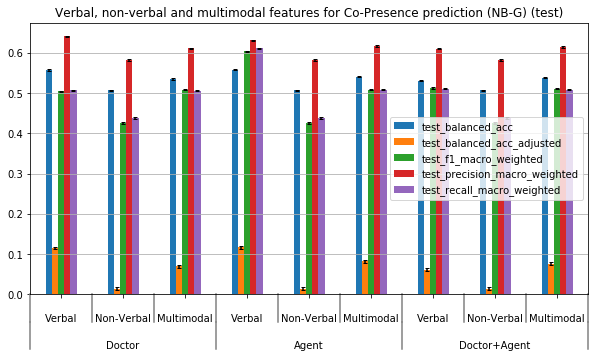

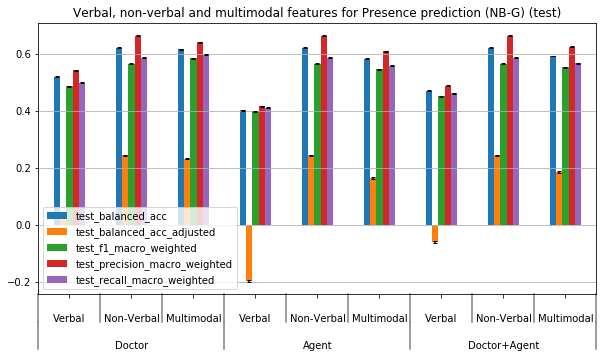

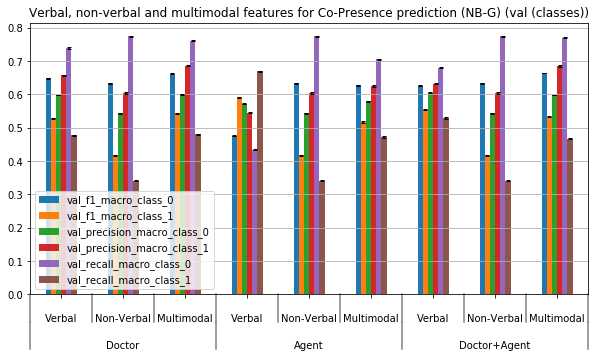

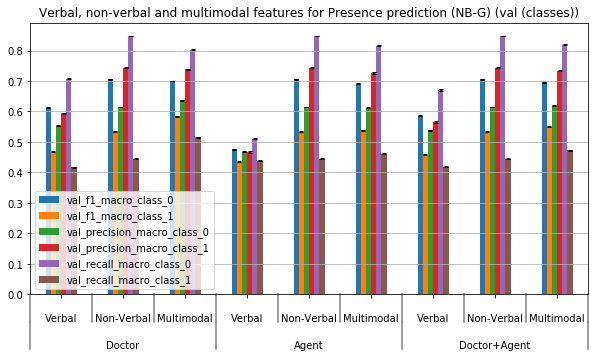

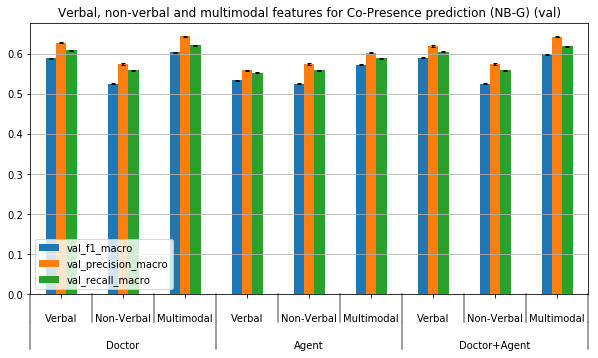

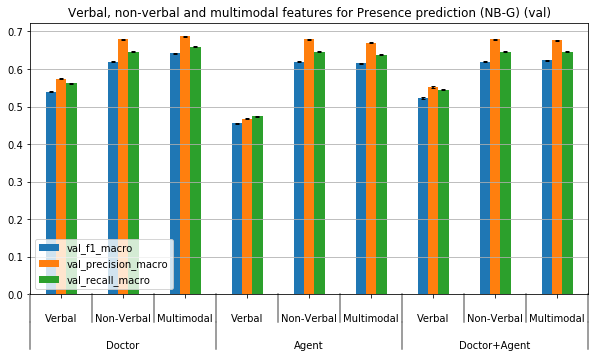

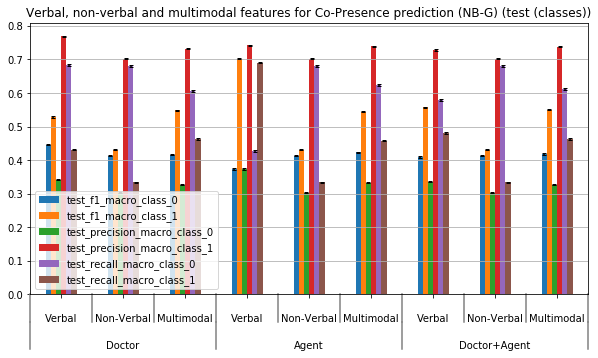

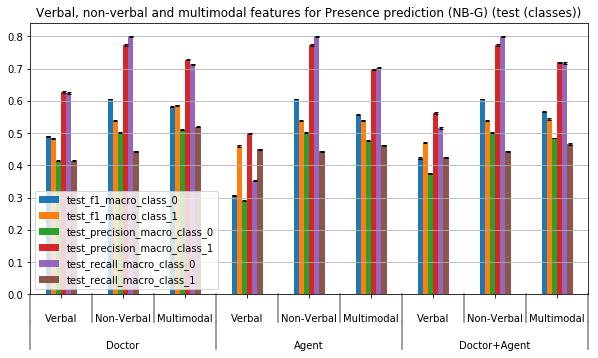

In [39]:
dh_modes = DataHandler('_new_dataset', 'modes_2-classes-uniform', 0)
scores_df = dh_modes.load_obj('results', 'scores')
scores_df = scores_df.dropna(axis='rows', how='all')
 
plot_results(dh_modes, scores_df, 'Verbal, non-verbal and multimodal features', 0, 3)

# Visualizations

## Results

### Modes (verbal, non-verbal ...)

First we reload the results.

In [176]:
# Reload results
dh = DataHandler('2-verbal-nonverbal-multimodal-duration', 2)
scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['Verbal', 'Non-Verbal', 'Multimodal', 'Multimodal+Duration'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Metric', 'Subject', 'Mode', 'Classifier', 'Metric'])
scores_df = dh.load_obj('results', 'scores')
if scores_df is None:
    print("No results to load !")

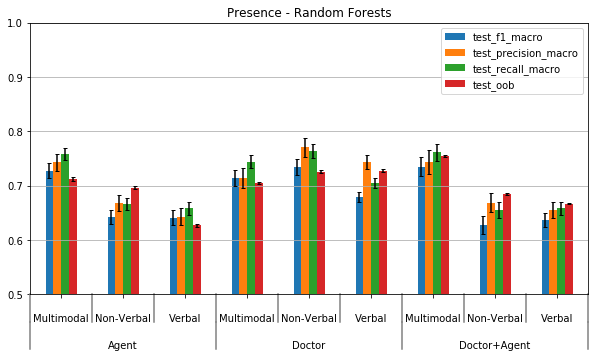

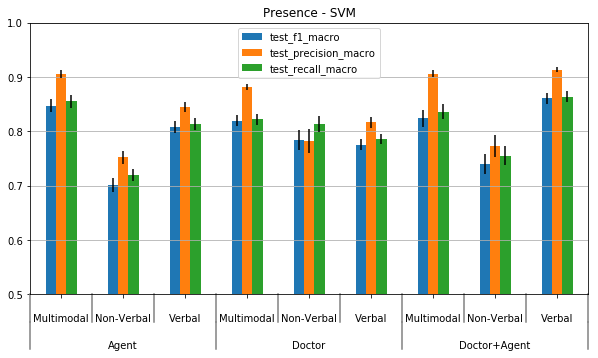

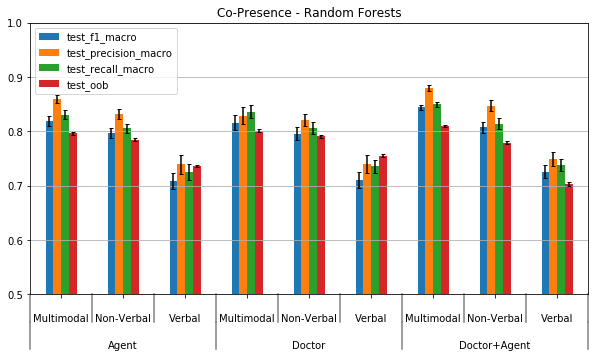

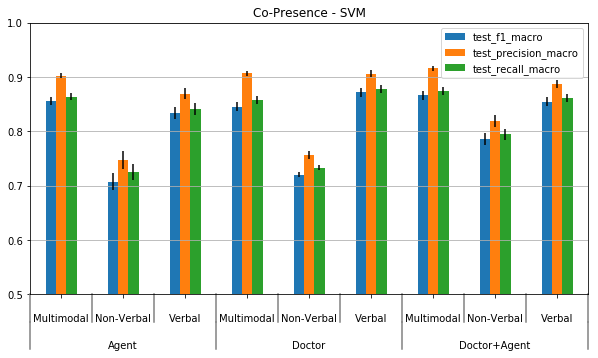

In [177]:
# RF - presence
        
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()
mydf = rear.loc['score', 'Random Forests', 'Presence', :, ['Verbal', 'Non-Verbal', 'Multimodal']]

mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1,
#                   axis='index')
ax = mydf.plot(kind='bar',yerr=rear.loc['err', 'Random Forests', 'Presence'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Presence - Random Forests',
              capsize=2)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_presence_rf.png'), bbox_inches = "tight")
plt.show()

# SVM - presence

mydf = rear.loc['score', 'SVM', 'Presence', :, ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Presence'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_presence_svm.png'), bbox_inches = "tight")
plt.show()


# RF - CO-Presence

mydf = rear.loc['score', 'Random Forests', 'Co-Presence', :, ['Verbal', 'Non-Verbal', 'Multimodal']]

mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1,
#                   axis='index')
ax = mydf.plot(kind='bar',yerr=rear.loc['err', 'Random Forests', 'Co-Presence'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - Random Forests',
              capsize=2)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_rf.png'), bbox_inches = "tight")
plt.show()

# SVM - CO-presence

mydf = rear.loc['score', 'SVM', 'Co-Presence', :, ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Co-Presence'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_svm.png'), bbox_inches = "tight")
plt.show()


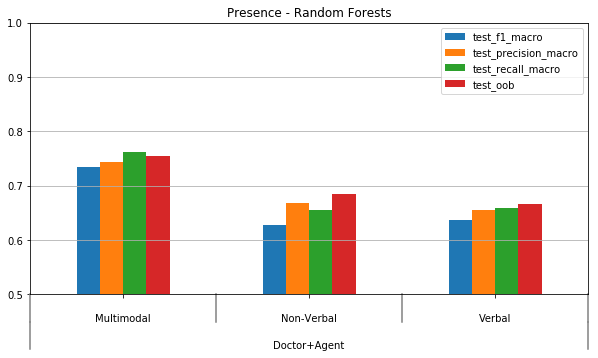

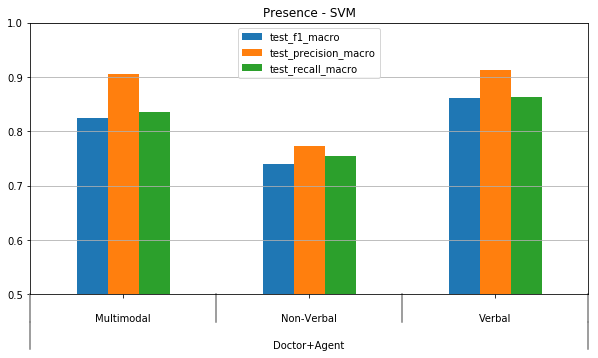

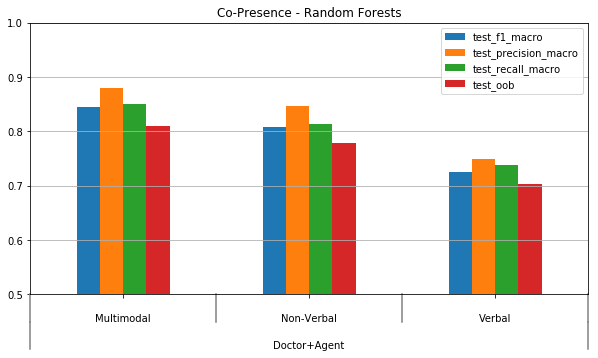

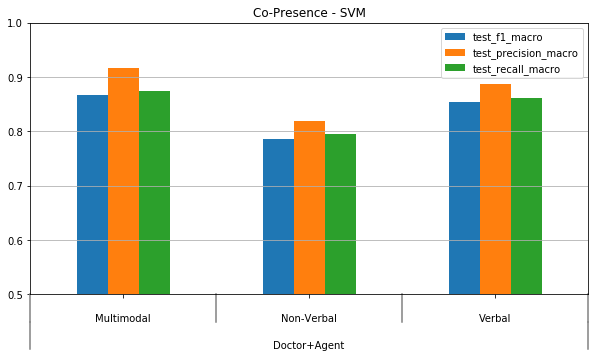

In [178]:
# RF - presence
        
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()
mydf = rear.loc['score', 'Random Forests', 'Presence', 'Doctor+Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]

mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1,
#                   axis='index')
ax = mydf.plot(kind='bar',yerr=rear.loc['err', 'Random Forests', 'Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Presence - Random Forests',
              capsize=2)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_presence_rf_docagent.png'), bbox_inches = "tight")
plt.show()

# SVM - presence

mydf = rear.loc['score', 'SVM', 'Presence', 'Doctor+Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_presence_svm_docagent.png'), bbox_inches = "tight")
plt.show()


# RF - CO-Presence

mydf = rear.loc['score', 'Random Forests', 'Co-Presence', 'Doctor+Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]

mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1,
#                   axis='index')
ax = mydf.plot(kind='bar',yerr=rear.loc['err', 'Random Forests', 'Co-Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - Random Forests',
              capsize=2)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_rf_docagent.png'), bbox_inches = "tight")
plt.show()

# SVM - CO-presence

mydf = rear.loc['score', 'SVM', 'Co-Presence', 'Doctor+Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Co-Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_svm_docagent.png'), bbox_inches = "tight")
plt.show()

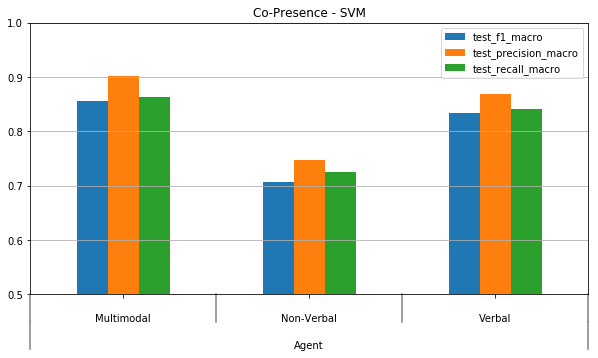

In [179]:
# RF - presence
        
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()
mydf = rear.loc['score', 'Random Forests', 'Presence', 'Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]


# SVM - CO-presence - Agent

mydf = rear.loc['score', 'SVM', 'Co-Presence', 'Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Co-Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_svm_agent.png'), bbox_inches = "tight")
plt.show()

## Phases vs no phase

In [37]:
# Graphs for SVM phases vs no phase, Presence and Co-Presence

dh = DataHandler('1-subject-agent_phases-nophase_imb-random', 1)
scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['No Phase', '157015'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_columns = ['precision', 'f1', 'recall', 'params']
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Metric', 'Subject', 'Phases', 'Classifier', 'Metric'])
scores_df = dh.load_obj('results', 'scores')
if scores_df is None:
    print("No data to load, nothing to draw")
    
scores_df

test_f1_macro  \
Target      Subject      Phases   Classifier     Metric                  
Presence    Doctor       No Phase Random Forests score        0.527435   
                                                 err          0.139692   
                                  SVM            score        0.680211   
                                                 err          0.119242   
                         157015   Random Forests score        0.724507   
                                                 err          0.123291   
                                  SVM            score        0.714163   
                                                 err          0.127807   
            Agent        No Phase Random Forests score        0.558518   
                                                 err          0.099202   
                                  SVM            score        0.643868   
                                                 err          0.136048   
                         157015   Random Forests score        0.633419   
                                                 err          0.122877   
                                  SVM            score        0.746854   
                                                 err          0.087283   
            Doctor+Agent No Phase Random Forests score        0.611910   
                                                 err          0.117109   
                                  SVM            score        0.615946   
                                                 err          0.163411   
                         157015   Random Forests score        0.678592   
                                                 err          0.138833   
                                  SVM            score        0.738095   
                                                 err          0.136869   
Co-Presence Doctor       No Phase Random Forests score        0.620942   
                                                 err          0.116538   
                                  SVM            score        0.650386   
                                                 err          0.086620   
                         157015   Random Forests score        0.601401   
                                                 err          0.108398   
                                  SVM            score        0.742443   
                                                 err          0.100669   
            Agent        No Phase Random Forests score        0.647302   
                                                 err          0.117230   
                                  SVM            score        0.602470   
                                                 err          0.161172   
                         157015   Random Forests score        0.621981   
                                                 err          0.100024   
                                  SVM            score        0.629972   
                                                 err          0.107658   
            Doctor+Agent No Phase Random Forests score        0.708713   
                                                 err          0.113875   
                                  SVM            score        0.689882   
                                                 err          0.135071   
                         157015   Random Forests score        0.619559   
                                                 err          0.131289   
                                  SVM            score        0.678379   
                                                 err          0.090006   

                                                         test_f1_macro_class_1  \
Target      Subject      Phases   Classifier     Metric                          
Presence    Doctor       No Phase Random Forests score                0.732222   
                                                 err                  0.190591   
                            

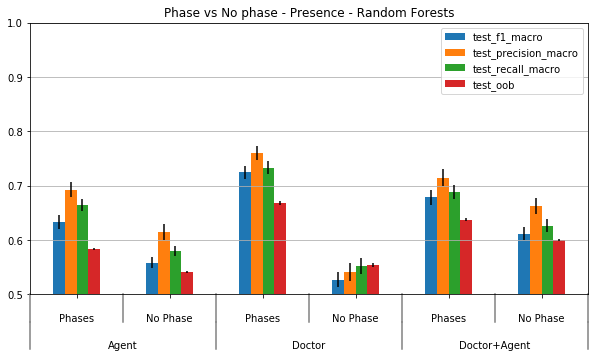

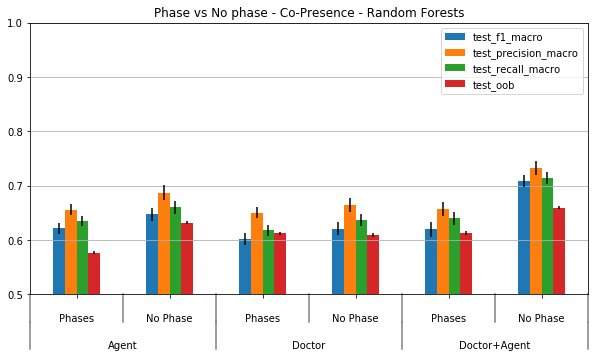

In [38]:
        
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()


# SVM - presence

mydf = rear.loc['score', 'Random Forests', 'Presence']
mydf.index = mydf.index.remove_unused_levels()
#mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
mydf = mydf.rename({'157015': 'Phases'}, 
                   level=1, 
                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'Random Forests', 'Presence'].rename({'157015': 'Phases'}, 
                   level=1, 
                   axis='index') / 10,
               stacked=False, 
               figsize=(10,5),
               title='Phase vs No phase - Presence - Random Forests')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_phases_presence_rf.png'), bbox_inches = "tight")
plt.show()


# SVM - CO-presence

mydf = rear.loc['score', 'Random Forests', 'Co-Presence']
mydf.index = mydf.index.remove_unused_levels()
#mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
mydf = mydf.rename({'157015': 'Phases'}, 
                   level=1, 
                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'Random Forests', 'Co-Presence'].rename({'157015': 'Phases'}, 
                   level=1, 
                   axis='index') / 10,
               stacked=False, 
               figsize=(10,5),
               title='Phase vs No phase - Co-Presence - Random Forests')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_phases_copresence_rf.png'), bbox_inches = "tight")
plt.show()

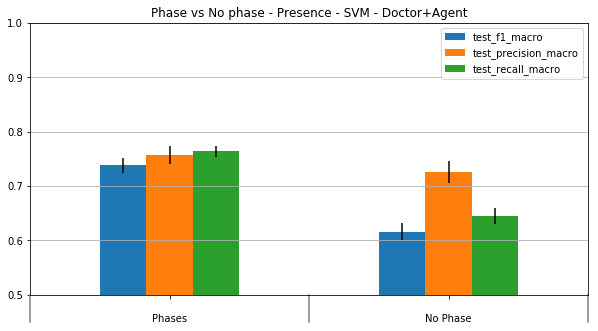

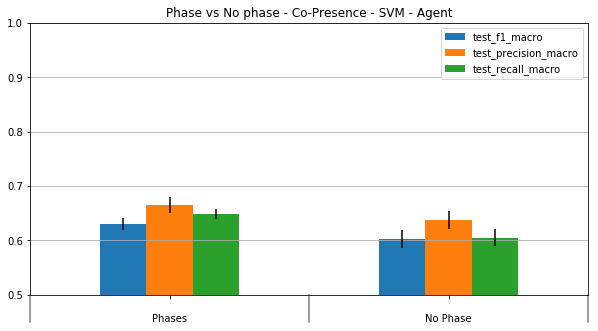

In [39]:
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()


# SVM - presence - doctor + agent

mydf = rear.loc['score', 'SVM', 'Presence', 'Doctor+Agent']
#mydf.index = mydf.index.remove_unused_levels()
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
mydf = mydf.rename({'157015': 'Phases'}, 
                   level=0, 
                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Presence', 'Doctor+Agent'].rename({'157015': 'Phases'}, 
                   level=0, 
                   axis='index') / 10,
               stacked=False, 
               figsize=(10,5),
               title='Phase vs No phase - Presence - SVM - Doctor+Agent')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 1)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_phases_presence_svm_docagent.png'), bbox_inches = "tight")
plt.show()


# SVM - CO-presence

mydf = rear.loc['score', 'SVM', 'Co-Presence', 'Agent']
#mydf.index = mydf.index.remove_unused_levels()
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
mydf = mydf.rename({'157015': 'Phases'}, 
                   level=0, 
                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Co-Presence', 'Agent'].rename({'157015': 'Phases'}, 
                   level=0, 
                   axis='index') / 10,
               stacked=False, 
               figsize=(10,5),
               title='Phase vs No phase - Co-Presence - SVM - Agent')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 1)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_phases_copresence_svm_agent.png'), bbox_inches = "tight")
plt.show()

## Exploring learnt classifiers
### Verbal / non-verbal


In [161]:

# reload best params found

dh = DataHandler('2-verbal-nonverbal-multimodal-duration', 2)
scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['Verbal', 'Non-Verbal', 'Multimodal', 'Multimodal+Duration'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Metric', 'Subject', 'Mode', 'Classifier', 'Metric'])
scores_df = dh.load_obj('results', 'scores')
if scores_df is None:
    print("No results to load !")
 
context_df = pd.read_csv(os.path.join(dh.root_path, 'context.csv'))
if context_df is None:
    print("missing contextual info context.pkl")
    
context_df.index = scores_df_multiindex
context_df


Metric  \
Metric      Subject      Mode                Classifier     Metric                
Presence    Doctor       Verbal              Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Non-Verbal          Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Multimodal          Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Multimodal+Duration Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
            Agent        Verbal              Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Non-Verbal          Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Multimodal          Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Multimodal+Duration Random Forests score      Presence   
                                                            err        Presence   
...                                                                         ...   
Co-Presence Agent        Verbal              SVM            score   Co-Presence   
                                                            err     Co-Presence   
                         Non-Verbal          Random Forests score   Co-Presence   
                                                            err     Co-Presence   
                                             SVM            score   Co-Presence   
                                                            err     Co-Presence   
                         Multimodal          Random Forests score   Co-Presence   
                                                            err     Co-Presence   
                                             SVM            score   Co-Presence   
                                                            err     Co-Presence   
                         Multimodal+Duration Random Forests score   Co-Presence   
                                                            err     Co-Presence   
                                             SVM            score   Co-Presence   
                                                            err     Co-Presence   
            Doctor+Agent Verbal              Random Forests score   Co-Presence   
                                                            err     Co-Presence   
      

In [309]:
print(str([scorer for scorer in sklearn.metrics.SCORERS.keys() if scorer.endswith('loss')]))

['neg_log_loss', 'brier_score_loss']


Test 0 : {'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'forest', 'modes': 'verbal'}
  Computing learning curve for best params : {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1}
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
Test 1 : {'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'forest', 'modes': 'verbal'}
  Computing learning curve for best params : {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1}
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
Test 2 : {'subject': 'doctor', 'target': 'presence', 'classifier': 'forest', 'modes': 'verbal'}
  Computing learning curve for best params : {'max_features': 's

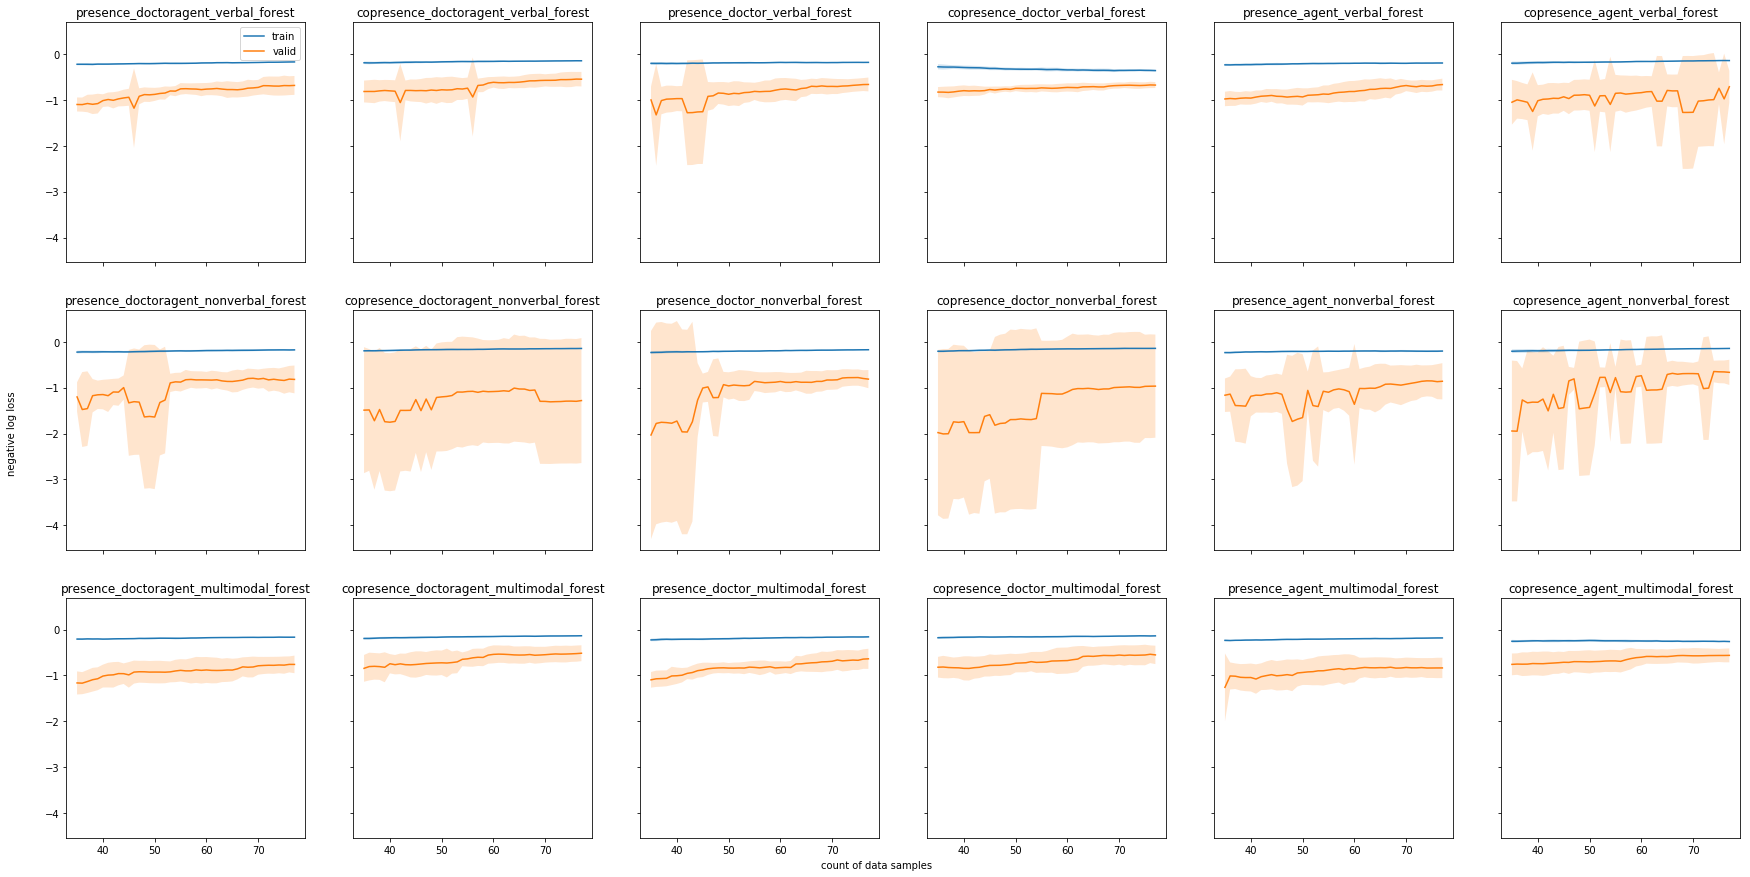

In [162]:
from sklearn.model_selection import learning_curve

test_plan_params = {
    'classifier': ['forest'],
    'subject': ['doctor+agent', 'doctor', 'agent'],
    'target': ['presence', 'copresence'],
    'modes': ['verbal', 'nonverbal', 'multimodal']
}
test_plan = list(ParameterGrid(test_plan_params))

forest = RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True)
svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE, probability=True))

# whether to apply 'original' upsampling method
upsample = True

cols= 6
fig, ax = plt.subplots(int(len(test_plan)/cols), cols, sharex=True, sharey=True, figsize=(30,15))

results = {}

for idx, test in enumerate(test_plan):
    print("Test %d : %s" % (idx, test))
    

    subject = test['subject']
    target = test['target']
    modes = test['modes']
    classifier = test['classifier']
    clf = forest if classifier == 'forest' else svm

    if subject == 'doctor':
        df = subject_np_df
        if modes == 'verbal':
            feats = subject_features_verbal
        elif modes == 'nonverbal':
            feats = subject_features_nonverbal
        elif modes == 'multimodal':
            feats = subject_features_multimodal
        elif modes == 'multimodal+duration':
            feats = subject_features_multimodal_duration
    elif subject == 'agent':
        df = agent_np_df
        if modes == 'verbal':
            feats = agent_features_verbal
        elif modes == 'nonverbal':
            feats = agent_features_nonverbal
        elif modes == 'multimodal':
            feats = agent_features_multimodal
        elif modes == 'multimodal+duration':
            feats = agent_features_multimodal_duration        
    else:
        df = all_np_df
        if modes == 'verbal':
            feats = all_features_verbal
        elif modes == 'nonverbal':
            feats = all_features_nonverbal
        elif modes == 'multimodal':
            feats = all_features_multimodal
        elif modes == 'multimodal+duration':
            feats = all_features_multimodal_duration        
    
    X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample) 
    
    isDoc = 'doctor' in subject
    isAgent = 'agent' in subject
    presidx = 'Presence' if target == 'presence' else 'Co-Presence'
    if subject == 'doctor':
        subjidx = 'Doctor'
    elif subject == 'agent':
        subjidx = 'Agent'
    else:
        subjidx = 'Doctor+Agent'
    if modes == 'verbal':
        phidx = 'Verbal'
    elif modes == 'nonverbal':
        phidx = 'Non-Verbal'
    elif modes == 'multimodal':
        phidx = 'Multimodal'
    elif modes == 'multimodal+duration':
        phidx = 'Multimodal+Duration'
    clfidx = 'Random Forests' if classifier == 'forest' else 'SVM'

    test_set_name = dh.get_grid_name(target=='presence', isDoc, isAgent, modes, classifier)
    
    # create classifier from best params found previously
    best_params = context_df.loc[presidx, subjidx, phidx, clfidx, 'score']['Best Params']
    clf.set_params(**eval(best_params))
    print("  Computing learning curve for best params : %s" % str(best_params))

    train_sizes = np.arange(35, len(df))
    print(train_sizes)
    print(np.unique(y, return_counts=True))
    train_sizes, train_scores, test_scores = learning_curve(clf, 
                                                            X, y, 
                                                            train_sizes=train_sizes, 
                                                            cv=10, 
                                                            scoring='neg_log_loss',
                                                            shuffle=True)

    results[test_set_name] = {}
    results[test_set_name]['train'] = train_scores
    results[test_set_name]['test'] = test_scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    cur_ax = ax[int(idx / cols), (idx) % cols]
    cur_ax.plot(train_sizes, train_scores_mean, label='train')
    cur_ax.fill_between(train_sizes, train_scores_mean + train_scores_std,
                    train_scores_mean - train_scores_std, alpha=0.2)

    cur_ax.plot(train_sizes, test_scores_mean, label='valid')
    cur_ax.fill_between(train_sizes, test_scores_mean + test_scores_std,
                    test_scores_mean - test_scores_std, alpha=0.2)
    cur_ax.set_title(test_set_name)
    #cur_ax.xlabel("Count of samples")
    #cur_ax.ylabel("Negative log loss")
    if idx == 0: cur_ax.legend()
fig.text(0.5, 0.1, 'count of data samples', ha='center', va='center')
fig.text(0.1, 0.5, 'negative log loss', ha='center', va='center', rotation='vertical')
dh.save_fig('learning_curves_verbal-nonverbal_forest.png') 
plt.show()

In [163]:
dh.save_obj(results, 'learning_curves', 'forest')

True

For non-verbal case we only have 2 features, we have then a chance to vizualize the classification results for some classifiers.

In [47]:
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA


df = subject_p_df
feats = all_features
target = 'presence'

n_classes = 3
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses

#best_params = context_df.loc['Presence', 'Doctor', 'Non-Verbal', 'Random Forests', 'score']['Best Params']
#forest.set_params(**eval(best_params))
forest = RandomForestClassifier(n_estimators=1)
X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample='imb_smote', test_set=False)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
forest.fit(X_reduced,y)

model = forest
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

# alpha blend the
# decision surfaces of the ensemble of classifiers

# Choose alpha blend level with respect to the number
# of estimators
# that are in use (noting that AdaBoost can use fewer estimators
# than its maximum if it achieves a good enough fit early on)
estimator_alpha = 1.0 / len(model.estimators_)
for idx, tree in enumerate(model.estimators_):
    print idx
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

# Build a coarser grid to plot a set of ensemble classifications
# to show how these are different to what we see in the decision
# surfaces. These points are regularly space and do not have a
# black outline
xx_coarser, yy_coarser = np.meshgrid(
    np.arange(x_min, x_max, plot_step_coarser),
    np.arange(y_min, y_max, plot_step_coarser))
Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                 yy_coarser.ravel()]
                                 ).reshape(xx_coarser.shape)
cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
                        c=Z_points_coarser, cmap=cmap,
                        edgecolors="none")

# Plot the training points, these are clustered together and have a
# black outline
plt.scatter(X[:, 0], X[:, 1], c=y,
            cmap=ListedColormap(['r', 'y', 'b']),
            edgecolor='k', s=20)
plt.xlabel(feats[0])
plt.ylabel(feats[1])
plt.show()

prepare_train_data: Applying SMOTE oversampling to data 96 / Counter({3L: 43, 2L: 35, 1L: 18}) / unique 96
0


MemoryError: 

In [115]:
from sklearn.decomposition import PCA

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, **params)
    
df = all_p_df
feats = get_features_set('Doctor+Agent', '157015')
target = 'copresence'

n_classes = 3
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses

#best_params = context_df.loc['Presence', 'Doctor', 'Non-Verbal', 'SVM', 'score']['Best Params']
#svm.set_params(**eval(best_params))
X, y, X_test, y_test = prepare_train_data(samples=df, features=feats, target_model=target, upsample='imb_smote', test_set=True, verbose=1) 
#svm = SVC(C=0.1, gamma=1, kernel='rbf')
svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE))
param_grid_svm = {
    'svc__kernel': ['linear', 'rbf', 'sigmoid'],
    'svc__C': np.logspace(-2, 1, 4),
    'svc__gamma': np.logspace(-3, 1, 5)
}
grid = gridsearch(svm, 
                  X, y, 
                  'presence', 
                  param_grid=param_grid_svm, 
                  features=feats, 
                  verbose=verbose)
best_params = grid.best_params_
single_best_score = grid.best_score_

print('  Gridsearch evaluated best score %s' % (single_best_score))
print('    Best params %s ...' % (best_params))

prepare_train_data: target_model=copresence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration', u'Head_Entropy_Start_agent',
       u'Head_Entropy_Mid_agent', u'Head_Entropy_End_agent',
       u'Avg_HandEntropy_Begin_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_HandEntropy_End_agent', u'Avg_SentenceLength_Begin_agent',
       u'Avg_SentenceLength_Mid_agent', u'Avg_SentenceLength_End_agent',
       u'Ratio1_Begin_agent', u'Ratio1_Mid_agent', u'Ratio1_End_agent',
       u'Ratio2_Begin_agent', u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversam

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    6.2s finished


  Gridsearch evaluated best score 0.6521419552669553
    Best params {'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__C': 10.0} ...


TRAIN 0.7291666666666666


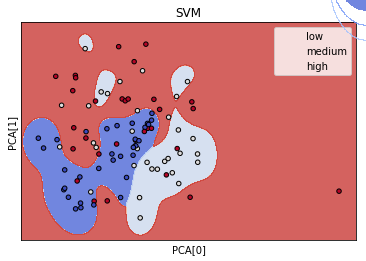

TEST 0.25
balanced accuracy 0 (0)


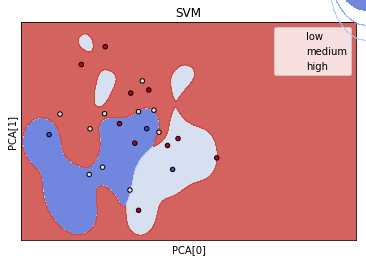

In [118]:
svm = SVC(C=0.1, gamma=1.0, kernel='rbf', random_state=RANDOM_STATE)


scaler = StandardScaler().fit(X)
X_ = scaler.transform(X)
pca = PCA(n_components=2).fit(X_)
X_reduced = pca.transform(X_)
svm.fit(X_reduced,y)
X_test_ = scaler.transform(X_test)
X_test_reduced = pca.transform(X_test_)
y_pred = svm.predict(X_test_reduced)

print('TRAIN ' + str(svm.score(X_reduced, y)))

# Set-up 2x2 grid for plotting.
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X_reduced[:, 0], X_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(svm, xx, yy,
              cmap=plt.cm.coolwarm, alpha=0.8)
sct = plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('PCA[0]')
plt.ylabel('PCA[1]')
plt.xticks(())
plt.yticks(())
plt.legend(['low', 'medium', 'high'])
plt.title('SVM')
plt.show()

print('TEST ' + str(svm.score(X_test_reduced, y_test)))
y_pred = svm.predict(X_test_reduced)
print('balanced accuracy %d (%d)' % (balanced_accuracy_score(y_test, y_pred), balanced_accuracy_score(y_test,y_pred,
                                                                                                      adjusted=True)))

X2, X3 = X_test_reduced[:, 0], X_test_reduced[:, 1]
xx_, yy_ = make_meshgrid(X2, X3)
plot_contours(svm, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
sct = plt.scatter(X2, X3, c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('PCA[0]')
plt.ylabel('PCA[1]')
plt.xticks(())
plt.yticks(())
plt.legend(['low', 'medium', 'high'])
plt.title('SVM')
plt.show()

In [65]:
print(all_p_df.columns)
all_p_df.loc[:, all_features]

Index([u'Candidate', u'Environment', u'Expert', u'Head_Entropy_Start',
       u'Head_Entropy_Mid', u'Head_Entropy_End', u'LeftWrist_Entropy_Start',
       u'LeftWrist_Entropy_Mid', u'LeftWrist_Entropy_End',
       u'RightWrist_Entropy_Start',
       ...
       u'Avg_SentenceLength_End_agent', u'Avg_IPUlen_Begin_agent',
       u'Avg_IPUlen_Middle_agent', u'Avg_IPUlen_End_agent',
       u'Ratio1_Begin_agent', u'Ratio1_Mid_agent', u'Ratio1_End_agent',
       u'Ratio2_Begin_agent', u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object', length=120)


Expert  Head_Entropy_Start  Head_Entropy_Mid  Head_Entropy_End  \
0        0            1.770542          2.765996          2.104357   
1        0            1.040199          2.647328          0.678702   
2        0            1.362497          2.637082          0.769758   
3        0            2.209341          2.992258          1.963007   
4        0            1.961198          3.231085          1.580330   
5        0            1.326662          2.690200          1.128224   
6        0            1.661062          2.855386          1.725241   
7        0            1.378208          3.691843          2.027476   
8        1            1.379823          3.031654          1.986499   
9        1            1.690235          3.447273          1.786774   
10       1            1.878206          3.011313          2.369097   
11       0            1.990006          2.632804          1.507926   
12       0            1.578103          2.818099          1.516759   
13       0            1.208405          2.840889          1.755899   
14       0            1.421695          2.512235          1.215964   
15       1            1.392788          2.917328          1.784952   
16       0            1.545873          2.095857          1.507039   
17       0            2.024160          3.074972          1.666493   
18       0            2.205668          3.200841          1.964720   
19       1            1.623980          2.976929          1.563208   
20       0            0.979124          3.196197          1.359236   
21       1            1.276543          2.872077          1.350792   
22       1            1.910153          3.241893          1.306040   
23       0            2.188167          3.015454          1.586718   
24       0            2.451596          3.394367          2.307885   
25       1            1.498004          3.381121          1.328122   
26       0            1.751946          2.529488          2.031863   
27       0            0.655394          2.551128          0.955392   
28       0            2.089517          3.468680          1.894534   
29       0            1.990573          2.409542          1.845275   
..     ...                 ...               ...               ...   
48       0            1.919272          2.720983          1.447719   
49       0            1.675078          2.902079          1.783700   
50       0            1.894657          3.235629          1.760955   
51       0            1.662336          2.856660          0.928306   
52       0            1.533976          2.614855          0.898953   
53       1            1.534420          4.207910          1.431115   
54       0            1.294436          2.383149          0.473673   
55       0            1.418676          1.909247          1.337212   
56       0            0.698051          3.414939          0.853041   
57       0            1.444610          2.915876          1.371956   
58       0            1.602321          2.833371          1.835899   
59       1            1.623980          0.062355          1.563208   
60       0            2.017806          3.063422          1.881305   
61       0            2.158885          3.161219          1.675367   
62       0            1.625948          2.560776          0.981046   
63       0            1.348172          2.258025          1.228402   
64       1            0.683144          3.232834          2.235459   
65       0            0.622721          3.535678          2.166749   
66       0            1.205576          2.745344          1.128501   
67       0            2.000054          2.574184          1.505569   
68       1            1.490295          3.401611          1.405501   
69       0            1.322853          1.890334          0.871971   
70       0            2.034527          3.074675          2.190054   
71       1            1.321650          2.674797          1.322462   
72       0            1.936003          3.083564          2.061574   
73       0    

In [22]:
from collections import Counter

samples = all_p_df.loc[:, all_features]
print('Original dataset shape %d: %s' % (len(samples), Counter(y)))
print(len(samples))
print(len(np.unique(samples, return_counts=True, axis=0)[1]))
resamples = resample(samples, n_samples=len(all_p_df)+10)
print(len(resamples))
print(len(np.unique(resamples, return_counts=True, axis=0)[1]))


from imblearn.over_sampling import RandomOverSampler

NameError: name 'y' is not defined

### phase / no phase

In [10]:
# Graphs for SVM phases vs no phase, Presence and Co-Presence

dh = DataHandler('1-subject-agent_phases-nophase', 2)
scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['No Phase', '157015'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_columns = ['precision', 'f1', 'recall', 'params']
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Target', 'Subject', 'Phases', 'Classifier', 'Metric'])
scores_df = dh.load_obj('results', 'scores')
if scores_df is None:
    print("No data to load, nothing to draw")

context_df = pd.read_csv(os.path.join(dh.root_path, 'context.csv'))
if context_df is None:
    print("missing contextual info context.pkl")
    
context_df.index = scores_df_multiindex
context_df

ValueError: Length mismatch: Expected axis has 9 elements, new values have 48 elements

Test 0 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor+agent'}
No phase
  Computing learning curve for best params : {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1}
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
Test 1 : {'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor+agent'}
No phase
  Computing learning curve for best params : {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1}
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
Test 2 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor'}
No phase
  Computing learning curve for best

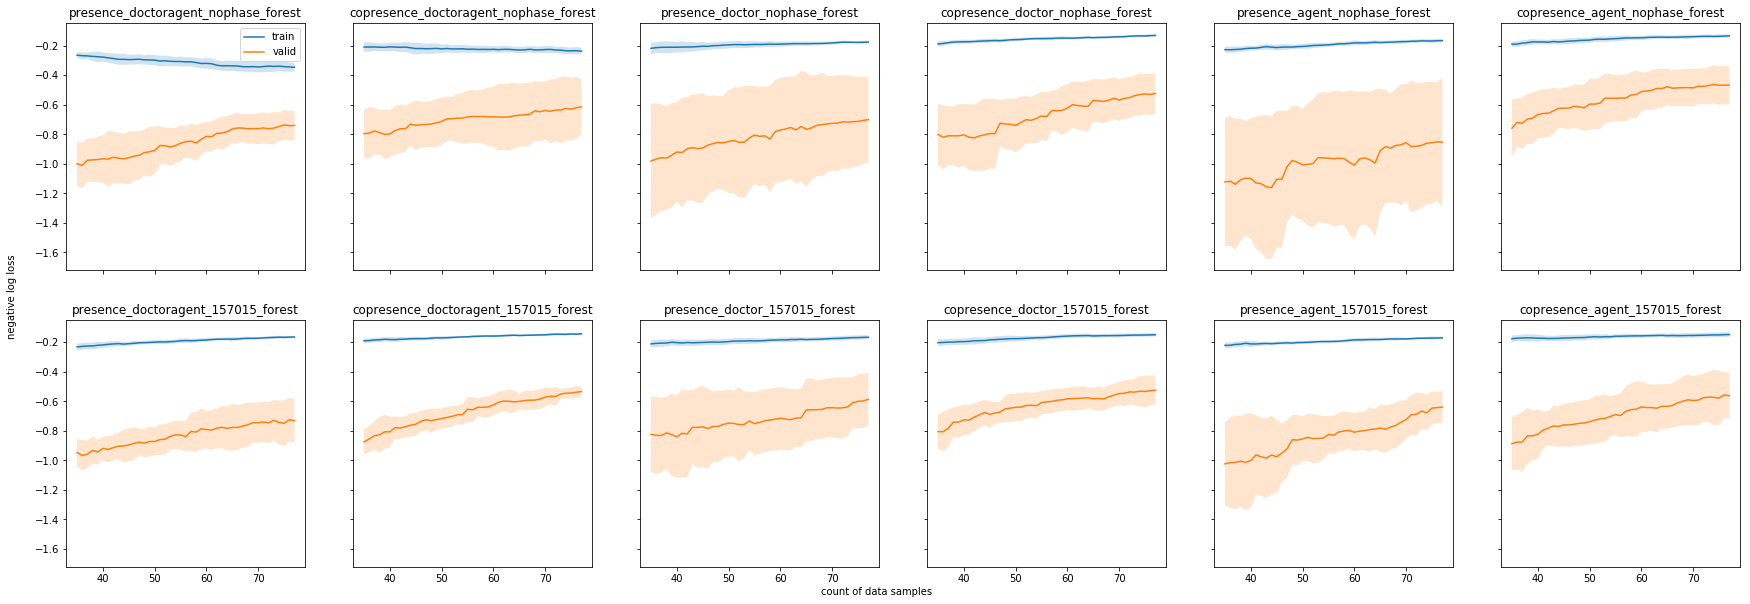

In [172]:
test_plan_params = {
    'classifier': ['forest'],
    'subject': ['doctor+agent', 'doctor', 'agent'],
    'target': ['presence', 'copresence'],
    'phases': [(0,1,0), (0.15,0.70,0.15)]
}
test_plan = list(ParameterGrid(test_plan_params))

forest = RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True)
svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE, probability=True))

# whether to apply 'original' upsampling method
upsample = True

cols= 6
fig, ax = plt.subplots(int(len(test_plan)/cols), cols, sharex=True, sharey=True, figsize=(30,10))

results = {}

for idx, test in enumerate(test_plan):
    print("Test %d : %s" % (idx, test))
    

    subject = test['subject']
    target = test['target']
    phases = test['phases']
    classifier = test['classifier']
    clf = forest if classifier == 'forest' else svm
    pgrid = param_grid_rf if classifier == 'forest' else param_grid_svm

    if phases is not None and not phases == (0,1,0):
        print("phases " + str(phases))
        if subject == 'doctor':
            df = subject_p_df
            feats = subject_features
        elif subject == 'agent':
            df = agent_p_df
            feats = agent_features
        elif subject == 'doctor+agent':
            df = all_p_df
            feats=all_features
    else:
        print("No phase")
        if subject == 'doctor':
            df = subject_np_df
            feats = subject_features_nophase
        elif subject == 'agent':
            df = agent_np_df
            feats = agent_features_nophase
        elif subject == 'doctor+agent':
            df = all_np_df
            feats=all_features_nophase        
    
    X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample) 
    
    isDoc = 'doctor' in subject
    isAgent = 'agent' in subject
    presidx = 'Presence' if target == 'presence' else 'Co-Presence'
    if subject == 'doctor':
        subjidx = 'Doctor'
    elif subject == 'agent':
        subjidx = 'Agent'
    else:
        subjidx = 'Doctor+Agent'
    phidx = 'No Phase' if phases in [None, (0,1,0)] else '%02d%02d%02d' % ( phases[0]*100, phases[1]*100, phases[2]*100 )
    clfidx = 'Random Forests' if classifier == 'forest' else 'SVM'

    test_set_name = dh.get_grid_name(target=='presence', isDoc, isAgent, phases, classifier)
    
    # create classifier from best params found previously
    best_params = context_df.loc[presidx, subjidx, phidx, clfidx, 'score']['Best Params']
    clf.set_params(**eval(best_params))
    print("  Computing learning curve for best params : %s" % str(best_params))

    train_sizes = np.arange(35, len(df))
    print(train_sizes)
    print(np.unique(y, return_counts=True))
    train_sizes, train_scores, test_scores = learning_curve(clf, 
                                                            X, y, 
                                                            train_sizes=train_sizes, 
                                                            cv=10, 
                                                            scoring='neg_log_loss',
                                                            shuffle=True)

    results[test_set_name] = {}
    results[test_set_name]['train'] = train_scores
    results[test_set_name]['test'] = test_scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    cur_ax = ax[int(idx / cols), (idx) % cols]
    cur_ax.plot(train_sizes, train_scores_mean, label='train')
    cur_ax.fill_between(train_sizes, train_scores_mean + train_scores_std,
                    train_scores_mean - train_scores_std, alpha=0.2)

    cur_ax.plot(train_sizes, test_scores_mean, label='valid')
    cur_ax.fill_between(train_sizes, test_scores_mean + test_scores_std,
                    test_scores_mean - test_scores_std, alpha=0.2)
    cur_ax.set_title(test_set_name)
    #cur_ax.xlabel("Count of samples")
    #cur_ax.ylabel("Negative log loss")
    if idx == 0: cur_ax.legend()
fig.text(0.5, 0.09, 'count of data samples', ha='center', va='center')
fig.text(0.1, 0.5, 'negative log loss', ha='center', va='center', rotation='vertical')
dh.save_fig('learning_curves_phase-nophase_forest.png') 
plt.show()

In [174]:
dh.save_obj(results, 'learning_curves', 'forest')

True

In [96]:
plt.show()

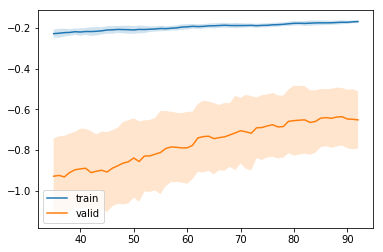

In [313]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label='train')
plt.fill_between(train_sizes, train_scores_mean + train_scores_std,
                train_scores_mean - train_scores_std, alpha=0.2)

plt.plot(train_sizes, test_scores_mean, label='valid')
plt.fill_between(train_sizes, test_scores_mean + test_scores_std,
                test_scores_mean - test_scores_std, alpha=0.2)
plt.legend()
plt.show()

In [304]:
from sklearn.model_selection import validation_curve

train_scores, valid_scores = validation_curve(clf, X, y, "n_estimators",
                                               np.arange(1, 300, 10),
                                               cv=10)

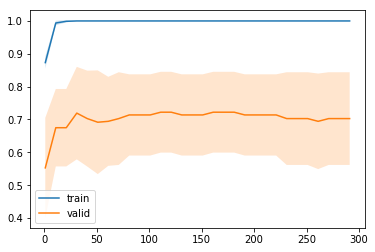

In [306]:
test_scores = valid_scores
x_range = np.arange(1,300,10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(x_range, train_scores_mean, label='train')
plt.fill_between(x_range, train_scores_mean + train_scores_std,
                train_scores_mean - train_scores_std, alpha=0.2)

plt.plot(x_range, test_scores_mean, label='valid')
plt.fill_between(x_range, test_scores_mean + test_scores_std,
                test_scores_mean - test_scores_std, alpha=0.2)
plt.legend()
plt.show()

In [ ]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X=X, y=y, clf=clf, legend=2)
plt.xlabel("x", size=5)
plt.ylabel("y", size=5)
plt.title('SVM Decision Region Boundary', size=6)
plt.show()

## Specific tests on 'Expert' feature

In [42]:
# specific test on expert importance

subject_features = ("Expert", "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

subject_noexpert_features = ("Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

# not using "Expert" feature for agent features
agent_features = ("Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

In [43]:
grid1 = gridsearch(forest, subject_p_df, 'presence', param_grid=param_grid, features=subject_features, upsample=True)
df = pd.DataFrame(grid1.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_1 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val1 = df_best_1.iloc[0]
df_best_1 = pd.DataFrame(df_best_val1.values, columns=['Doctor / Expert'], index=df_best_1.columns).T
df_best_1

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  6.1min finished


ValueError: Shape of passed values is (2, 83), indices imply (1, 83)

In [62]:
grid2 = gridsearch(forest, subject_p_df, 'presence', param_grid=param_grid, features=subject_noexpert_features, upsample=True)
df = pd.DataFrame(grid2.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_ = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val2 = df_best_2.iloc[0]
df_best_2 = pd.DataFrame(df_best_val2.values, columns=['Doctor / No Expert'], index=df_best_2.columns).T
df_best_2

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  5.1min finished


In [63]:
grid3 = gridsearch(forest, agent_p_df, 'presence', param_grid=param_grid, features=agent_features, upsample=True)
df = pd.DataFrame(grid3.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_3 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val3 = df_best_3.iloc[0]
df_best_3 = pd.DataFrame(df_best_val3.values, columns=['Agent / No Expert'], index=df_best_3.columns).T
df_best_3

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  5.0min finished


ValueError: Shape of passed values is (6, 83), indices imply (1, 83)

In [64]:
df = pd.DataFrame(grid3.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_3 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val3 = df_best_3.iloc[0]
df_best_3 = pd.DataFrame(df_best_val3.values, columns=['Agent / No Expert'], index=df_best_3.columns).T
df_best_3

mean_fit_time mean_score_time mean_test_f1_macro  \
Agent / No Expert        0.0141      0.00369997           0.773156   

                  mean_test_precision_macro mean_test_recall_macro  \
Agent / No Expert                  0.831852               0.780952   

                  mean_train_f1_macro mean_train_precision_macro  \
Agent / No Expert            0.997849                   0.997917   

                  mean_train_recall_macro param_class_weight  \
Agent / No Expert                0.997849               None   

                  param_max_features  ... split9_train_precision_macro  \
Agent / No Expert               auto  ...                            1   

                  split9_train_recall_macro std_fit_time std_score_time  \
Agent / No Expert                         1   0.00418211     0.00414847   

                  std_test_f1_macro std_test_precision_macro  \
Agent / No Expert          0.118873                0.0914799   

                  std_test_recall_macro std_train_f1_macro  \
Agent / No Expert               0.11225         0.00430219   

                  std_train_precision_macro std_train_recall_macro  
Agent / No Expert                0.00416667             0.00430108  

[1 rows x 83 columns]

In [65]:
df_best_all = pd.concat([df_best_1, df_best_2, df_best_3])
df_best_all[['mean_test_precision_macro', 'mean_test_f1_macro', 'mean_test_recall_macro', 'params']]

mean_test_precision_macro mean_test_f1_macro  \
Doctor / Expert                     0.814921           0.746969   
Doctor / No Expert                  0.836531           0.793405   
Agent / No Expert                   0.831852           0.773156   

                   mean_test_recall_macro  \
Doctor / Expert                  0.761905   
Doctor / No Expert                    0.8   
Agent / No Expert                0.780952   

                                                               params  
Doctor / Expert     {u'max_features': None, u'n_estimators': 50, u...  
Doctor / No Expert  {u'max_features': None, u'n_estimators': 100, ...  
Agent / No Expert   {u'max_features': u'auto', u'n_estimators': 10...

In [68]:
df = pd.DataFrame(grid1.cv_results_)
cols = [col for col in df.columns if 'std' in col]
df[cols]

std_fit_time  std_score_time  std_test_f1_macro  std_test_precision_macro  \
0       0.002871        0.002256           0.132134                  0.165828   
1       0.003661        0.001814           0.133546                  0.166498   
2       0.034886        0.003231           0.143855                  0.179382   
3       0.007099        0.004826           0.115380                  0.097104   
4       0.005590        0.002193           0.109027                  0.079613   
5       0.008237        0.003716           0.130162                  0.124520   
6       0.035410        0.018779           0.133596                  0.128389   
7       0.003807        0.003873           0.084147                  0.073661   
8       0.008453        0.002764           0.110407                  0.116601   
9       0.009600        0.004331           0.117534                  0.126775   
10      0.004468        0.001908           0.110440                  0.090709   
11      0.005800        0.003807           0.136320                  0.132022   
12      0.009456        0.001911           0.145617                  0.138653   
13      0.028111        0.015740           0.125663                  0.128901   
14      0.004605        0.004069           0.084147                  0.073661   
15      0.004206        0.003382           0.110407                  0.116601   
16      0.004454        0.003208           0.117534                  0.126775   
17      0.006848        0.002579           0.110440                  0.090709   
18      0.004928        0.003002           0.136320                  0.132022   
19      0.013497        0.004792           0.145617                  0.138653   
20      0.062058        0.019393           0.125663                  0.128901   
21      0.004253        0.003499           0.084147                  0.073661   
22      0.005143        0.003905           0.110407                  0.116601   
23      0.003341        0.003429           0.117534                  0.126775   
24      0.005108        0.002655           0.110440                  0.090709   
25      0.005693        0.003066           0.136320                  0.132022   
26      0.008075        0.001900           0.145617                  0.138653   
27      0.057628        0.012464           0.125663                  0.128901   
28      0.002532        0.002586           0.132134                  0.165828   
29      0.002800        0.003555           0.133546                  0.166498   
..           ...             ...                ...                       ...   
54      0.013589        0.003736           0.145617                  0.138653   
55      0.101283        0.016242           0.125663                  0.128901   
56      0.003544        0.003768           0.167014                  0.210353   
57      0.004674        0.003600           0.120550                  0.176845   
58      0.003910        0.005381           0.104046                  0.135741   
59      0.017304        0.005065           0.107917                  0.135997   
60      0.016117        0.004477           0.105020                  0.117366   
61      0.019586        0.004406           0.141573                  0.151115   
62      0.040515        0.028023           0.136354                  0.148026   
63      0.004750        0.002191           0.117917                  0.126316   
64      0.006450        0.003931           0.112843                  0.097814   
65      0.006344        0.003487           0.123512                  0.102862   
66      0.006034        0.002532           0.129254                  0.111541   
67      0.014127        0.002166           0.133994                  0.127645   
68      0.005546        0.002685           0.146913                  0.142563   
69      0.233796        0.029742           0.124730                  0.125555   
70      0.002993        0.002600           0.117917                  0.126316   
71      0.003040        0.002926   

In [249]:
import numpy as np, scipy.stats as st

def confint(a):
    return st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))

a = [1, 1.1, 0.9, 1.15, 0.8, 1.03, 0.99]
print(confint(a))

(0.8866952590268444, 1.1047333124017271)


In [40]:
rdf.index = rdf.index.swaplevel(2,3)
rdf.sort_index(inplace=True)

In [71]:
rdf

precision        f1  \
Classifier     Metric      Phases   Subject                             
Random Forests Co-Presence 157015   Agent          0.857977  0.843006   
                                    Doctor         0.843895  0.775644   
                                    Doctor+Agent   0.891758  0.857478   
                           No Phase Agent          0.916809  0.893617   
                                    Doctor         0.821652  0.798101   
                                    Doctor+Agent   0.868091  0.827934   
               Presence    157015   Agent          0.810794  0.754127   
                                    Doctor         0.778753  0.723586   
                                    Doctor+Agent   0.782381  0.747407   
                           No Phase Agent          0.763946  0.733961   
                                    Doctor         0.816032  0.776039   
                                    Doctor+Agent   0.844444  0.808904   
SVM            Co-Presence 157015   Agent          0.919678  0.882360   
                                    Doctor         0.881481  0.855305   
                                    Doctor+Agent   0.891209  0.858275   
                           No Phase Agent          0.920391  0.870184   
                                    Doctor         0.897212  0.821709   
                                    Doctor+Agent   0.890761  0.862064   
               Presence    157015   Agent          0.883039  0.793964   
                                    Doctor         0.927302  0.892880   
                                    Doctor+Agent   0.913515  0.862339   
                           No Phase Agent          0.818995  0.784713   
                                    Doctor         0.843900  0.801139   
                                    Doctor+Agent   0.898753  0.843911   

                                                    recall  \
Classifier     Metric      Phases   Subject                  
Random Forests Co-Presence 157015   Agent         0.846154   
                                    Doctor        0.794872   
                                    Doctor+Agent  0.863248   
                           No Phase Agent         0.897436   
                                    Doctor        0.803419   
                                    Doctor+Agent  0.837607   
               Presence    157015   Agent         0.771429   
                                    Doctor        0.742857   
                                    Doctor+Agent  0.752381   
                           No Phase Agent         0.742857   
                                    Doctor        0.780952   
                                    Doctor+Agent  0.819048   
SVM            Co-Presence 157015   Agent         0.888889   
                                    Doctor        0.871795   
                                    Doctor+Agent  0.871795   
                           No Phase Agent         0.880342   
                                    Doctor        0.837607   
                                    Doctor+Agent  0.880342   
               Presence    157015   Agent         0.800000   
                                    Doctor        0.895238   
                                    Doctor+Agent  0.866667   
                           No Phase Agent         0.809524   
                                    Doctor        0.809524   
                                    Doctor+Agent  0.847619   

                                                                                             params  
Classifier     Metric      Phases   Subject                                                          
Random Forests Co-Presence 157015   Agent         {'max_features': None, 'n_estimators': 40, 'cl...  
                                    Doctor        {'max_features': None, 'n_estimators': 10, 'cl...  
                                    Doctor+Agent  {'max_features': 'auto', 'n_estimators': 100, ...  
                           N

# Features importance experiments

We would like to check variance and quality of this estimator.
For this we first experiment cross validations with searching also n_estimators, or fixing it with a high value, and check if and how best parameters vary.
Then we will check for a specific set of params, how results and feature importance vary upon repeated runs.
Depending on results, we will compute feature importance for all test plan.

In [211]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import scipy.stats as st


def scoreForest(estimator, X, y):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    We add to this the 
    """
    all_feature_importances.append(estimator.feature_importances_)
    score = estimator.oob_score_
    #print "oob_score_:", score
    return score

def run_cross_val_score(clf, X, y, verbose=1):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    scoring = {
        'oob' : scoreForest,
        'f1_macro' : 'f1_macro',
        'f1_macro_class_1': make_scorer(f1_score, labels=[1], average='macro'),
        'f1_macro_class_2': make_scorer(f1_score, labels=[2], average='macro'),
        'f1_macro_class_3': make_scorer(f1_score, labels=[3], average='macro'),
        'precision_macro' : 'precision_macro',
        'precision_macro_class_1': make_scorer(precision_score, labels=[1], average='macro'),
        'precision_macro_class_2': make_scorer(precision_score, labels=[2], average='macro'),
        'precision_macro_class_3': make_scorer(precision_score, labels=[3], average='macro'),
        'recall_macro' : 'recall_macro',
        'recall_macro_class_1': make_scorer(recall_score, labels=[1], average='macro'),
        'recall_macro_class_2': make_scorer(recall_score, labels=[2], average='macro'),
        'recall_macro_class_3': make_scorer(recall_score, labels=[3], average='macro')           
    }
    
    return cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False, verbose=verbose)



# random forests
param_grid =  {
    'n_estimators' : [300],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    "max_depth": [None, 2, 5, 10],
    "min_samples_leaf": [1, 5, 10]
}

# n : number of repeated runs performed to compute averages and confidence intervals
n = 10

def run_gridsearch_with_feature_importances(dataframe, target_model, features_names, upsample=True):

    scores = []

    X, y = prepare_train_data(subject_np_df, 'presence', subject_features_nophase, upsample=True)

    # first evaluate best params through grid search for this particular test
    grid = gridsearch(forest, 
                      X, y, 
                      'presence', 
                      param_grid=param_grid, 
                      features=subject_features, 
                      upsample=True, 
                      verbose=0)
    best_params = grid.best_params_
    single_best_score = grid.best_score_

    print('  Gridsearch evaluated best score %s' % (single_best_score))
    print('    Running %d iterations on best classifier %s ...' % (n, best_params))

    all_scores = []
    all_feature_importances = []
    all_dropcol_feature_importances = []
    for i in np.arange(n):
        forest = RandomForestClassifier(oob_score=True)
        forest.set_params(**best_params)

        scores = run_cross_val_score(forest, 
                          X, y,  
                          verbose=0)
    #    print(scores)
        scores_df = pd.DataFrame(scores)
        #print(scores_df)
        #print(scores_df.columns)
        all_scores.append(scores_df)

    X_ = pd.DataFrame(X, columns=subject_features_nophase)
    y_ = pd.DataFrame(y)
    for i in np.arange(300):
        # alternative computation for feature importance
        all_dropcol_feature_importances.append(dropcol_importances(forest, X_, y_, RANDOM_STATE+i))

    all_scores = pd.concat(all_scores)
    all_feature_importances = pd.DataFrame(all_feature_importances, columns=subject_features_nophase)
    all_dropcol_features_importances = pd.DataFrame(all_dropcol_feature_importances, columns=subject_features_nophase)

(array([1, 2, 3], dtype=int64), array([37, 37, 37]))
  Gridsearch evaluated best score 0.7525343525343525
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 30, 'max_depth': None, 'min_samples_leaf': 1} ...


In [ ]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import scipy.stats as st


def score_forest(estimator, X, y):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    """
    all_feature_importances.append(estimator.feature_importances_)
    score = estimator.oob_score_
    #print "oob_score_:", score
    return score

def run_cross_val_score(clf, X, y, verbose=1):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    scoring = {
        'oob' : score_forest,
        'f1_macro' : 'f1_macro',
        'f1_macro_class_1': make_scorer(f1_score, labels=[1], average='macro'),
        'f1_macro_class_2': make_scorer(f1_score, labels=[2], average='macro'),
        'f1_macro_class_3': make_scorer(f1_score, labels=[3], average='macro'),
        'precision_macro' : 'precision_macro',
        'precision_macro_class_1': make_scorer(precision_score, labels=[1], average='macro'),
        'precision_macro_class_2': make_scorer(precision_score, labels=[2], average='macro'),
        'precision_macro_class_3': make_scorer(precision_score, labels=[3], average='macro'),
        'recall_macro' : 'recall_macro',
        'recall_macro_class_1': make_scorer(recall_score, labels=[1], average='macro'),
        'recall_macro_class_2': make_scorer(recall_score, labels=[2], average='macro'),
        'recall_macro_class_3': make_scorer(recall_score, labels=[3], average='macro')           
    }
    
    return cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False, verbose=verbose)



# random forests
param_grid =  {
    'n_estimators' : [300],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    "max_depth": [None, 2, 5, 10],
    "min_samples_leaf": [1, 5, 10]
}

# n : number of repeated runs performed to compute averages and confidence intervals
n = 10

def run_gridsearch_with_feature_importances(clf, param_grid, dataframe, target_model, repeat=10, upsample=True):

    scores = []

    X, y = prepare_train_data(dataframe, target_model, dataframe.columns, upsample=True)

    # first evaluate best params through grid search for this particular test
    grid = gridsearch(clf, 
                      X, y, 
                      'presence', 
                      param_grid=param_grid, 
                      features=subject_features, 
                      upsample=True, 
                      verbose=0)
    best_params = grid.best_params_
    single_best_score = grid.best_score_

    print('  Gridsearch evaluated best score %s' % (single_best_score))
    print('    Running %d iterations on best classifier %s ...' % (repeat, best_params))

    all_scores = []
    all_feature_importances = []
    all_dropcol_feature_importances = []
    for i in np.arange(repeat):
        forest = RandomForestClassifier(oob_score=True)
        forest.set_params(**best_params)

        scores = run_cross_val_score(forest, 
                          X, y,  
                          verbose=0)
    #    print(scores)
        scores_df = pd.DataFrame(scores)
        #print(scores_df)
        #print(scores_df.columns)
        all_scores.append(scores_df)

    X_ = pd.DataFrame(X, columns=subject_features_nophase)
    y_ = pd.DataFrame(y)
    for i in np.arange(300):
        # alternative computation for feature importance
        all_dropcol_feature_importances.append(dropcol_importances(forest, X_, y_, RANDOM_STATE+i))

    all_scores = pd.concat(all_scores)
    all_feature_importances = pd.DataFrame(all_feature_importances, columns=dataframe.columns)
    all_dropcol_features_importances = pd.DataFrame(all_dropcol_feature_importances, columns=dataframe.columns)

forest = RandomForestClassifier()
run_gridsearch_with_feature_importances('rf', 
                                        param_grid, 
                                        subject_np_df[subject_features_nophase], 
                                        'presence', 
                                        upsample=True)

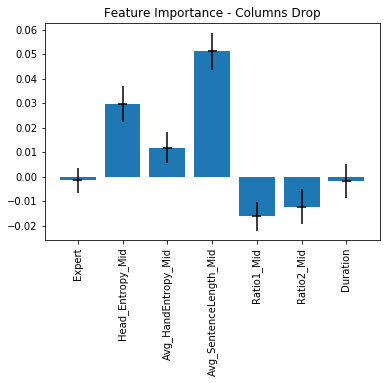

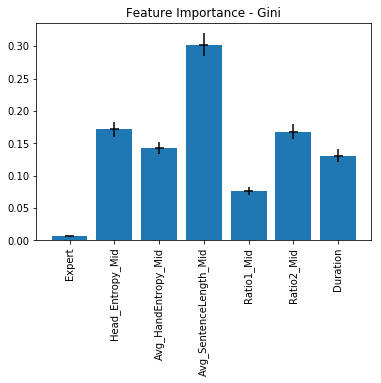

In [212]:

#print(all_scores)
all_scores_ = all_scores.drop(['fit_time', 'score_time'], axis=1).T
final = pd.DataFrame(index=all_scores_.index)

final['means'] = all_scores_.mean(axis=1)
final['std'] = all_scores_.std(axis=1)
final['sem'] = all_scores_.sem(axis=1)
final['confidence'] = all_scores_.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)



final_fi = all_dropcol_features_importances.T
final_fi['means'] = final_fi.mean(axis=1)
final_fi['std'] = final_fi.std(axis=1)
final_fi['sem'] = final_fi.sem(axis=1)
final_fi['confidence'] = final_fi.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)


plot_importance('Columns Drop', 
                final_fi['means'],
                final_fi['confidence'],
                subject_features_nophase, 
                sort=False)


final_fi_ = all_feature_importances.T
final_fi_['means'] = final_fi_.mean(axis=1)
final_fi_['std'] = final_fi_.std(axis=1)
final_fi_['sem'] = final_fi_.sem(axis=1)
final_fi_['confidence'] = final_fi_.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)


plot_importance('Gini', 
                final_fi_['means'],
                final_fi_['confidence'],
                subject_features_nophase, 
                sort=False)


In [24]:
best_params = context_df[context_df['Metric.1'] == 'score']['Best Params']
print(best_params[0])
print(type(eval(best_params[0])))
print(eval(best_params[0]).keys())
unpacked = [[p[key] for p in best_params] for key in eval(best_params[0]).keys()]
df = pd.DataFrame(data=np.vstack((scores, unpacked))).T
df.columns=['score', 'max_features', 'n_estimators', 'max_depth', 'min_samples_leaf']
print(df.sort_values(by=['score'], ascending=False))

{'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1}
<type 'dict'>
['max_features', 'n_estimators', 'max_depth', 'min_samples_leaf']


TypeError: string indices must be integers, not str

Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration'],
      dtype='object')
discretize_class columns ['Presence Score', 'Co-presence Score']
splits [[array([28,  0, 43, 72, 39, 94, 64, 12, 14, 18, 41, 31, 92, 33, 60, 71, 10,
       30, 42, 36, 34, 48,  4, 77, 47, 82, 67, 40, 53, 85, 15, 27, 59, 79,
       51, 62, 75, 44,  1, 45, 68, 70, 89, 54,  6, 13,  5, 37, 38, 22, 58,
       65, 57, 23, 56, 90, 21, 61, 20, 87, 24, 49, 32, 91, 66,  8, 81, 73,
       35, 29,  3,  7, 69, 46, 86, 93, 17, 88,  9, 19, 80, 16, 11, 95, 74,
       55]), array([52,  2, 63, 84, 26, 83, 76, 50, 25, 78])]]
train [28  0 43 72 39 94 64 12 14 18 41 31 92 33 60 71 10 30 42 36 34 48  4 77
 47 

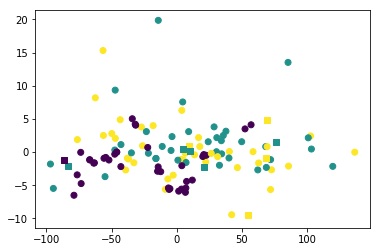

In [95]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

if 'PresenceClass_5_kmeans' in all_p_df.columns:
    all_p_df = all_p_df.drop(['PresenceClass_5_kmeans'], axis=1)
    
dataset = all_p_df
featureset = get_features_set('Doctor', '157015')
print(featureset)
ds_splits = prepare_train_data(dataset, featureset, 
                                          'presence', bins=5, strategy='kmeans', upsample='imb_smotenc', test_set=0.1, n_splits=1, arff='test1')
print('Generated %d splits' % len(ds_splits))
for (X, y, X_test, y_test) in ds_splits:
    print(np.unique(y, return_counts=True))
    print(np.unique(y_test, return_counts=True))

    kmeans = KMeans(n_clusters=3).fit(X)
    k_test_labels = kmeans.predict(X_test)
    
    pca = PCA(n_components=2)
    X_ = pca.fit_transform(X)
    X_test_ = pca.transform(X_test)
    print(X_.shape)
    plt.scatter(X_[:, 0], X_[:, 1], c=y, cmap='viridis', marker='o')
    plt.scatter(X_test_[:, 0], X_test_[:, 1], c=y_test, cmap='viridis', marker='s')
    plt.show()